In [2]:
%load_ext autoreload
% autoreload 2
from __future__ import print_function
import argparse
import os, datetime
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
print(torch.__version__)
from geant_dataloader import rtnpy_load_data
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from torch.autograd import grad
#from logistics import sigmoid_normalize, logistic_unnormalize, tanh_normalize, arctanh_unnormalize
from logistics import *
from matplotlib import gridspec
plt.rc('font', family='serif')
from decimal import Decimal

0.4.0a0+200fb22


In [47]:
# NOTE: THIS CODE ASSUMES PYTORCH 0.4 installed (more specifically, it was tested on 0.4.0a0+200fb22)



dataroot = "build/B4_2k.root"
workers = 2
batchSize = 20
imageSize =32
nz = 100
ngf = 64
ndf = 64
nc = 1
niter = 50
lr = 2e-4
beta1 = 0.5
cuda = 'store_true'
netG_path = "output/"
netD_path = "output/"
outf = "output/"
manualSeed = 25
ngpu = 1
mydir=None # will be updated before the run
epoch=0 #will be updated during the run
epochs = []
genx_FWHMs = []
genx_means = []
realx_FWHMs = []
realx_means =  []
extraD = 1

norm_scale = 'unif'

try:
    os.makedirs(outf)
except OSError:
    pass



In [48]:
if manualSeed is None:
    manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

cudnn.benchmark = True
dev_type = 'cpu'
if torch.cuda.is_available():
    print("Using Cuda")
    dev_type = 'gpu'
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print("Using:", dev_type, torch.cuda.current_device())


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

Random Seed:  25
Using Cuda
cuda:0
Using: gpu 0


In [112]:
# LOAD DATA:

#image_array = rtnpy_load_data("/home/chris/G4Builds/Geant4HadronCalorimeter/numpy_data/rebinnedGeant4Data_20000Events_64OldSize_32NewSize.npy", image_size = imageSize)
image_array = rtnpy_load_data("numpy_data/geant4Data_30000Events_"+str(imageSize) + "ImageSize_800MeV_ScintiAbsoThickness75_8.npz", image_size = imageSize)
#image_array = rtnpy_load_data("/home/chris/G4Builds/Geant4HadronCalorimeter/numpy_data/geant4Data_15000Events_64ImageSize_800MeV_ScintiAbsoThickness75_8.npy",  image_size = imageSize)
#image_array=np.concatenate((image_array1, image_array2),0)
#print(image_array.shape)

#np.savez_compressed("numpy_data/geant4Data_30000Events_64ImageSize_800MeV_ScintiAbsoThickness75_8.npz", array = image_array)
#image_array = np.load("numpy_data/test.npz")['array']
#print(image_array.shape, image_array_comp.shape)
#plt.imshow(image_array[0][0])
#plt.show()
#plt.imshow(image_array_comp[0][0])
print(image_array.shape)

(30000, 1, 32, 32)


In [50]:
#plt.hist(image_array[0][0][:,0])
# for i in range(image_array.shape[0]):
#     if np.isnan(image_array[i][0]).any():
#         del image_array[i][0]
#print(image_array[~np.isnan(image_array).any(axis=0)])
#print(image_array)
#image_array = np.delete(image_array, 10840, axis = 0)
normed_array, scale = normalize(image_array, norm_scale = norm_scale )
#normed_array, scale = sigmoid_normalize(image_array)
print(image_array.shape)
tensor_array = torch.stack([torch.Tensor(i) for i in normed_array])
tensor_data = torch.utils.data.TensorDataset(tensor_array)
dataloader = torch.utils.data.DataLoader(tensor_data, batch_size=batchSize, num_workers=8)
dataloader

(30000, 1, 32, 32)


In [73]:
if norm_scale == 'unif':
    last_layer = nn.Sigmoid()
else:
    last_layer = nn.Tanh()


class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            #nn.Tanh()
            last_layer
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


class Generator32(nn.Module):
    def __init__(self, ngpu):
        super(Generator32, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            #inc, outc, kernel, stride, padding, output padding
#             nn.ConvTranspose2d(     nz, 32 * 8, 2, 1, 0, bias=False),
#             nn.BatchNorm2d(32 * 8),
#             nn.ReLU(True),
#             # state size. (ngf*8) x 2 x 2
#             nn.ConvTranspose2d(32 * 8, 32 * 4, 2, 2, 0, bias=False),
#             nn.BatchNorm2d(32 * 4),
#             nn.ReLU(True),
#             # state size. (ngf*4) x 4 x 4
#             nn.ConvTranspose2d(32 * 4, 32 * 2, 2, 2, 0, bias=False),
#             nn.BatchNorm2d(32 * 2),
#             nn.ReLU(True),
#             # state size. (ngf*2) x 8 x 8
#             nn.ConvTranspose2d(32 * 2,     32, 2, 2, 0, bias=False),
#             nn.BatchNorm2d(32),
#             nn.ReLU(True),
#             # state size. (ngf) x 16 x 16
#             nn.ConvTranspose2d(    32,      nc, 2, 2, 0, bias=False),
#             last_layer
#             # state size. (nc) x 64 x 64
            
            nn.ConvTranspose2d(     nz, 32 * 8, 2, 1, 0, bias=False),
            nn.BatchNorm2d(32 * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 2 x 2
            nn.ConvTranspose2d(32 * 8, 32 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32 * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(32 * 4, 32 * 2, 5, 1, 0, bias=False),
            nn.BatchNorm2d(32 * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d(32 * 2,     32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d(    32,      nc, 4, 2, 0, bias=False),
            last_layer
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output
    
    
if imageSize == 32:
    netG = Generator32(ngpu).to(device)
else:
    netG = Generator(ngpu).to(device)
netG.apply(weights_init)
print(netG)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            # kernel size = 4 (so I image 4 x 4 x 1)
            # stride = 2, 
            # padding = 1
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)
    
class Discriminator32(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator32, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            # kernel size = 4 (so kernel filter 4 x 4 x 1)
            # stride = 2, 
            # padding = 0
#             nn.Conv2d(nc, 32, 2, 2, 0, bias=False),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf) x 16 x 16
#             nn.Conv2d(32, 32 * 2, 2, 2, 0, bias=False),
#             nn.BatchNorm2d(32 * 2),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*2) x 8 x 8
#             nn.Conv2d(32 * 2, 32 * 4, 2, 2, 0, bias=False),
#             nn.BatchNorm2d(32 * 4),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*4) x 4 x 4
#             nn.Conv2d(32 * 4, 32 * 8, 2, 2, 0, bias=False),
#             nn.BatchNorm2d(32 * 8),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*8) x 2 x 2
#             nn.Conv2d(32 * 8, 1, 2, 2, 0, bias=False),
#             nn.Sigmoid()
            nn.Conv2d(nc, ndf, 5, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 5, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 0, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 2, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 3, 2, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)

if imageSize == 32:
    netD = Discriminator32(ngpu).to(device)
else:
    netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
#if opt.netD != '':
#    netD.load_state_dict(torch.load(opt.netD))
print(netD)
#if netG != '':
#    netG.load_state_dict(torch.load(netG))
#print(netG)

Generator32(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(2, 2), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (13): Sigmoid()
  )
)
Discriminator32(
  (main): Sequential(
    (0): Co

In [74]:
def make_samples(netG, n_events=500, real=True, fake = True, avg = True ):

    #test_image = 0#fake.to('cpu').detach().numpy()[0][0]
    fake_image = 0 #arctanh_unnormalize(test_image, scale)
    real_image = 0
    for i in range(n_events):
        idx = np.random.randint(low = 0, high = image_array.shape[0], size =1)[0]
        real_image += image_array[idx][0]
        noise = torch.randn(batchSize, nz, 1, 1, device=device)
        fake_output = netG(noise)
        gen_image = fake_output.to('cpu').detach().numpy()[0][0]
        fake_image +=  unnormalize(gen_image, scale, norm_scale = norm_scale)
        #fake_image += logistic_unnormalize(test_image, scale)
    if avg == True:
        fake_image = fake_image / n_events
        real_image = real_image / n_events

    #test_noNans = np.copy(test_unnormed)
    #test_unnormed[test_unnormed < 0.0] = np.nan
    if real == True and fake == True:
        return [real_image,fake_image], n_events
    elif (real == False) and (fake == True):
        return fake_image, n_events
    else:
        return real_image, n_events
    
    
    

def make_stacked_samples(netG, n_events, real=False, fake=True):
    fake_images = []
    real_images = []
    for i in range(n_events):
        idx = np.random.randint(low = 0, high = image_array.shape[0], size =1)[0]
        real_image = image_array[idx][0]
        noise = torch.randn(batchSize, nz, 1, 1, device=device)
        fake_output = netG(noise)
        fake_image = fake_output.to('cpu').detach().numpy()[0][0]
        fake_image = unnormalize(fake_image,scale)
        fake_images.append(fake_image)
        real_images.append(real_image)
        
    fake_images_array = np.dstack(fake_images).T
    real_images_array = np.dstack(real_images).T
    if real == True and fake == True:
        return real_images_array,fake_images_array
    elif (real == False) and (fake == True):
        return fake_images_array
    else:
        return real_images_array


def plot_avg(data, n_events, withMarginals=True, save_dir = mydir, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr):

    test_noNans = np.copy(data)
    test_unnormed = data
    test_unnormed[test_unnormed < 0.0] = np.nan
    
    fig=plt.figure(figsize=(6, 6))
    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran
    cmap = sns.cubehelix_palette(dark = 0.4, light=0.93, gamma = 2.5, hue = 1, start =0, as_cmap=True)
    color_list = sns.cubehelix_palette(dark=0.4, light=0.93, gamma=2.5, hue=1).as_hex()
    
    if withMarginals == False:
        plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
        im = ax.imshow(test_unnormed, vmin = 0, extent=extent, origin='lower', cmap=cmap)
        cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
        cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
        if save_dir != None:
            #directory = "/home/chris/Documents/MPhilProjects/ForViewing/Geant4/SingleLayerEGun/AverageImage/"
            filename = "DCGAN_AvgEdepOver" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                        + "Image_Epochs" + str(epoch) + "_" + str(batchSize) + "batchSize_" +  str(lr) + "lr"
            plt.savefig(directory + filename)
        
    else:
        marginals_str = 'withMarginals'
        img=test_noNans
        t = np.arange(-50,50, 100/float(imageSize))
        #t = np.arange(img.shape[0])
        f = np.arange(-50,50, 100/float(imageSize))
        #f = np.arange(img.shape[1])
        flim = (f.min(), f.max())
        tlim = (t.min(), t.max())

        gs = gridspec.GridSpec(2, 2, width_ratios=[1,5], height_ratios=[1,5])
        gs.update(hspace=0, wspace=0)

        ax = fig.add_subplot(gs[1,1])
        im = ax.imshow(test_unnormed, vmin = 0, extent = extent, origin = 'lower', cmap = cmap)
        cbaxes = fig.add_axes([0.97, 0.18, 0.03, 0.55]) 
        cbar = plt.colorbar(mappable=im, ticks = None, cax=cbaxes, use_gridspec=True)
        ax.yaxis.set_ticks_position('right')
        cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
        ax.spines["top"].set_visible(False)
        ax.spines['left'].set_visible(False)

        axl = fig.add_subplot(gs[1,0], sharey=ax)
        axl.fill_between(img.mean(1), f, alpha = 0.7, color = color_list[1])
        axl.invert_xaxis()
        axb = fig.add_subplot(gs[0,1], sharex=ax)
        axb.fill_between(t, img.mean(0), alpha =0.7, color= color_list[1])

        plt.setp(axl.get_yticklabels(), visible=False)
        plt.setp(axb.get_xticklabels(), visible=False)
        plt.setp(axl.get_xticklabels(), visible=False)
        plt.setp(axb.get_yticklabels(), visible=False)

        axl.yaxis.set_ticks_position('none')
        axb.xaxis.set_ticks_position('none')
        axl.xaxis.set_ticks_position('none')
        axb.yaxis.set_ticks_position('none')


        axl.spines["top"].set_visible(False)
        axl.spines['right'].set_visible(False)
        axl.spines['left'].set_visible(False)
        axl.spines['bottom'].set_visible(False)
        axb.spines["top"].set_visible(False)
        axb.spines["right"].set_visible(False)
        axb.spines["left"].set_visible(False)
        axb.spines["bottom"].set_visible(False)
        ax.set_xlim(tlim)
        ax.set_xlabel(r"$\mathit{x}$", fontsize = 12)
        ax.xaxis.set_label_coords(0.02,-0.05)
        ax.set_ylim(tlim)
        ax.set_ylabel(r"$\mathit{y}$", fontsize = 12, rotation = 0)
        ax.yaxis.set_label_coords(1.07,0.98)
        if save_dir != None:
            learning_rate = '%.0E' % Decimal(lr)
            #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCGAN/"
            filename = "DCGAN_AvgEdep"+str(marginals_str) + "Over" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                        + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.png"
            plt.savefig(save_dir + filename, bbox_inches='tight')
        plt.show()
    return

def plot_samples(n_samples = 3 ):
    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran
    vmin = 0.1
    vmax = 2.0
    fig, ax_arr = plt.subplots(1, n_samples, figsize=(10,10), sharey = True, sharex=True)
    i = 0
    for ax in ax_arr.flatten():
        
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        test_image = fake.to('cpu').detach().numpy()[0][0]
        test_unnormed =  arctanh_unnormalize(test_image, scale)
        test_unnormed[test_unnormed < 0.1] = np.nan
        cmap = sns.cubehelix_palette(dark = 0.4, light=0.99, gamma = 2.5, hue = 1, start =0, as_cmap=True)
    #plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
        im = ax.imshow(test_unnormed, vmin = 0, extent=extent, origin='lower', cmap=cmap)
        if i == 0:   
            cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
        i+=1
    plt.show()
    return

def plot_sns(n_events = 500, n_samples = 3, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
    
    fig, axn = plt.subplots(1, n_samples, figsize=(12,4), sharex=True, sharey=True)
    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran

    #xticks = [-50,-25,0,25,50]
    #yticks = [-50,-25,0,25,50]
    for i, ax in enumerate(axn.flat):
        noise = torch.randn(batchSize, nz, 1, 1, device=device)
        fake = netG(noise)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(True)
        if i != 0:
            ax.spines['left'].set_visible(False)
        if i == 0:
            ax.set_xlabel(r"$\mathit{x}$", fontsize=13, x = 0.96)
            ax.set_ylabel(r"$\mathit{y}$", fontsize=13, rotation=0, y = .95)
        ax.set_title("Ex " +str(i), x =0.85, y = 0.88, alpha=0.6, fontweight='heavy', fontsize=11)
        test_image = fake.to('cpu').detach().numpy()[0][0]
        test_unnormed =  unnormalize(test_image, scale)
        #test_unnormed = logistic_unnormalize(test_image, scale)
        test_unnormed[test_unnormed < 0.1] = np.nan
        cmap = sns.cubehelix_palette(dark = 0.4, light=0.99, gamma = 2.5, hue = 1, start =0, as_cmap=True)
        #sns.heatmap(test_unnormed, ax=ax, cmap=cmap,
        #            cbar=i == 0, cbar_ax=None if i else cbar_ax, square=True,
        #            vmin = 0, vmax = 80, xticklabels = xticks, yticklabels=xticks)
        im = ax.imshow(test_unnormed, vmin = 0, vmax=10, extent=extent, origin='lower', cmap=cmap)
        ax.tick_params(axis=u'both', which=u'both',length=0)

    fig.tight_layout(rect=[0, 0, .9, 1])
    cbar_ax = fig.add_axes([0.9, 0.25, 0.025, 0.5])
    fig.colorbar(im, cax=cbar_ax)
    fig.subplots_adjust(wspace=0.1, hspace=0)
    fig.suptitle("Samples of Generated Electron Gun Energy Depositions",x=0.5,y=0.99)
    if save_dir != None:
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCGAN/"
        filename = "DCGAN_3SampleEdepOver" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                    + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.png"
        plt.savefig(save_dir + filename, bbox_inches='tight')
    plt.show()
    return



def plot_avg_both(real_data, fake_data, n_events, withMarginals=True, save_dir=None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
    fig=plt.figure(figsize=(10,5))
    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran

    #real_data = real_image
    img = real_data
    test_unnormed = fake_data
    test_noNans = np.copy(test_unnormed)
    img2 = test_noNans
    t = np.arange(-50,50, 100/float(imageSize))
    #t = np.arange(img.shape[0])
    f = np.arange(-50,50, 100/float(imageSize))
    #f = np.arange(img.shape[1])
    flim = (f.min(), f.max())
    tlim = (t.min(), t.max())


    gs = gridspec.GridSpec(2, 4, width_ratios=[5,1,1,5], height_ratios=[1,5])
    gs.update(hspace=0, wspace=0)
    ax1 = fig.add_subplot(gs[1,0])
    axl = fig.add_subplot(gs[1,1], sharey=ax1)
    axb = fig.add_subplot(gs[0,0], sharex=ax1)
    ax2 = fig.add_subplot(gs[1,3])
    axl2= fig.add_subplot(gs[1,2], sharey=ax2)
    axb2= fig.add_subplot(gs[0,3], sharex=ax2)
    plt.setp(axl.get_yticklabels(), visible=False)
    plt.setp(axb.get_xticklabels(), visible=False)
    plt.setp(axl.get_xticklabels(), visible=False)
    plt.setp(axb.get_yticklabels(), visible=False)
    plt.setp(axl2.get_yticklabels(), visible=False)
    plt.setp(axb2.get_xticklabels(), visible=False)
    plt.setp(axl2.get_xticklabels(), visible=False)
    plt.setp(axb2.get_yticklabels(), visible=False)
    axl.yaxis.set_ticks_position('none')
    axb.xaxis.set_ticks_position('none')
    axl.xaxis.set_ticks_position('none')
    axb.yaxis.set_ticks_position('none')
    axl2.yaxis.set_ticks_position('none')
    axb2.xaxis.set_ticks_position('none')
    axl2.xaxis.set_ticks_position('none')
    axb2.yaxis.set_ticks_position('none')
    cmap = sns.cubehelix_palette(dark = 0.4, light=0.94, gamma = 2.5, hue = 1, start =0, as_cmap=True)
    im = ax1.imshow(real_data, vmin = 0, extent =extent, origin='lower', cmap=cmap)
    ax1.spines["top"].set_visible(False)
    ax1.spines['right'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    color_list = sns.cubehelix_palette(dark=0.4, light=0.94, gamma=2.5, hue=1).as_hex()
    axl.fill_between(img.mean(1), f, alpha = 0.7, color = color_list[1])
    axl.spines["top"].set_visible(False)
    axl.spines['right'].set_visible(False)
    axl.spines['left'].set_visible(False)
    axl.spines['bottom'].set_visible(False)
    axb.fill_between(t, img.mean(0), alpha =0.7, color= color_list[1])
    axb.spines["top"].set_visible(False)
    axb.spines["right"].set_visible(False)
    axb.spines["left"].set_visible(False)
    axb.spines["bottom"].set_visible(False)
    ax1.set_xlim(tlim)
    
    ax1.set_ylim(tlim)


    #RECONSIDER TAKING OUT THE LESS THAN 0 VALUES
    real_data[real_data < 0.0] = np.nan 


    test_unnormed[test_unnormed < 0.0] = np.nan

    im = ax2.imshow(test_unnormed, vmin = 0, extent=extent, origin='lower', cmap=cmap)
    ax2.spines["top"].set_visible(False)
    ax2.spines['left'].set_visible(False)
    axl2.fill_between(img2.mean(1), f, alpha = 0.7, color = color_list[1])
    axl2.invert_xaxis()
    axl2.spines["top"].set_visible(False)
    axl2.spines['right'].set_visible(False)
    axl2.spines['left'].set_visible(False)
    axl2.spines['bottom'].set_visible(False)
    axb2.fill_between(t, img2.mean(0), alpha =0.7, color= color_list[1])
    axb2.spines["top"].set_visible(False)
    axb2.spines["right"].set_visible(False)
    axb2.spines["left"].set_visible(False)
    axb2.spines["bottom"].set_visible(False)
    ax2.set_xlim(tlim)
    ax2.set_ylim(tlim)

    ax1.set_xlabel("Real", fontsize=11)  
    ax2.set_xlabel("Generator", fontsize=11)
    ax1.set_ylabel(r"$\mathit{y}$", fontsize = 12, rotation = 0)
    ax1.yaxis.set_label_coords(-0.07,0.98)
    fig.tight_layout(rect=[0, 0, .9, 1])
    cbar_ax = fig.add_axes([0.9, 0.25, 0.025, 0.45])
    cb = fig.colorbar(im, cax=cbar_ax)
    cb.set_label(r'$E_{dep}$ (MeV)', y =0.85)
    plt.figtext(0.05,0.060,r"$\mathit{x}$", fontsize = 12)
    fig.subplots_adjust(wspace=0.1, hspace=0)
    fig.suptitle(r" DCGAN Avg $E_{dep}$ Over " + str(n_events) + " Events, "
                 + str(imageSize) + "x" +str(imageSize) + " \n Image Size, " + str(epoch) 
                 + " Epochs, " + str(batchSize) + " Batch Size", x = 0.46, y = 0.02)
    if save_dir != None:
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCGAN/"
        filename = "DCGAN_RealandFakeAvgEdep"+str(withMarginals) + "Over" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                            + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr"
        plt.savefig(save_dir + filename, bbox_inches='tight')
    plt.show()
    return



def plot_many(data, rows = 1,columns = 4, real = True, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
    
    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran
    
    if rows <= 2 and columns <=4:
        scale_factor = 3.5
    else:
        scale_factor = 2
    
    fig, axes =plt.subplots(rows,columns, figsize=(scale_factor*columns, scale_factor*rows), sharex=True,sharey=True)
    event_number = 0
    plt.locator_params(axis='y', nbins=1)
    plt.locator_params(axis='x', nbins=2)
    #fig.xticks(rotation=45)
    for i in range(rows):
        for j in range(columns):

            image_array = data[event_number]

            image_array[image_array < 0.01] = np.nan
            cmap = sns.cubehelix_palette(dark = 0.4, light=0.96, gamma = 2.5, hue = 1, start =0, as_cmap=True)
            #cmap = sns.light_palette((210, 95, 30), input='husl', as_cmap=True)
            #cmap = sns.dark_palette('muted purple', as_cmap=True, input='xkcd')
            #cmap = sns.color_palette("BrBG",7)

            plt.axis('on')
            if rows == 1:
                #axes[j] = plt.subplot(gs1[i,j])
                if j != 0:
                    axes[j].spines['left'].set_visible(False)
                else:
                    axes[j].set_xlabel(r"$\mathit{x}$", fontsize=13, x = 0.96)
                    axes[j].set_ylabel(r"$\mathit{y}$", fontsize=13, rotation=0, y = .95)
                axes[j].spines['top'].set_visible(False)
                axes[j].spines['right'].set_visible(False)

                #axes[j].set_aspect('equal')
                im =axes[j].imshow(image_array, vmin = 0, extent=extent, origin='lower', cmap=cmap)
                #axes[i,j].set_xticklabels([-100,0,100],rotation=90)
                axes[j].set_xticklabels([])
                axes[j].set_yticklabels([])
                axes[j].xaxis.set_ticks_position('none')
                axes[j].yaxis.set_ticks_position('none')
                event_number +=1
            else:
                #axes[i,j].spines['top'].set_visible(False)
                axes[i,j].spines['bottom'].set_visible(True)
                if j!= 0:
                    axes[i,j].spines['left'].set_visible(False)
                if i == range(rows)[-1] and j == 0:
                    axes[i,j].set_xlabel(r"$\mathit{x}$", fontsize=13, x = 0.96)
                    axes[i,j].set_ylabel(r"$\mathit{y}$", fontsize=13, rotation=0, y = .95)
                    
                if j == range(columns)[-1]:
                    axes[i,j].spines['right'].set_visible(True)
                else:
                    axes[i,j].spines['right'].set_visible(False)
                im =axes[i,j].imshow(image_array, vmin = 0, extent=extent, origin='lower', cmap=cmap)
                #axes[i,j].set_xticklabels([-100,0,100],rotation=90)
                axes[i,j].set_xticklabels([])
                axes[i,j].set_yticklabels([])
                axes[i,j].xaxis.set_ticks_position('none')
                axes[i,j].yaxis.set_ticks_position('none')
                event_number +=1
    #fig.tight_layout(rect=[0, 0, .9, 1])
    cbar_ax = fig.add_axes([0.92, 0.18, 0.02, 0.66])
   # fig.text(0.5,0.04, "Some very long and even longer xlabel", ha="center", va="center")
    #fig.text(0.05,0.5, "Some quite extensive ylabel", ha="center", va="center", rotation=90)

    cb = fig.colorbar(im, cax=cbar_ax)
    cb.set_label(r'$E_{dep}$ (MeV)', y =0.85)
    #plt.tight_layout()
    fig.subplots_adjust(wspace=-0.085, hspace=0.00)
    if real == True:
        fig.suptitle("Samples of Geant4 Electron Gun Energy Depositions", y = 0.95)
    else:
        fig.suptitle("DCGAN Samples of Generator Electron Gun Energy Depositions, Epoch " + str(epoch), y=0.95)
    
    num_samples = rows *columns
        
        
    if save_dir != None:
        if real == True:
            type_string = "real"
        else:
            type_string = "fake"
        
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCGAN/"
        filename = "DCGAN_"+str(num_samples) + type_string+ "SamplesEdepOver" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                            + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr"
        #print(save_dir)
        plt.savefig(save_dir + filename, bbox_inches='tight')
        
    plt.show()
    return

def plot_difference(real_fake_list, n_events = 500, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
#mean_normalizer = data_test[1][data_test[1] > 0.0].max()
    data = (real_fake_list[0] - real_fake_list[1]) 
#plot_avg(data_diff, n_events = 5000, save_dir=None)
    test_noNans = np.copy(data)
    test_unnormed = data
#test_unnormed[test_unnormed < ] = np.nan

    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran
    if imageSize ==64:
        vmin = -5
        vmax = 5
    elif imageSize == 32:
        vmin = -8
        vmax = 8
    t = np.arange(-50,50, 100/float(imageSize))
    #t = np.arange(img.shape[0])
    f = np.arange(-50,50, 100/float(imageSize))
    #f = np.arange(img.shape[1])
    flim = (f.min(), f.max())
    tlim = (t.min(), t.max())
    #cmap = sns.cubehelix_palette(dark = 0.4, light=0.93, gamma = 2.5, hue = 1, start =2, as_cmap=True)
    #cmap = sns.light_palette((210, 95, 30), input='husl', as_cmap=True)
    #cmap = sns.color_palette("BrBG", 7, as_cmap=True)
    cmap = sns.diverging_palette(30, 270, s=80, l=55, n=11, as_cmap = True)
    color_list = sns.cubehelix_palette(dark=0.4, light=0.93, gamma=2.5, hue=1).as_hex()


    fig, ax=plt.subplots(figsize=(6, 6))
    #plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
    im = ax.imshow(test_unnormed, vmin = vmin,vmax = vmax, extent=extent, origin='lower', cmap='PuOr', label ='DCROTHGAN')
    cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
    cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
    plt.title(r"$E_{avg}^{G4} - E_{avg}^{GAN}$, Epoch " + str(epoch))
    ax.text(-45, 39, 'DCGAN', color='black', 
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    #plt.legend(loc = 'best')
    ax.set_xlim(tlim)
    ax.set_xlabel(r"$\mathit{x}$", fontsize = 12)
    ax.xaxis.set_label_coords(0.51,-0.08)
    ax.set_ylim(tlim)
    ax.set_ylabel(r"$\mathit{y}$", fontsize = 12, rotation = 0)
    ax.yaxis.set_label_coords(-.1,0.48)
    ax.spines["top"].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    
    if save_dir != None:
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
        filename = "DCROTHGAN_EdepDifference"+str(marginals_str) + "Over" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                    + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.png"
        plt.savefig(save_dir + filename, bbox_inches='tight')

    plt.show()
    return

def plot_FWHMs(gen_FWHMs, real_FWHMs, epochs = epochs, n_epochs=niter,  bs=batchSize, extraD=extraD, norm_scale=norm_scale, save_dir = None):



    print(type(bs))
    FWHM_comp =  "FWHMComp_Egun_Edep_DCGAN_" + str(bs) + "BatchSize_" + str(len(epochs)) + "Epoch_" +  \
                str(extraD) + "ExtraD " + str(norm_scale) +  "normalized "
    fig = plt.figure(figsize=(6,4))
    plt.scatter(epochs, real_FWHMs, alpha = 0.8, label='Geant4')
    plt.scatter(epochs, gen_FWHMs, alpha = 0.8,  label='generator')
    plt.xlabel("Epoch", fontsize = 12.5)
    plt.ylabel("FWHM", fontsize = 12.5)
    #plt.ylim(0,50)
    plt.xlim(0,n_epochs)
    plt.title(r" FWHM  for $E_{dep}$ diff, $N_{D}$ =" +  str(extraD) + " Batch Size " + str(bs) + " Input Norm " + str(norm_scale), fontsize=11)
    plt.legend(loc='best')
    if save_dir != None:
        
        plt.savefig(save_dir + FWHM_comp)
    plt.show()

    return 

def hist_width(hist_data):

    mean = hist_data.mean()
    std = hist_data.std()
    FWHM = 2.*np.sqrt(2.*np.log(2.))*std
    #line2 = FWHM - (FHWM / 2)
    #line1 = line2 - FWHM

    return FWHM

def plot_all_metrics(gen_FWHMs, g4_FWHMs, gen_means, g4_means, epochs, bs=batchSize, n_epochs =niter, extraD = extraD, norm_scale=norm_scale, save_dir =None):

#     if gamma == 0.1:
#         gamma_val = str('01')
#     elif gamma == 0.5:
#         gamma_val = str('05')
#     elif gamma == 1.0:
#         gamma_val = str('1')

    #gen_means = np.array(gen_means)
    #gen_means = gen_means
    #gen_kurts = gen_means[:,1]
    #g4 = np.array(g4_means)
    #g4_means = g4_means
    #g4_kurts = g4_means[:,1]

    #if Kurts == True:
    #    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4), sharey = False, sharex = True)

    #else:

    #print(type(gen_FWHMs), type)
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(9,4), sharey = False, sharex = True)

    ax1.scatter(epochs, g4_FWHMs, alpha = 0.75, label = 'geant4');
    ax1.scatter(epochs, gen_FWHMs, alpha = 0.70, label = 'generator');
    ax1.set_title("FWHMs")
    if len(epochs) < n_epochs/2:
        ax1.set_xlim(0,n_epochs /2)
    else:
        ax1.set_xlim(0,n_epochs)
    fig.suptitle(r" Distribution Metrics for $E_{dep}$, $N_{D}$ =" + str(extraD) + " Batch Size " + str(bs) + " Input Norm " 
        + str(norm_scale), x=0.5, y = 1.02, fontsize = 14) 
    #plt.xlabel(r"Difference in $P_{T}$ compared to Ground Truth")
    #ax1.set_xlabel(r"$P_{T} - P_{T}^{sim} $ (MeV)", fontsize = 16)
    #ax1.set_ylabel("FWHM", fontsize = 14)
    #ax1.set_ylim(0,9000)

    ax2.scatter(epochs, g4_means, alpha = 0.75, label = 'geant4');
    ax2.scatter(epochs, gen_means, alpha = 0.70, label = 'generator');
    ax2.set_title("Means")
    if len(epochs) < n_epochs/2:
        ax2.set_xlim(0,n_epochs /2)
    else:
        ax2.set_xlim(0,n_epochs)

#     if Kurts == True:
#         ax3.scatter(epochs, delphes_kurts,alpha = 0.75, label = 'delphes');
#         ax3.scatter(epochs, gen_kurts, alpha = 0.70, label = 'generator');
#         ax3.set_title("Kurtoses")
#         ax3.set_ylim(0,5)

    fig.text(0.5, -0.01, "Epoch", ha = 'center', fontsize = 15)
    ax1.legend(loc='best')
    #if Kurts == True:
    #    ax1.legend(bbox_to_anchor=[3.94, 0.5], loc='center right')
    #else:
    ax1.legend(bbox_to_anchor=[2.64, 0.5], loc='center right')


    if save_dir != None:
        FWHMs_Means_comp =  'FHWMsMeans_Edep_EGunDCGAN_'  \
             + str(bs) + "BatchSize_" + str(len(epochs)) + "Epoch_" \
              + str(extraD) + "ExtraD_" + str(norm_scale) + "Normalized"

        #file_path = "/home/chris/Documents/MPhilProjects/ForViewing/plots/eGunPTSmearing/FWHMsMeans/"
        plt.savefig(save_dir + FWHMs_Means_comp, bbox_inches="tight")

    plt.show()

    return


In [75]:
# real_data_array, fake_data_array = make_stacked_samples(netG, n_events = 500,real= True, fake = True)

# #mydir = "/home/chris/Documents/"
# plot_many(fake_data_array,real=False, save_dir=None)
# plot_all_metrics(genx_FWHMs, realx_FWHMs, genx_means, realx_means,epochs = epochs, save_dir = None)

# #plot_many(real_data_array,real=True)

In [76]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(batchSize, nz, 1, 1, device=device)
real_label = 1 - .001
fake_label = 0 + .001
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCGAN/2018-05-30_23-33-16/
<type 'int'>


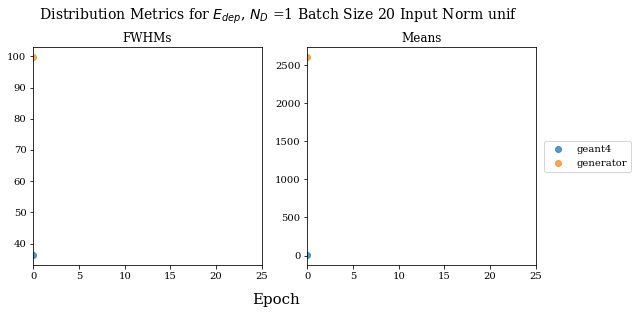

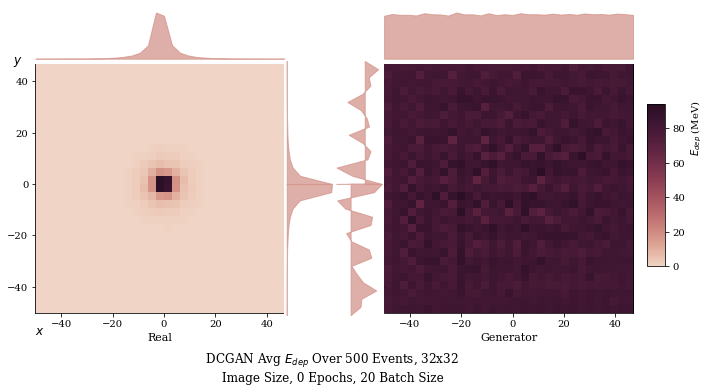

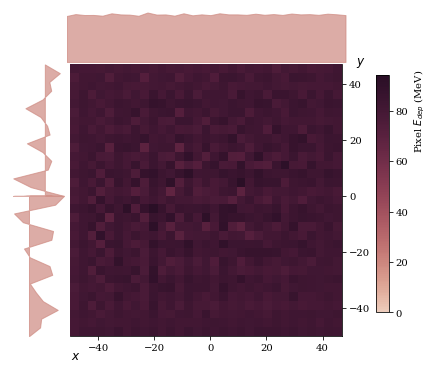

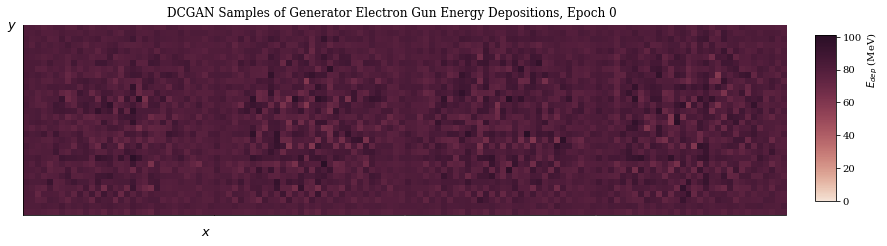

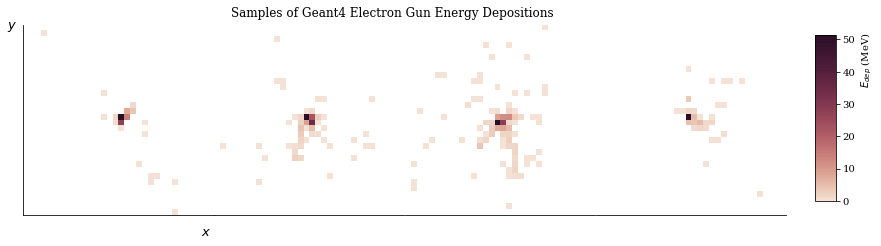

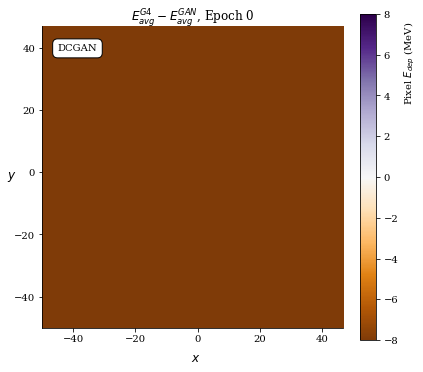

[0/50][0/1500] Loss_D: 1.5934 Loss_G: 7.6389 D(x): 0.5012 D(G(z)): 0.5545 / 0.0005
[0/50][100/1500] Loss_D: 0.0171 Loss_G: 7.2062 D(x): 0.9979 D(G(z)): 0.0015 / 0.0008

[0/50][200/1500] Loss_D: 0.0161 Loss_G: 7.2334 D(x): 0.9986 D(G(z)): 0.0013 / 0.0007
[0/50][300/1500] Loss_D: 0.0159 Loss_G: 7.0437 D(x): 0.9990 D(G(z)): 0.0010 / 0.0009
[0/50][400/1500] Loss_D: 0.0163 Loss_G: 7.9354 D(x): 0.9995 D(G(z)): 0.0016 / 0.0004
[0/50][500/1500] Loss_D: 0.0159 Loss_G: 7.1052 D(x): 0.9990 D(G(z)): 0.0010 / 0.0008
[0/50][600/1500] Loss_D: 0.0413 Loss_G: 0.8491 D(x): 0.9773 D(G(z)): 0.0000 / 0.4285
[0/50][700/1500] Loss_D: 0.0174 Loss_G: 6.1358 D(x): 0.9978 D(G(z)): 0.0031 / 0.0022
[0/50][800/1500] Loss_D: 0.0291 Loss_G: 5.4664 D(x): 0.9946 D(G(z)): 0.0139 / 0.0042
[0/50][900/1500] Loss_D: 0.2887 Loss_G: 2.7767 D(x): 0.8522 D(G(z)): 0.1109 / 0.0622
[0/50][1000/1500] Loss_D: 0.2945 Loss_G: 2.8463 D(x): 0.8282 D(G(z)): 0.0827 / 0.0606
[0/50][1100/1500] Loss_D: 0.9116 Loss_G: 7.8565 D(x): 0.8994 D(G(

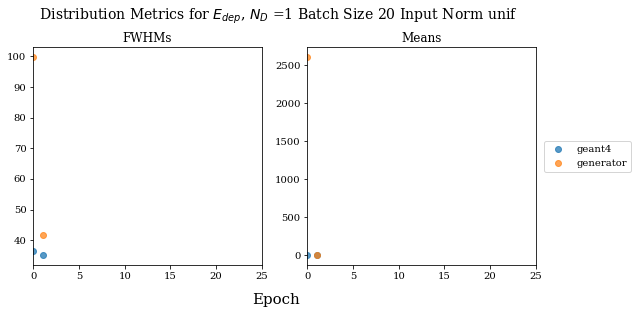

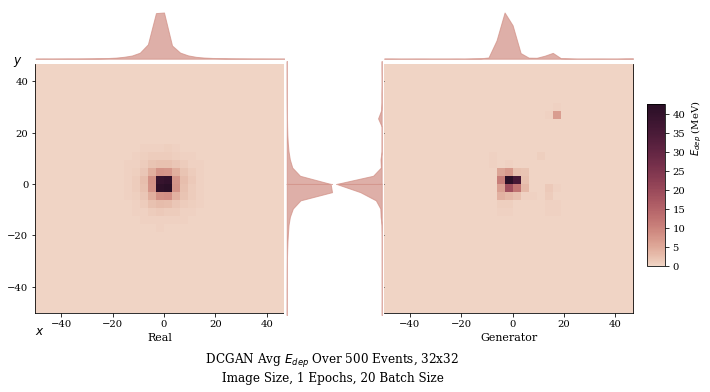

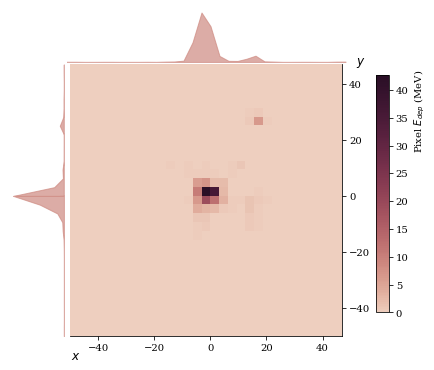

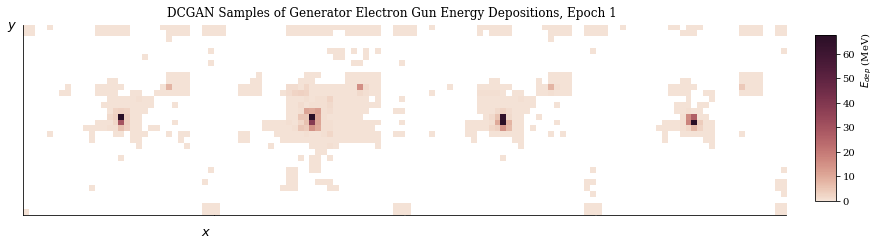

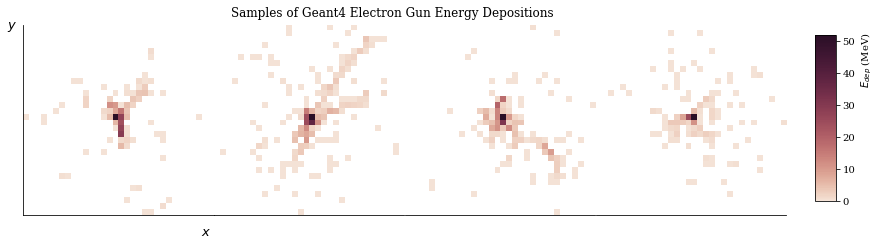

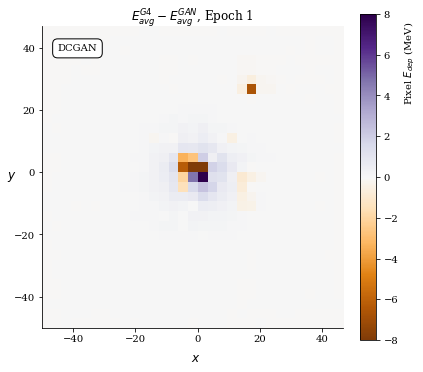

[1/50][0/1500] Loss_D: 0.3439 Loss_G: 2.3505 D(x): 0.8249 D(G(z)): 0.0371 / 0.1135
[1/50][100/1500] Loss_D: 0.4037 Loss_G: 3.4943 D(x): 0.7720 D(G(z)): 0.0559 / 0.0457
[1/50][200/1500] Loss_D: 0.5514 Loss_G: 2.8021 D(x): 0.7177 D(G(z)): 0.0420 / 0.0853
[1/50][300/1500] Loss_D: 0.2309 Loss_G: 3.7149 D(x): 0.8861 D(G(z)): 0.0870 / 0.0337
[1/50][400/1500] Loss_D: 0.1290 Loss_G: 4.1709 D(x): 0.9129 D(G(z)): 0.0121 / 0.0523
[1/50][500/1500] Loss_D: 0.8799 Loss_G: 1.8613 D(x): 0.5703 D(G(z)): 0.0699 / 0.1704
[1/50][600/1500] Loss_D: 0.0492 Loss_G: 5.6760 D(x): 0.9705 D(G(z)): 0.0076 / 0.0049
[1/50][700/1500] Loss_D: 0.3142 Loss_G: 3.4262 D(x): 0.8165 D(G(z)): 0.0258 / 0.0452
[1/50][800/1500] Loss_D: 0.6188 Loss_G: 6.9485 D(x): 0.7859 D(G(z)): 0.2208 / 0.0017
[1/50][900/1500] Loss_D: 0.2697 Loss_G: 3.8522 D(x): 0.8890 D(G(z)): 0.0649 / 0.0351
[1/50][1000/1500] Loss_D: 0.1626 Loss_G: 6.6871 D(x): 0.8804 D(G(z)): 0.0192 / 0.0036
[1/50][1100/1500] Loss_D: 0.5478 Loss_G: 2.6016 D(x): 0.6873 D(G(z

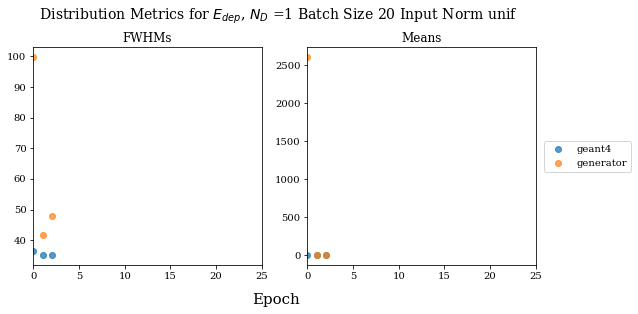

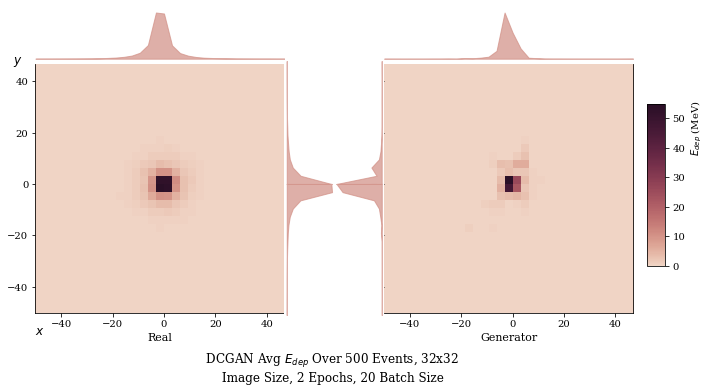

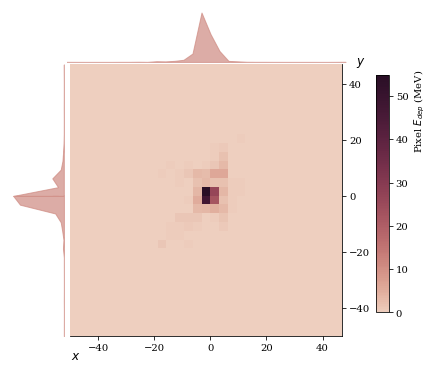

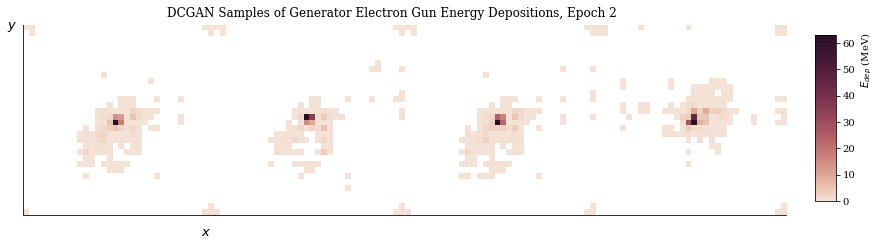

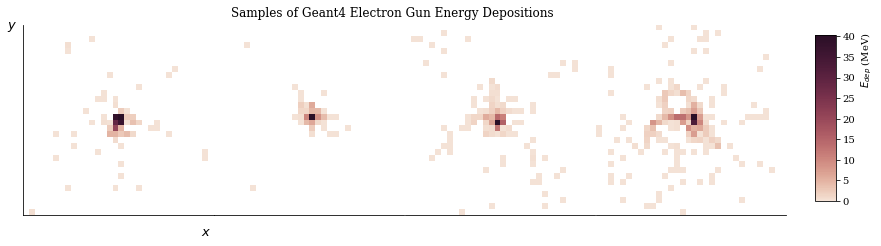

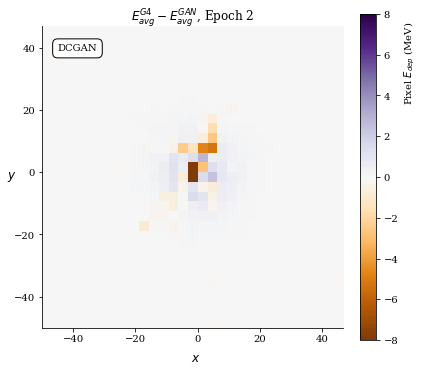

[2/50][0/1500] Loss_D: 0.2232 Loss_G: 3.0381 D(x): 0.8693 D(G(z)): 0.0477 / 0.0543
[2/50][100/1500] Loss_D: 0.4909 Loss_G: 2.8758 D(x): 0.7298 D(G(z)): 0.0206 / 0.0630
[2/50][200/1500] Loss_D: 0.7049 Loss_G: 1.7858 D(x): 0.6706 D(G(z)): 0.0408 / 0.2042
[2/50][300/1500] Loss_D: 0.2850 Loss_G: 4.0337 D(x): 0.8031 D(G(z)): 0.0256 / 0.0226
[2/50][400/1500] Loss_D: 0.4410 Loss_G: 6.1699 D(x): 0.9576 D(G(z)): 0.3046 / 0.0040
[2/50][500/1500] Loss_D: 0.1761 Loss_G: 3.6066 D(x): 0.8877 D(G(z)): 0.0389 / 0.0290
[2/50][600/1500] Loss_D: 0.1445 Loss_G: 7.6630 D(x): 0.8959 D(G(z)): 0.0010 / 0.0013
[2/50][700/1500] Loss_D: 0.5331 Loss_G: 3.9053 D(x): 0.8048 D(G(z)): 0.1702 / 0.0263
[2/50][800/1500] Loss_D: 0.3241 Loss_G: 7.9946 D(x): 0.7731 D(G(z)): 0.0009 / 0.0006
[2/50][900/1500] Loss_D: 0.2008 Loss_G: 5.6059 D(x): 0.9924 D(G(z)): 0.1518 / 0.0046
[2/50][1000/1500] Loss_D: 0.1010 Loss_G: 4.3619 D(x): 0.9836 D(G(z)): 0.0704 / 0.0180
[2/50][1100/1500] Loss_D: 0.3143 Loss_G: 3.7792 D(x): 0.7965 D(G(z

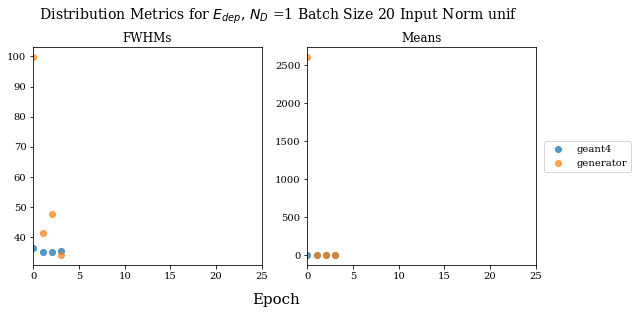

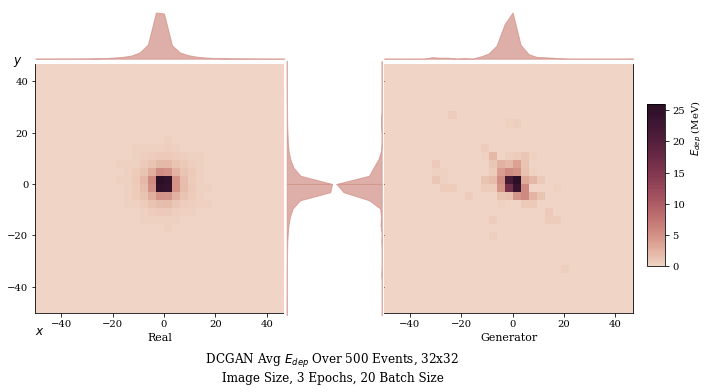

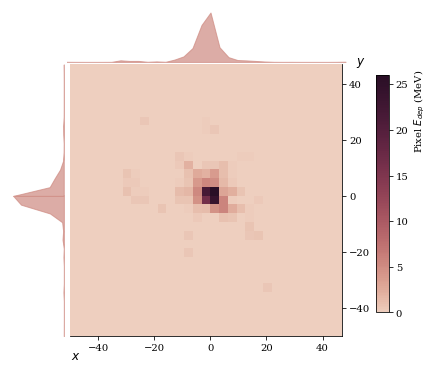

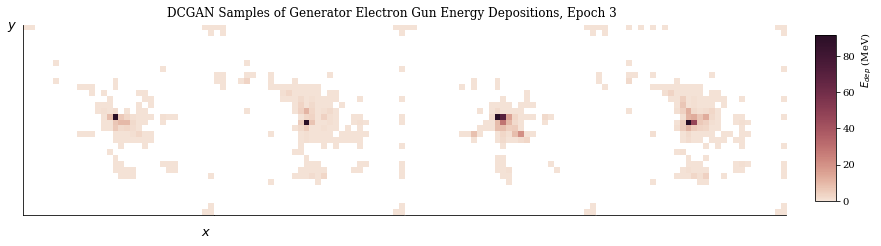

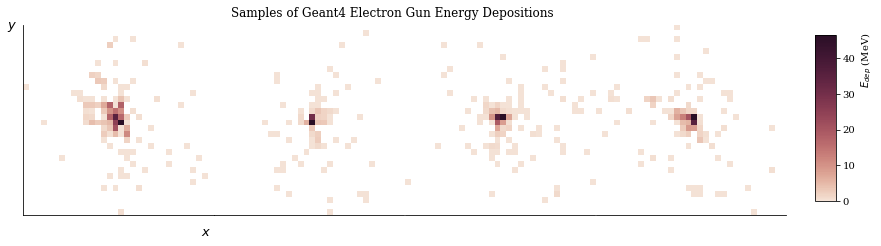

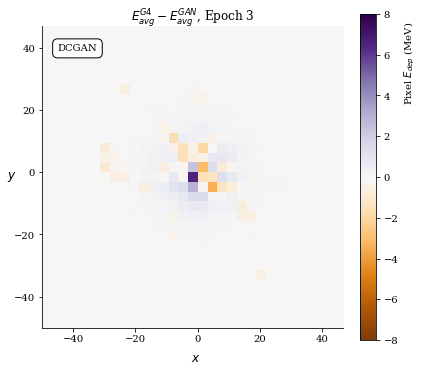

[3/50][0/1500] Loss_D: 0.6586 Loss_G: 1.5322 D(x): 0.6073 D(G(z)): 0.0187 / 0.3006
[3/50][100/1500] Loss_D: 0.1963 Loss_G: 5.2729 D(x): 0.9236 D(G(z)): 0.0898 / 0.0115
[3/50][200/1500] Loss_D: 0.3118 Loss_G: 4.8056 D(x): 0.9278 D(G(z)): 0.1906 / 0.0098
[3/50][300/1500] Loss_D: 0.1682 Loss_G: 5.1877 D(x): 0.9235 D(G(z)): 0.0590 / 0.0119
[3/50][400/1500] Loss_D: 0.0643 Loss_G: 4.4788 D(x): 0.9738 D(G(z)): 0.0265 / 0.0141
[3/50][500/1500] Loss_D: 0.3171 Loss_G: 3.2639 D(x): 0.8616 D(G(z)): 0.1345 / 0.0573
[3/50][600/1500] Loss_D: 0.1631 Loss_G: 4.3913 D(x): 0.9987 D(G(z)): 0.1379 / 0.0145
[3/50][700/1500] Loss_D: 0.6820 Loss_G: 8.2655 D(x): 0.9794 D(G(z)): 0.4364 / 0.0003
[3/50][800/1500] Loss_D: 0.1921 Loss_G: 5.2533 D(x): 0.9042 D(G(z)): 0.0108 / 0.0090
[3/50][900/1500] Loss_D: 0.1328 Loss_G: 4.3314 D(x): 0.9824 D(G(z)): 0.0917 / 0.0222
[3/50][1000/1500] Loss_D: 0.1501 Loss_G: 4.5896 D(x): 0.9677 D(G(z)): 0.0990 / 0.0123
[3/50][1100/1500] Loss_D: 0.2477 Loss_G: 4.0834 D(x): 0.8452 D(G(z

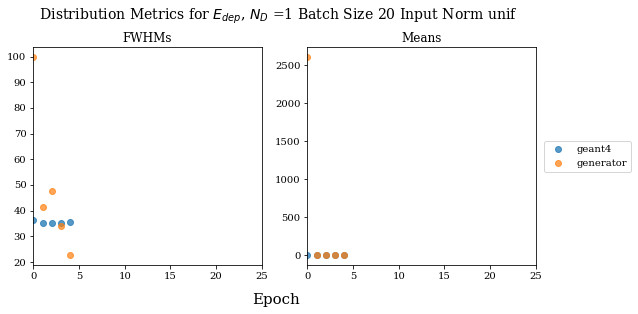

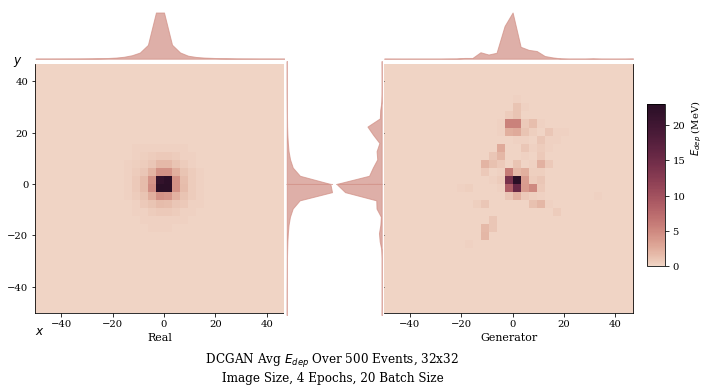

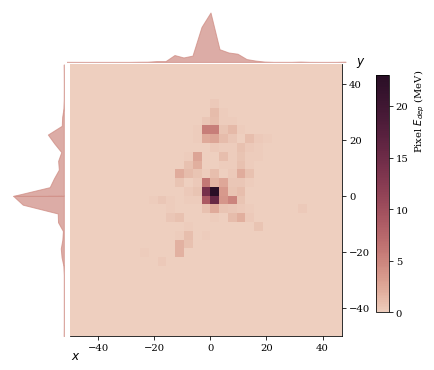

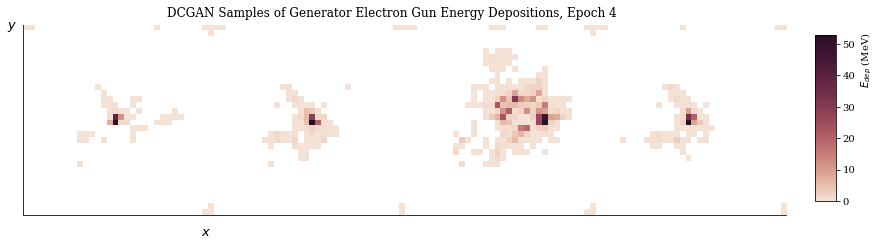

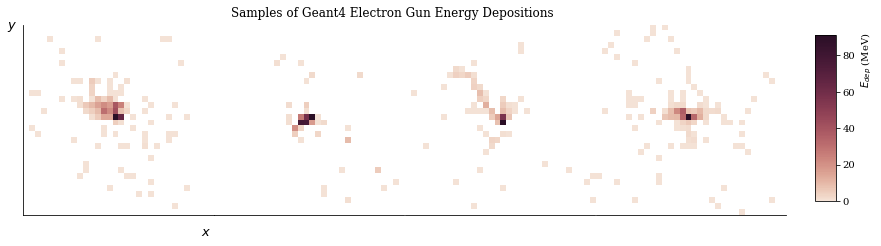

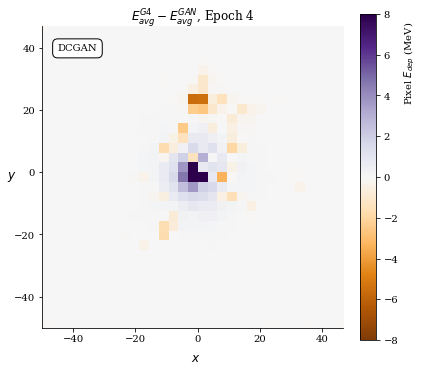

[4/50][0/1500] Loss_D: 0.3977 Loss_G: 3.7920 D(x): 0.7952 D(G(z)): 0.0396 / 0.0491
[4/50][100/1500] Loss_D: 0.1778 Loss_G: 3.9278 D(x): 0.8946 D(G(z)): 0.0067 / 0.0264
[4/50][200/1500] Loss_D: 0.1534 Loss_G: 3.3731 D(x): 0.9038 D(G(z)): 0.0350 / 0.0393
[4/50][300/1500] Loss_D: 0.5643 Loss_G: 2.1940 D(x): 0.6759 D(G(z)): 0.0530 / 0.1685
[4/50][400/1500] Loss_D: 0.3103 Loss_G: 4.0853 D(x): 0.9797 D(G(z)): 0.2049 / 0.0251
[4/50][500/1500] Loss_D: 0.1157 Loss_G: 4.2845 D(x): 0.9288 D(G(z)): 0.0277 / 0.0201
[4/50][600/1500] Loss_D: 0.0435 Loss_G: 6.0329 D(x): 0.9826 D(G(z)): 0.0129 / 0.0039
[4/50][700/1500] Loss_D: 0.3343 Loss_G: 2.1519 D(x): 0.7907 D(G(z)): 0.0448 / 0.1265
[4/50][800/1500] Loss_D: 0.2086 Loss_G: 4.5815 D(x): 0.9201 D(G(z)): 0.0041 / 0.0131
[4/50][900/1500] Loss_D: 0.0518 Loss_G: 6.1023 D(x): 0.9851 D(G(z)): 0.0219 / 0.0033
[4/50][1000/1500] Loss_D: 0.1015 Loss_G: 4.5920 D(x): 0.9594 D(G(z)): 0.0347 / 0.0153
[4/50][1100/1500] Loss_D: 0.1207 Loss_G: 5.5029 D(x): 0.9204 D(G(z

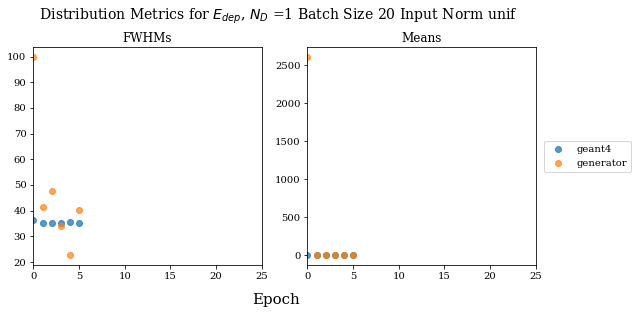

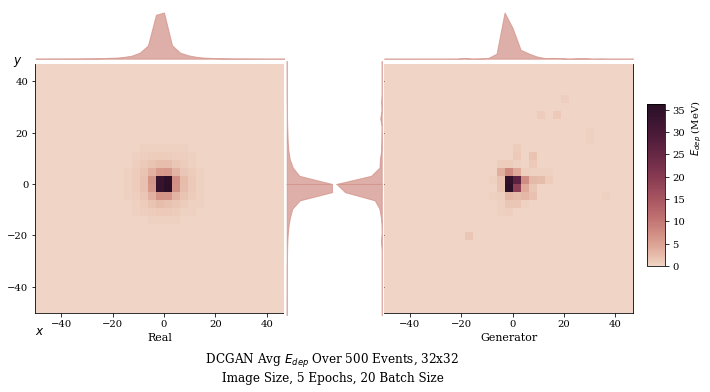

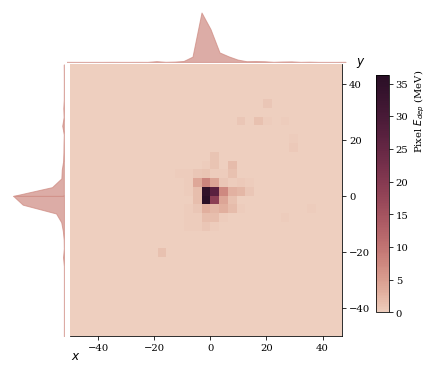

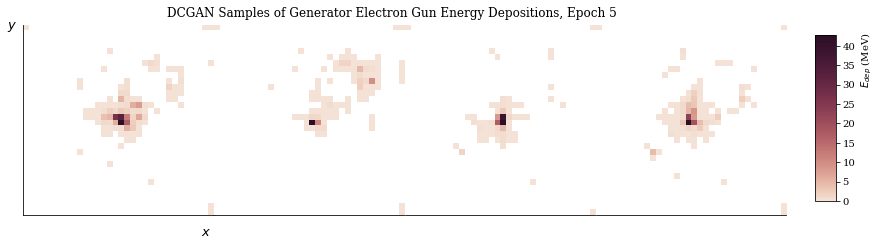

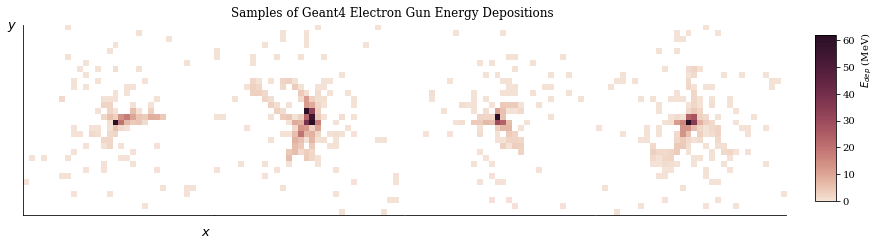

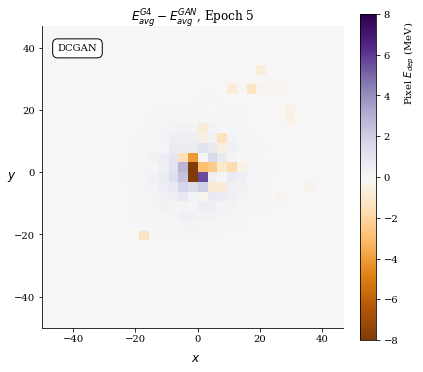

[5/50][0/1500] Loss_D: 0.0920 Loss_G: 5.1389 D(x): 0.9460 D(G(z)): 0.0197 / 0.0096
[5/50][100/1500] Loss_D: 3.2544 Loss_G: 17.9535 D(x): 0.1227 D(G(z)): 0.0000 / 0.0000
[5/50][200/1500] Loss_D: 0.6941 Loss_G: 4.0612 D(x): 0.7665 D(G(z)): 0.0056 / 0.0189
[5/50][300/1500] Loss_D: 0.2852 Loss_G: 4.6960 D(x): 0.9283 D(G(z)): 0.1569 / 0.0133
[5/50][400/1500] Loss_D: 0.0478 Loss_G: 4.7421 D(x): 0.9813 D(G(z)): 0.0152 / 0.0138
[5/50][500/1500] Loss_D: 0.4284 Loss_G: 2.9280 D(x): 0.7231 D(G(z)): 0.0306 / 0.0671
[5/50][600/1500] Loss_D: 0.2363 Loss_G: 4.2558 D(x): 0.9515 D(G(z)): 0.1507 / 0.0179
[5/50][700/1500] Loss_D: 0.1398 Loss_G: 5.2509 D(x): 0.9631 D(G(z)): 0.0831 / 0.0088
[5/50][800/1500] Loss_D: 0.6101 Loss_G: 4.3529 D(x): 0.7161 D(G(z)): 0.0022 / 0.0187
[5/50][900/1500] Loss_D: 0.0559 Loss_G: 4.5642 D(x): 0.9794 D(G(z)): 0.0230 / 0.0175
[5/50][1000/1500] Loss_D: 0.0644 Loss_G: 4.9599 D(x): 0.9739 D(G(z)): 0.0261 / 0.0095
[5/50][1100/1500] Loss_D: 0.0673 Loss_G: 4.6677 D(x): 0.9886 D(G(

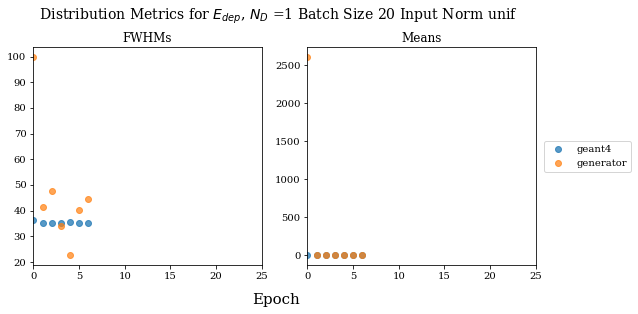

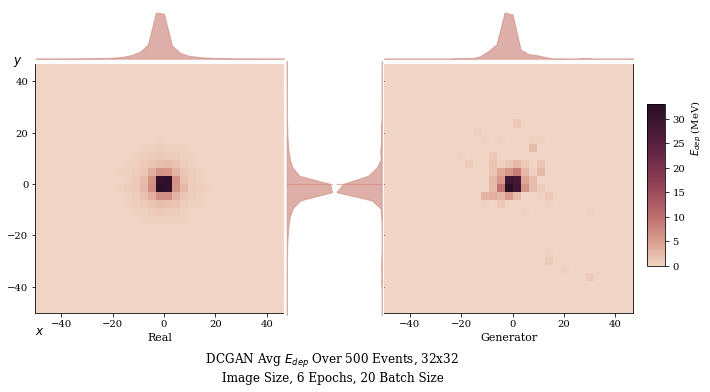

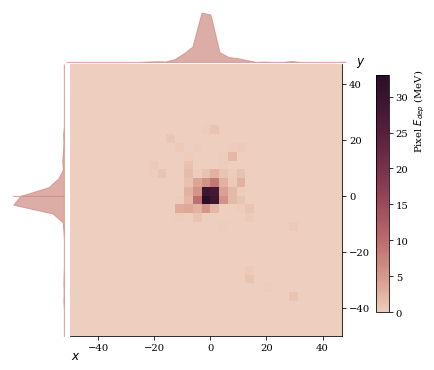

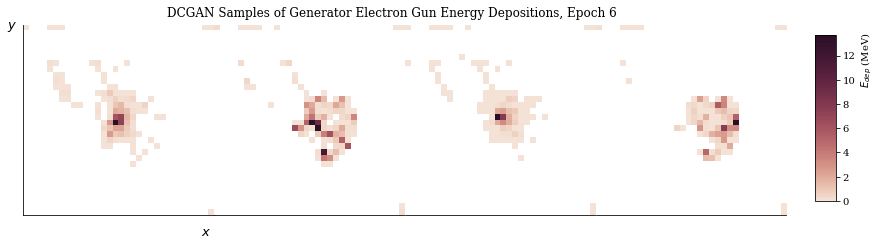

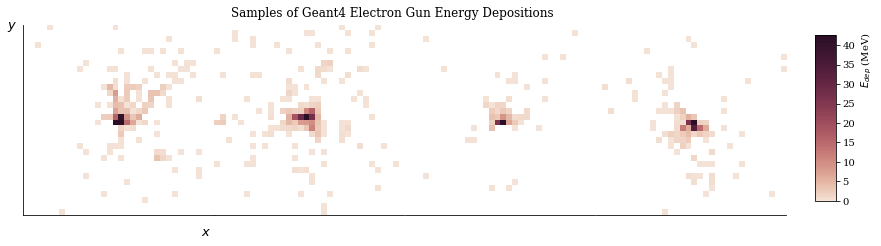

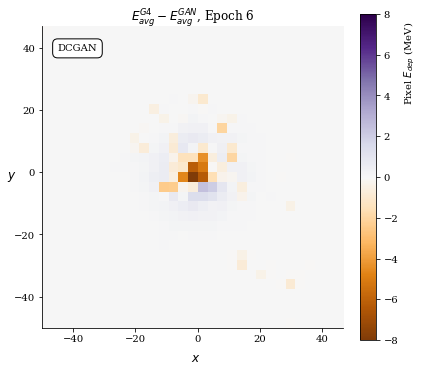

[6/50][0/1500] Loss_D: 0.0831 Loss_G: 4.8478 D(x): 0.9534 D(G(z)): 0.0187 / 0.0131
[6/50][100/1500] Loss_D: 0.0593 Loss_G: 4.2753 D(x): 0.9863 D(G(z)): 0.0321 / 0.0266
[6/50][200/1500] Loss_D: 0.1104 Loss_G: 4.8368 D(x): 0.9890 D(G(z)): 0.0772 / 0.0161
[6/50][300/1500] Loss_D: 0.2236 Loss_G: 3.4160 D(x): 0.9046 D(G(z)): 0.0635 / 0.0561
[6/50][400/1500] Loss_D: 0.0776 Loss_G: 7.6238 D(x): 0.9950 D(G(z)): 0.0532 / 0.0038
[6/50][500/1500] Loss_D: 0.0526 Loss_G: 4.5907 D(x): 0.9822 D(G(z)): 0.0232 / 0.0176
[6/50][600/1500] Loss_D: 0.0279 Loss_G: 4.8818 D(x): 0.9987 D(G(z)): 0.0129 / 0.0090
[6/50][700/1500] Loss_D: 0.0500 Loss_G: 4.6092 D(x): 0.9986 D(G(z)): 0.0332 / 0.0114
[6/50][800/1500] Loss_D: 0.1196 Loss_G: 4.7229 D(x): 0.9260 D(G(z)): 0.0146 / 0.0190
[6/50][900/1500] Loss_D: 0.2028 Loss_G: 7.2464 D(x): 0.9986 D(G(z)): 0.1443 / 0.0011
[6/50][1000/1500] Loss_D: 0.1600 Loss_G: 5.5172 D(x): 0.9950 D(G(z)): 0.1267 / 0.0056
[6/50][1100/1500] Loss_D: 0.3993 Loss_G: 2.5809 D(x): 0.7964 D(G(z

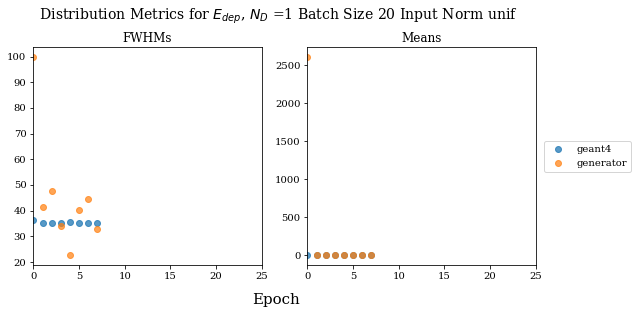

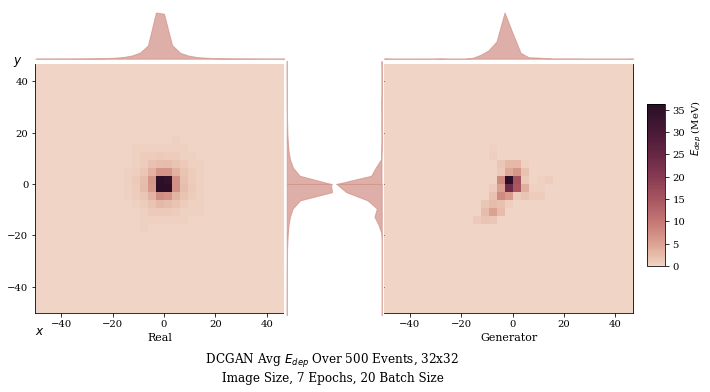

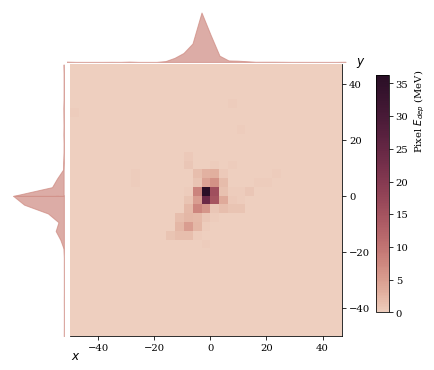

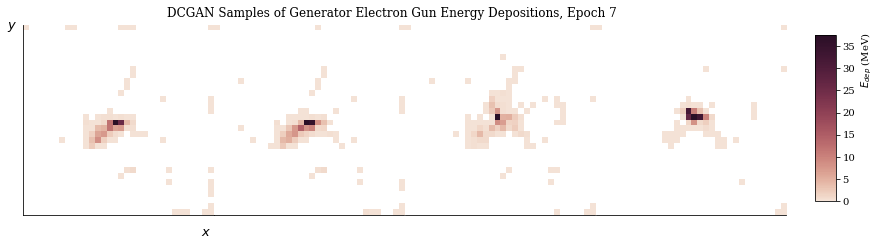

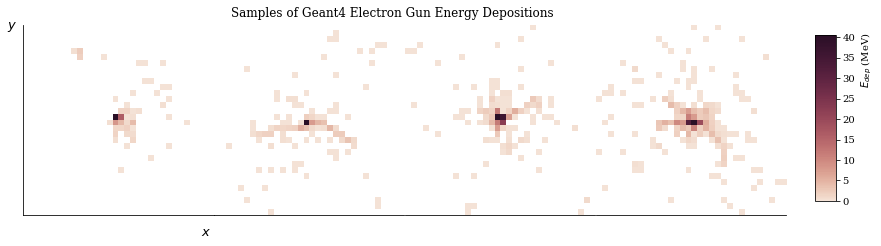

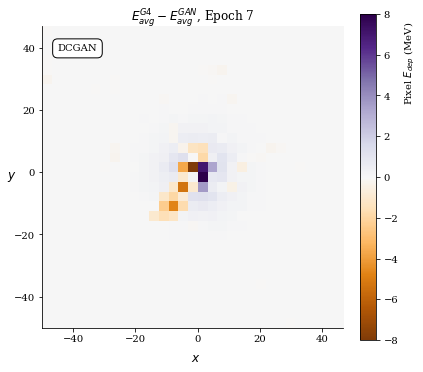

[7/50][0/1500] Loss_D: 0.0374 Loss_G: 11.1919 D(x): 0.9773 D(G(z)): 0.0010 / 0.0000
[7/50][100/1500] Loss_D: 0.0575 Loss_G: 6.8037 D(x): 0.9738 D(G(z)): 0.0187 / 0.0024
[7/50][200/1500] Loss_D: 0.1040 Loss_G: 4.5540 D(x): 0.9944 D(G(z)): 0.0807 / 0.0157
[7/50][300/1500] Loss_D: 0.2861 Loss_G: 3.0926 D(x): 0.8436 D(G(z)): 0.0212 / 0.1300
[7/50][400/1500] Loss_D: 0.0444 Loss_G: 4.1907 D(x): 0.9975 D(G(z)): 0.0286 / 0.0167
[7/50][500/1500] Loss_D: 0.0674 Loss_G: 4.5704 D(x): 0.9837 D(G(z)): 0.0398 / 0.0121
[7/50][600/1500] Loss_D: 0.0283 Loss_G: 6.2570 D(x): 0.9912 D(G(z)): 0.0071 / 0.0023
[7/50][700/1500] Loss_D: 0.2273 Loss_G: 5.4714 D(x): 0.9096 D(G(z)): 0.0918 / 0.0100
[7/50][800/1500] Loss_D: 0.0531 Loss_G: 5.3387 D(x): 0.9760 D(G(z)): 0.0159 / 0.0139
[7/50][900/1500] Loss_D: 0.0887 Loss_G: 5.1160 D(x): 0.9959 D(G(z)): 0.0662 / 0.0098
[7/50][1000/1500] Loss_D: 0.0672 Loss_G: 5.2202 D(x): 0.9796 D(G(z)): 0.0309 / 0.0156
[7/50][1100/1500] Loss_D: 0.0518 Loss_G: 5.0096 D(x): 0.9912 D(G(

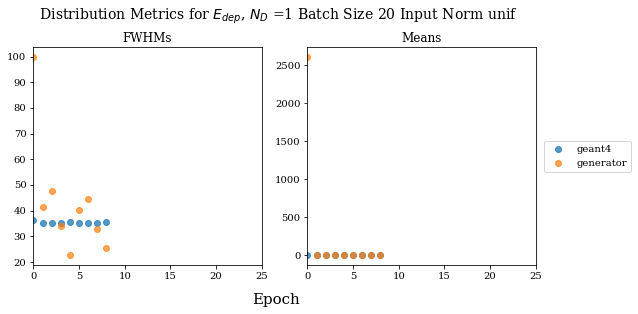

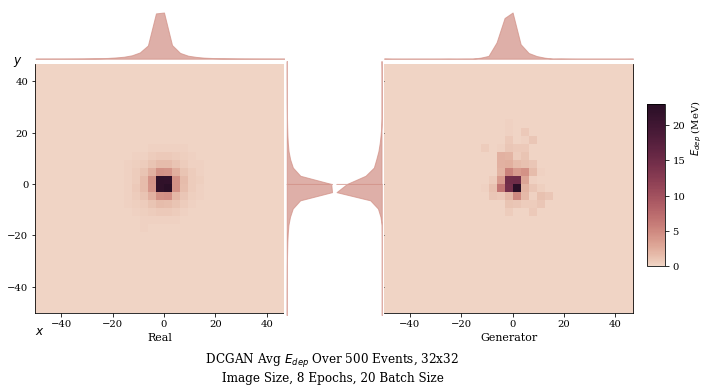

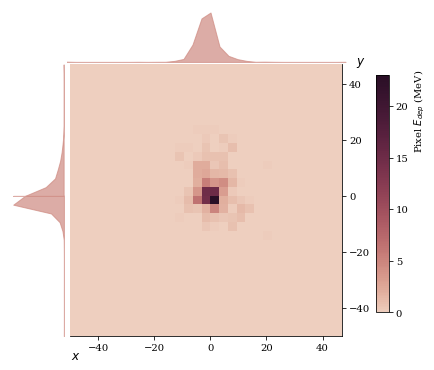

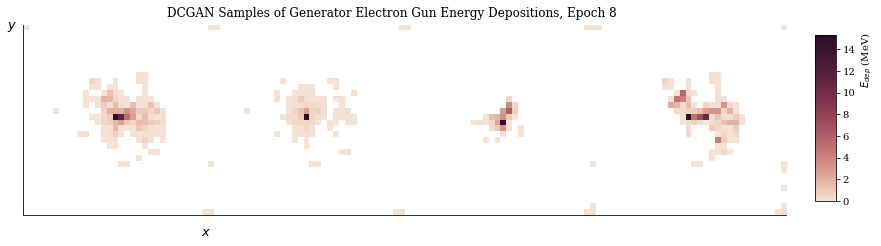

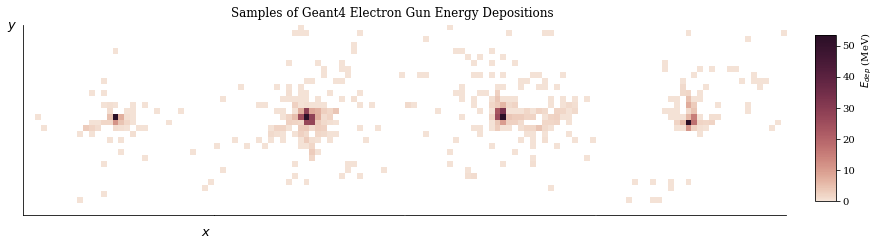

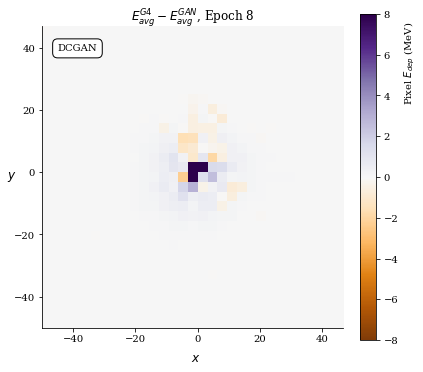

[8/50][0/1500] Loss_D: 0.1462 Loss_G: 4.3396 D(x): 0.9215 D(G(z)): 0.0124 / 0.0161
[8/50][100/1500] Loss_D: 0.1327 Loss_G: 3.7906 D(x): 0.9312 D(G(z)): 0.0480 / 0.0265
[8/50][200/1500] Loss_D: 0.0851 Loss_G: 5.9159 D(x): 0.9380 D(G(z)): 0.0028 / 0.0044
[8/50][300/1500] Loss_D: 0.0516 Loss_G: 5.3905 D(x): 0.9663 D(G(z)): 0.0044 / 0.0082
[8/50][400/1500] Loss_D: 0.0723 Loss_G: 5.1936 D(x): 0.9845 D(G(z)): 0.0446 / 0.0136
[8/50][500/1500] Loss_D: 0.2393 Loss_G: 4.1470 D(x): 0.8934 D(G(z)): 0.0856 / 0.0240
[8/50][600/1500] Loss_D: 0.1213 Loss_G: 4.3999 D(x): 0.9472 D(G(z)): 0.0534 / 0.0180
[8/50][700/1500] Loss_D: 0.1820 Loss_G: 3.0530 D(x): 0.8942 D(G(z)): 0.0267 / 0.0551
[8/50][800/1500] Loss_D: 0.0797 Loss_G: 4.6982 D(x): 0.9802 D(G(z)): 0.0461 / 0.0153
[8/50][900/1500] Loss_D: 0.0947 Loss_G: 5.1998 D(x): 0.9985 D(G(z)): 0.0731 / 0.0068
[8/50][1000/1500] Loss_D: 0.0375 Loss_G: 5.2382 D(x): 0.9882 D(G(z)): 0.0119 / 0.0066
[8/50][1100/1500] Loss_D: 0.5245 Loss_G: 1.3292 D(x): 0.7614 D(G(z

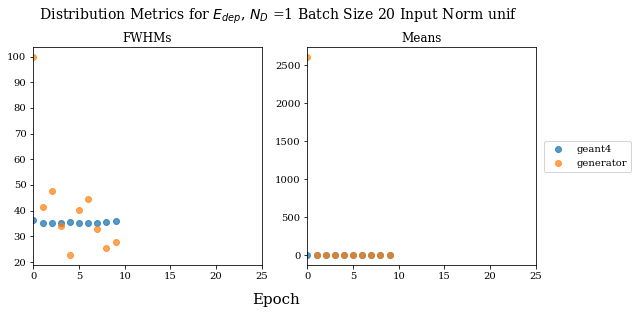

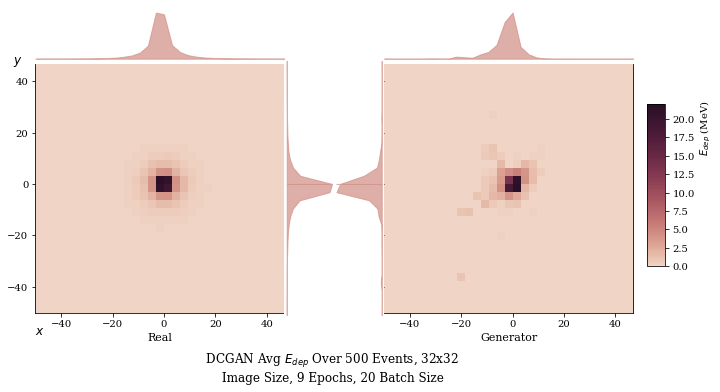

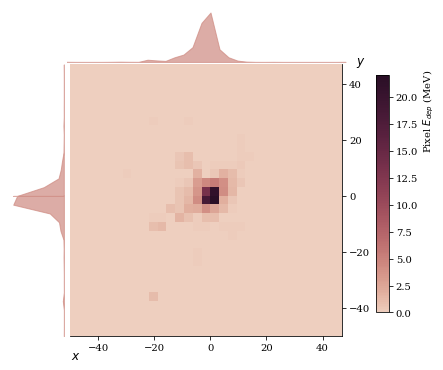

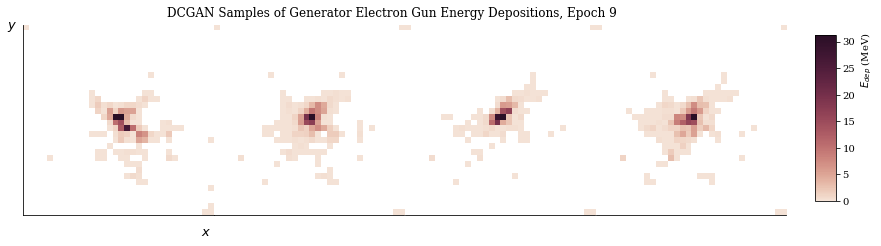

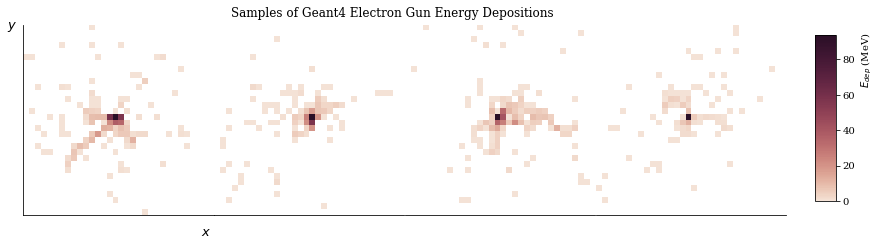

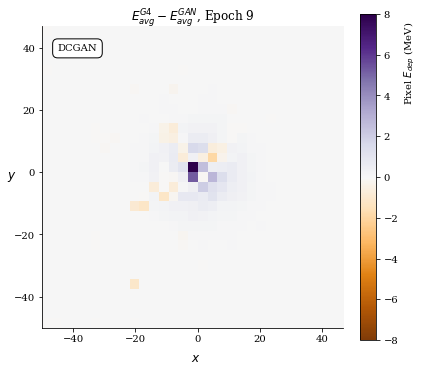

[9/50][0/1500] Loss_D: 0.1404 Loss_G: 6.4201 D(x): 0.9528 D(G(z)): 0.0735 / 0.0048
[9/50][100/1500] Loss_D: 0.5884 Loss_G: 12.1085 D(x): 0.9195 D(G(z)): 0.3361 / 0.0001
[9/50][200/1500] Loss_D: 0.1471 Loss_G: 4.0357 D(x): 0.9286 D(G(z)): 0.0156 / 0.0219
[9/50][300/1500] Loss_D: 0.1316 Loss_G: 3.7386 D(x): 0.9692 D(G(z)): 0.0865 / 0.0278
[9/50][400/1500] Loss_D: 0.6649 Loss_G: 6.2153 D(x): 0.9351 D(G(z)): 0.2249 / 0.0054
[9/50][500/1500] Loss_D: 0.7940 Loss_G: 1.0925 D(x): 0.6024 D(G(z)): 0.0191 / 0.4177
[9/50][600/1500] Loss_D: 0.0574 Loss_G: 4.1329 D(x): 0.9885 D(G(z)): 0.0326 / 0.0202
[9/50][700/1500] Loss_D: 0.1040 Loss_G: 3.7145 D(x): 0.9604 D(G(z)): 0.0449 / 0.0369
[9/50][800/1500] Loss_D: 0.1130 Loss_G: 7.5731 D(x): 0.9684 D(G(z)): 0.0580 / 0.0033
[9/50][900/1500] Loss_D: 0.1521 Loss_G: 6.9042 D(x): 0.9918 D(G(z)): 0.1128 / 0.0016
[9/50][1000/1500] Loss_D: 0.1149 Loss_G: 3.2887 D(x): 0.9644 D(G(z)): 0.0497 / 0.0804
[9/50][1100/1500] Loss_D: 0.5044 Loss_G: 3.5973 D(x): 0.7223 D(G(

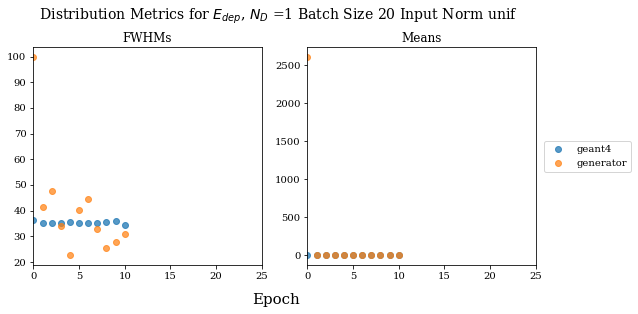

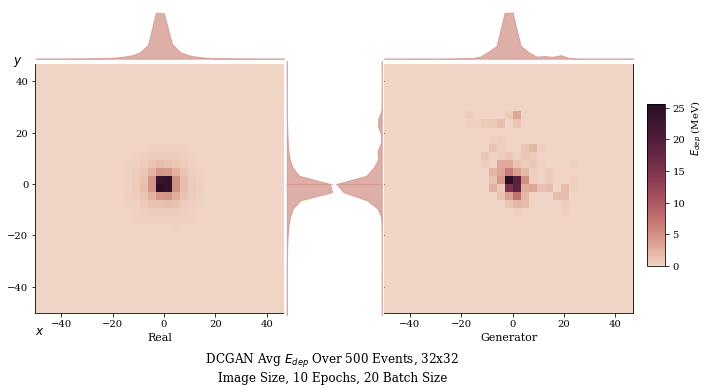

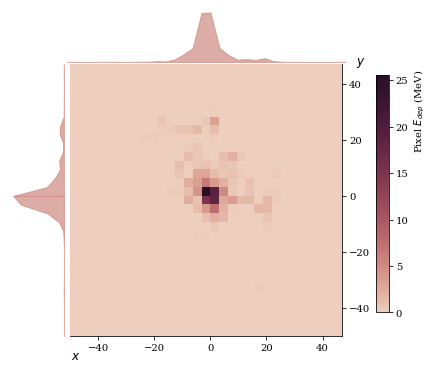

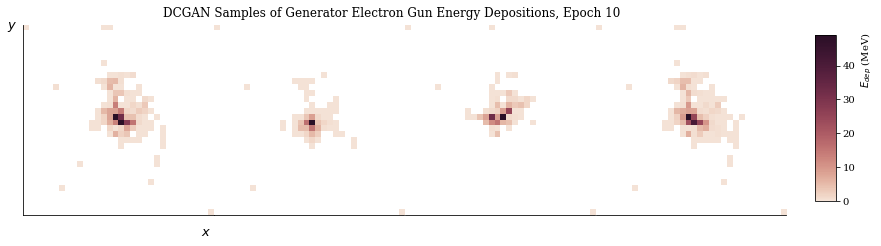

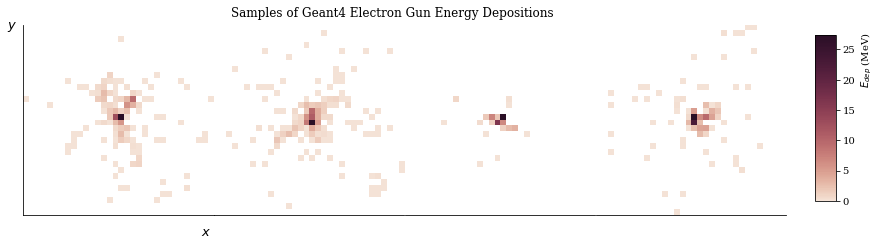

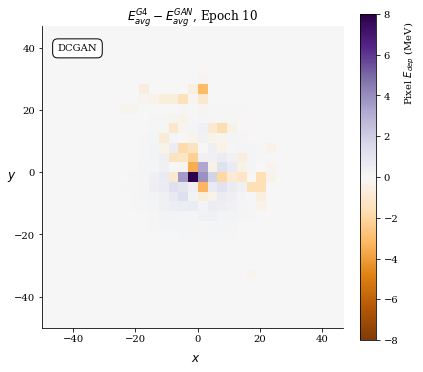

[10/50][0/1500] Loss_D: 0.0578 Loss_G: 5.6039 D(x): 0.9617 D(G(z)): 0.0026 / 0.0043
[10/50][100/1500] Loss_D: 0.2878 Loss_G: 6.3528 D(x): 0.9293 D(G(z)): 0.0015 / 0.0022
[10/50][200/1500] Loss_D: 0.1902 Loss_G: 6.4112 D(x): 0.9514 D(G(z)): 0.0973 / 0.0043
[10/50][300/1500] Loss_D: 0.0518 Loss_G: 4.2639 D(x): 0.9858 D(G(z)): 0.0254 / 0.0167
[10/50][400/1500] Loss_D: 0.1428 Loss_G: 3.7968 D(x): 0.9973 D(G(z)): 0.1204 / 0.0247
[10/50][500/1500] Loss_D: 0.1076 Loss_G: 7.1417 D(x): 0.9266 D(G(z)): 0.0070 / 0.0011
[10/50][600/1500] Loss_D: 0.0491 Loss_G: 5.5990 D(x): 0.9987 D(G(z)): 0.0336 / 0.0063
[10/50][700/1500] Loss_D: 0.0648 Loss_G: 4.3185 D(x): 0.9757 D(G(z)): 0.0280 / 0.0163
[10/50][800/1500] Loss_D: 0.4821 Loss_G: 4.0625 D(x): 0.8628 D(G(z)): 0.0129 / 0.0545
[10/50][900/1500] Loss_D: 0.0309 Loss_G: 4.9818 D(x): 0.9946 D(G(z)): 0.0138 / 0.0081
[10/50][1000/1500] Loss_D: 0.0480 Loss_G: 4.2208 D(x): 0.9922 D(G(z)): 0.0289 / 0.0182
[10/50][1100/1500] Loss_D: 0.4150 Loss_G: 2.5886 D(x): 

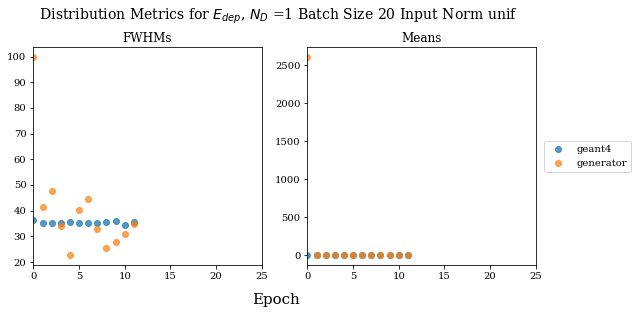

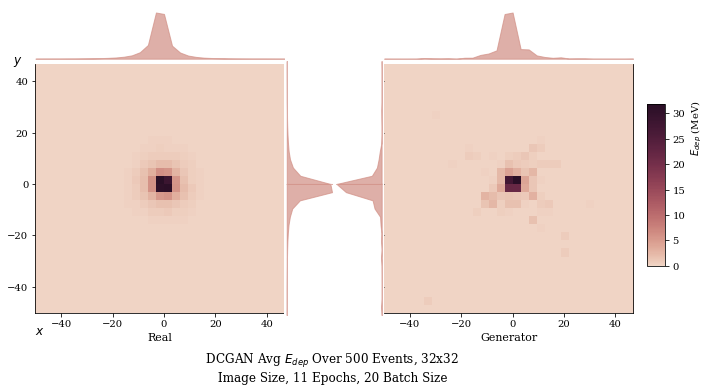

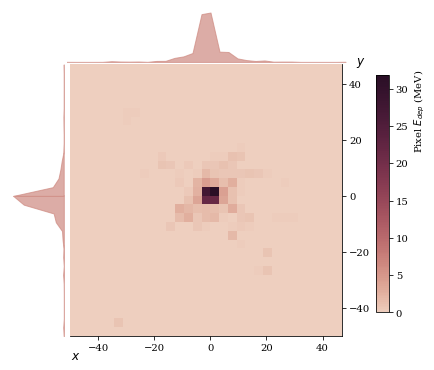

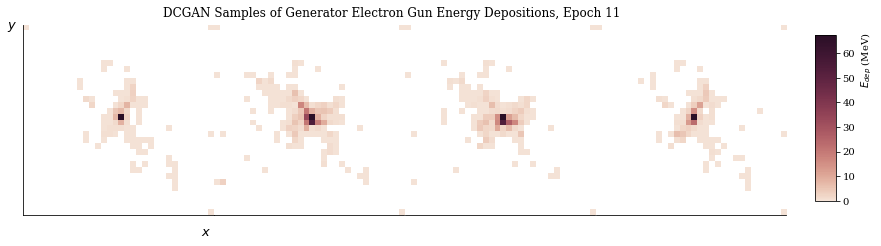

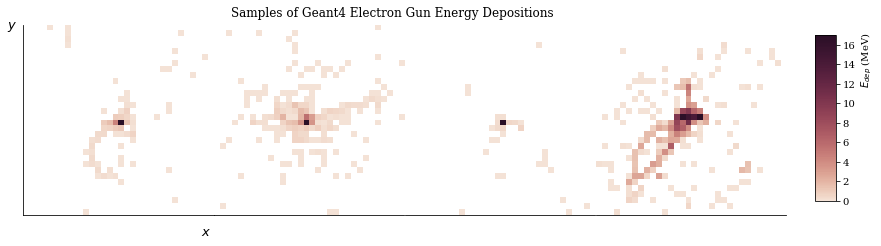

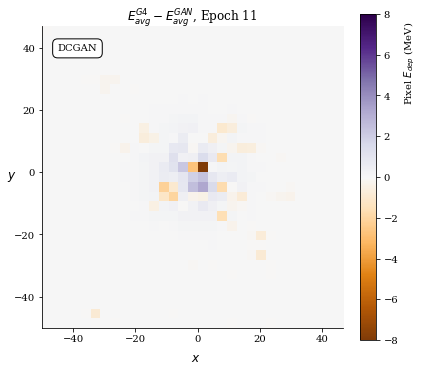

[11/50][0/1500] Loss_D: 0.0687 Loss_G: 7.7139 D(x): 0.9510 D(G(z)): 0.0025 / 0.0006
[11/50][100/1500] Loss_D: 0.0657 Loss_G: 3.8504 D(x): 0.9948 D(G(z)): 0.0480 / 0.0274
[11/50][200/1500] Loss_D: 0.0930 Loss_G: 4.4025 D(x): 0.9545 D(G(z)): 0.0307 / 0.0175
[11/50][300/1500] Loss_D: 0.5011 Loss_G: 1.9489 D(x): 0.6953 D(G(z)): 0.0345 / 0.2280
[11/50][400/1500] Loss_D: 0.0643 Loss_G: 4.7814 D(x): 0.9961 D(G(z)): 0.0451 / 0.0156
[11/50][500/1500] Loss_D: 0.0892 Loss_G: 5.9923 D(x): 0.9383 D(G(z)): 0.0040 / 0.0049
[11/50][600/1500] Loss_D: 0.8031 Loss_G: 11.6685 D(x): 0.9994 D(G(z)): 0.5168 / 0.0000
[11/50][700/1500] Loss_D: 0.1626 Loss_G: 5.7634 D(x): 0.9946 D(G(z)): 0.1317 / 0.0048
[11/50][800/1500] Loss_D: 0.1720 Loss_G: 4.4569 D(x): 0.9268 D(G(z)): 0.0491 / 0.0313
[11/50][900/1500] Loss_D: 0.2456 Loss_G: 6.6700 D(x): 0.9925 D(G(z)): 0.1767 / 0.0026
[11/50][1000/1500] Loss_D: 0.3536 Loss_G: 9.3473 D(x): 0.9925 D(G(z)): 0.2753 / 0.0001
[11/50][1100/1500] Loss_D: 0.3281 Loss_G: 3.0838 D(x):

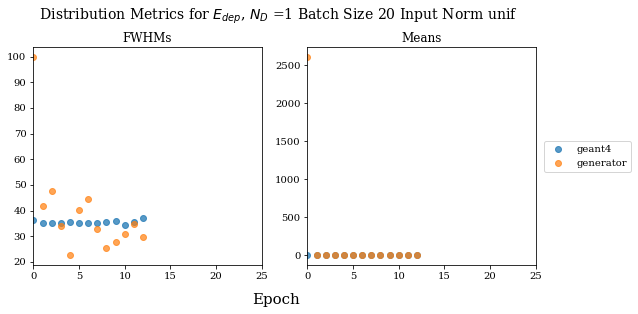

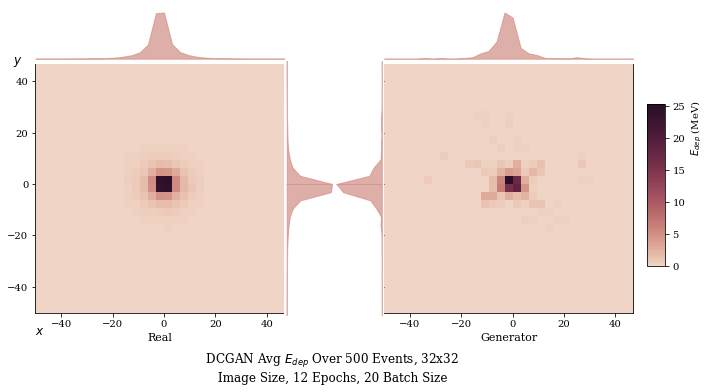

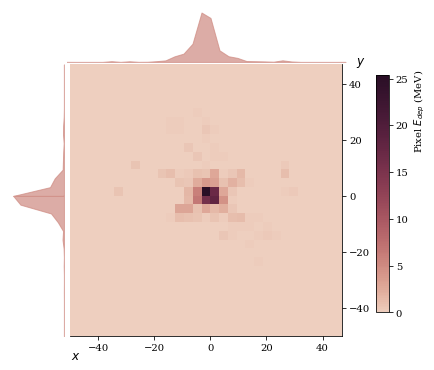

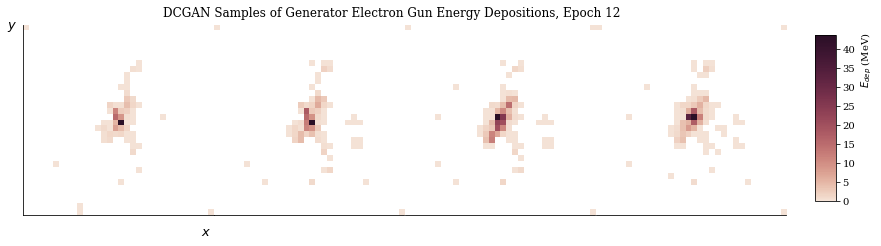

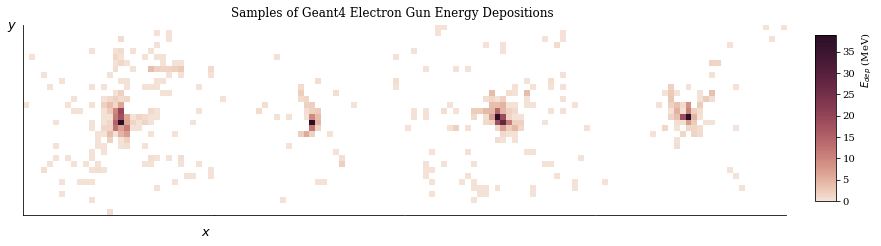

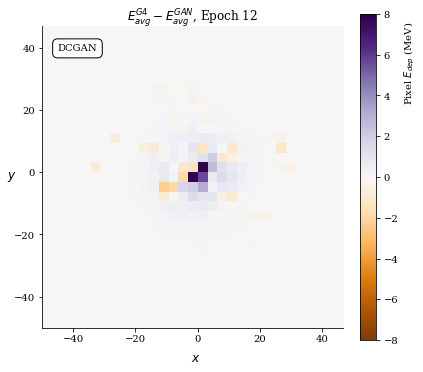

[12/50][0/1500] Loss_D: 0.0575 Loss_G: 6.3660 D(x): 0.9674 D(G(z)): 0.0097 / 0.0029
[12/50][100/1500] Loss_D: 0.0734 Loss_G: 7.5883 D(x): 0.9472 D(G(z)): 0.0012 / 0.0024
[12/50][200/1500] Loss_D: 1.1745 Loss_G: 8.3746 D(x): 0.5145 D(G(z)): 0.0000 / 0.0010
[12/50][300/1500] Loss_D: 0.1156 Loss_G: 4.7990 D(x): 0.9717 D(G(z)): 0.0719 / 0.0110
[12/50][400/1500] Loss_D: 0.1679 Loss_G: 5.0345 D(x): 0.9994 D(G(z)): 0.1332 / 0.0137
[12/50][500/1500] Loss_D: 0.0530 Loss_G: 4.8288 D(x): 0.9948 D(G(z)): 0.0355 / 0.0103
[12/50][600/1500] Loss_D: 0.0226 Loss_G: 5.6292 D(x): 0.9978 D(G(z)): 0.0065 / 0.0058
[12/50][700/1500] Loss_D: 0.0499 Loss_G: 3.9809 D(x): 0.9722 D(G(z)): 0.0082 / 0.0433
[12/50][800/1500] Loss_D: 0.2545 Loss_G: 2.7596 D(x): 0.8371 D(G(z)): 0.0106 / 0.0859
[12/50][900/1500] Loss_D: 0.0497 Loss_G: 5.5758 D(x): 0.9992 D(G(z)): 0.0304 / 0.0086
[12/50][1000/1500] Loss_D: 0.0399 Loss_G: 5.0485 D(x): 0.9822 D(G(z)): 0.0091 / 0.0078
[12/50][1100/1500] Loss_D: 0.0906 Loss_G: 6.2170 D(x): 

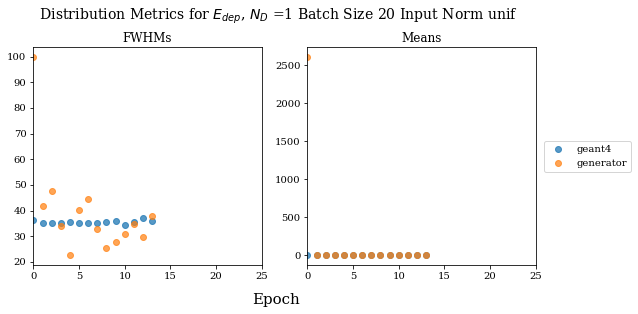

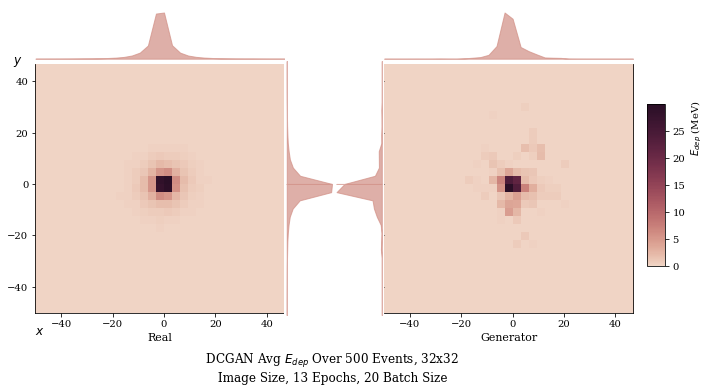

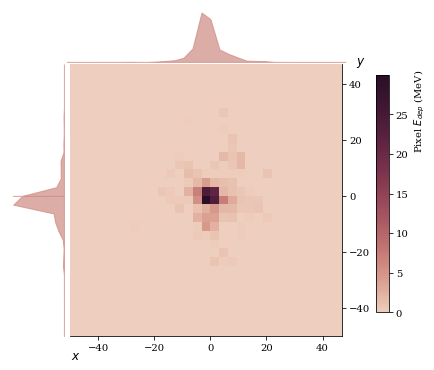

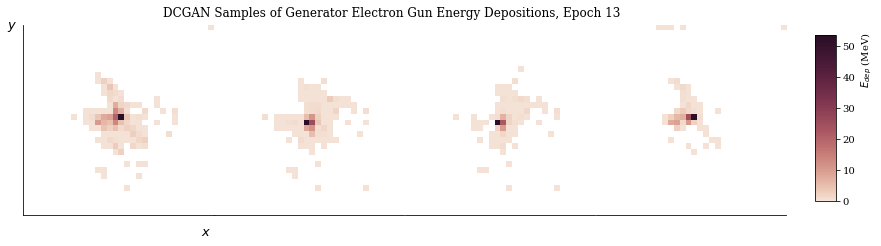

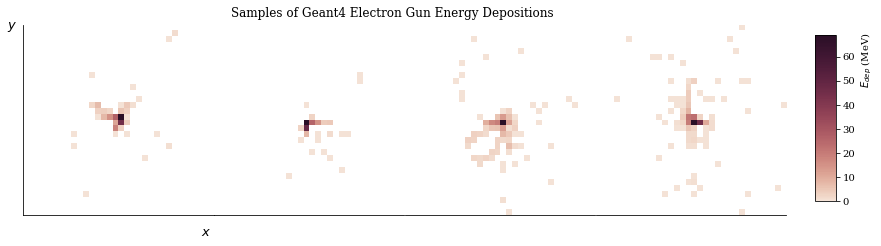

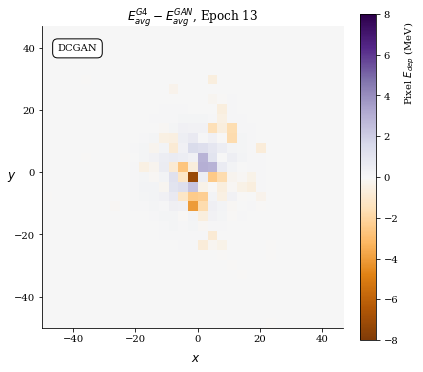

[13/50][0/1500] Loss_D: 0.0623 Loss_G: 6.7722 D(x): 0.9655 D(G(z)): 0.0037 / 0.0019
[13/50][100/1500] Loss_D: 0.0777 Loss_G: 7.2858 D(x): 0.9414 D(G(z)): 0.0007 / 0.0019
[13/50][200/1500] Loss_D: 0.2221 Loss_G: 5.2377 D(x): 0.9428 D(G(z)): 0.0533 / 0.0155
[13/50][300/1500] Loss_D: 0.0471 Loss_G: 5.9557 D(x): 0.9737 D(G(z)): 0.0091 / 0.0040
[13/50][400/1500] Loss_D: 0.2902 Loss_G: 5.6259 D(x): 0.9993 D(G(z)): 0.2373 / 0.0041
[13/50][500/1500] Loss_D: 0.3477 Loss_G: 2.5512 D(x): 0.8333 D(G(z)): 0.0578 / 0.0982
[13/50][600/1500] Loss_D: 0.0569 Loss_G: 4.6243 D(x): 0.9989 D(G(z)): 0.0420 / 0.0125
[13/50][700/1500] Loss_D: 0.0607 Loss_G: 4.3063 D(x): 0.9793 D(G(z)): 0.0225 / 0.2030
[13/50][800/1500] Loss_D: 0.0884 Loss_G: 4.6122 D(x): 0.9510 D(G(z)): 0.0191 / 0.0142
[13/50][900/1500] Loss_D: 0.0476 Loss_G: 4.8692 D(x): 0.9972 D(G(z)): 0.0279 / 0.0133
[13/50][1000/1500] Loss_D: 0.1112 Loss_G: 5.2445 D(x): 0.9989 D(G(z)): 0.0853 / 0.0100
[13/50][1100/1500] Loss_D: 0.1089 Loss_G: 5.6327 D(x): 

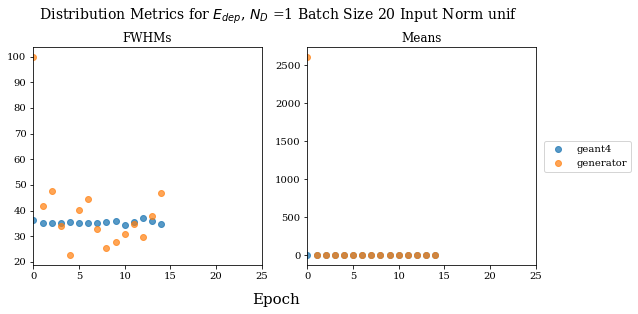

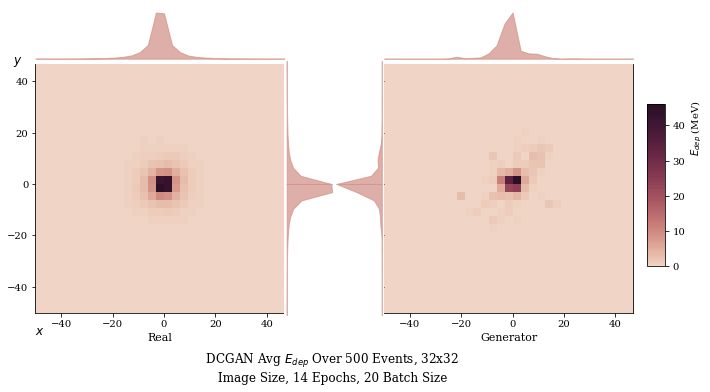

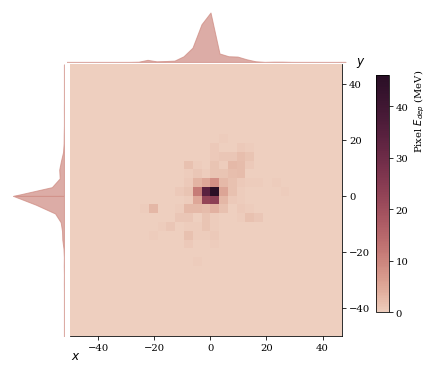

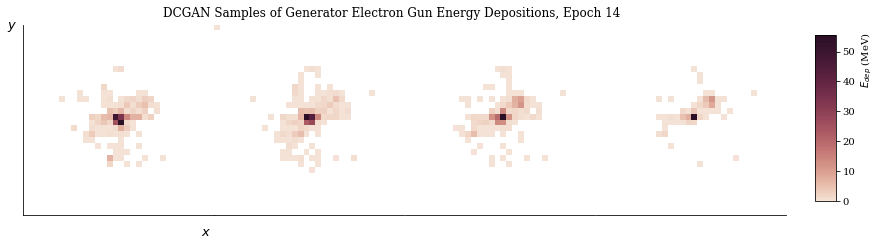

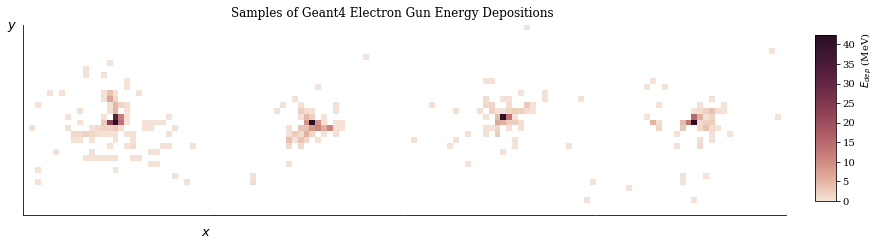

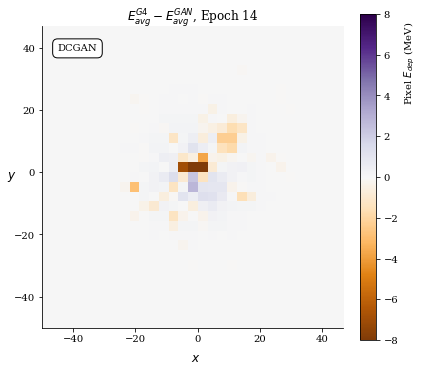

[14/50][0/1500] Loss_D: 0.3954 Loss_G: 3.1713 D(x): 0.7503 D(G(z)): 0.0349 / 0.0660
[14/50][100/1500] Loss_D: 0.0563 Loss_G: 4.9889 D(x): 0.9716 D(G(z)): 0.0101 / 0.0084
[14/50][200/1500] Loss_D: 0.0261 Loss_G: 5.2618 D(x): 0.9980 D(G(z)): 0.0096 / 0.0063
[14/50][300/1500] Loss_D: 0.0564 Loss_G: 4.7483 D(x): 0.9831 D(G(z)): 0.0271 / 0.0148
[14/50][400/1500] Loss_D: 0.5160 Loss_G: 8.1759 D(x): 1.0000 D(G(z)): 0.3758 / 0.0004
[14/50][500/1500] Loss_D: 0.0475 Loss_G: 4.5497 D(x): 0.9836 D(G(z)): 0.0170 / 0.0130
[14/50][600/1500] Loss_D: 0.1562 Loss_G: 6.9775 D(x): 0.9991 D(G(z)): 0.1277 / 0.0021
[14/50][700/1500] Loss_D: 0.0818 Loss_G: 6.2602 D(x): 0.9464 D(G(z)): 0.0076 / 0.0221
[14/50][800/1500] Loss_D: 0.3171 Loss_G: 8.1450 D(x): 0.9951 D(G(z)): 0.2436 / 0.0004
[14/50][900/1500] Loss_D: 0.3193 Loss_G: 9.5675 D(x): 0.9838 D(G(z)): 0.2353 / 0.0003
[14/50][1000/1500] Loss_D: 0.0518 Loss_G: 3.8932 D(x): 0.9776 D(G(z)): 0.0155 / 0.0378
[14/50][1100/1500] Loss_D: 0.6104 Loss_G: 2.6638 D(x): 

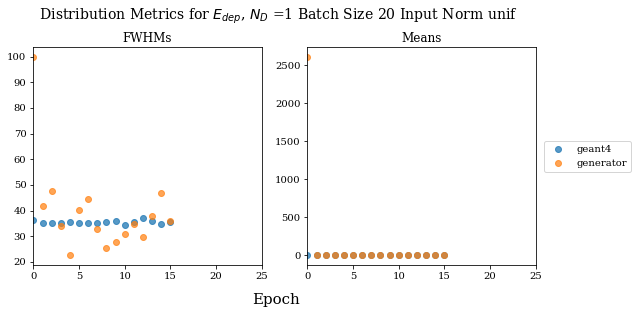

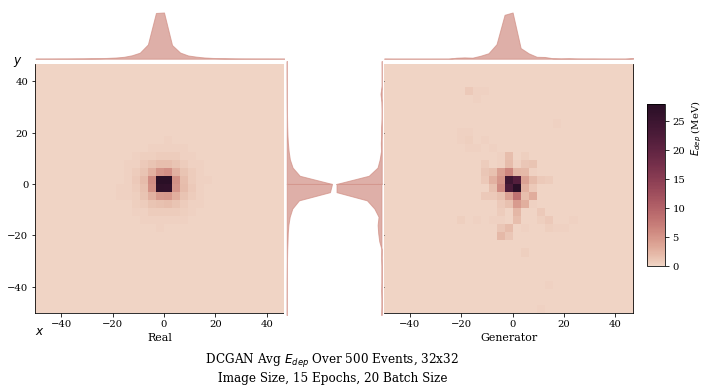

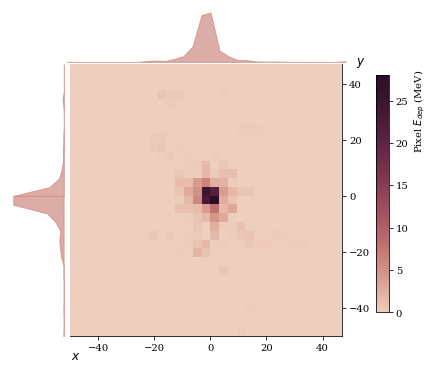

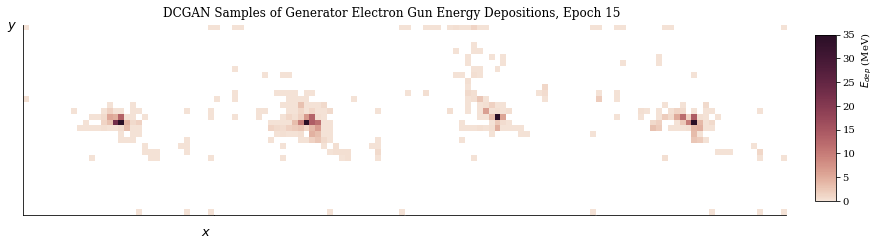

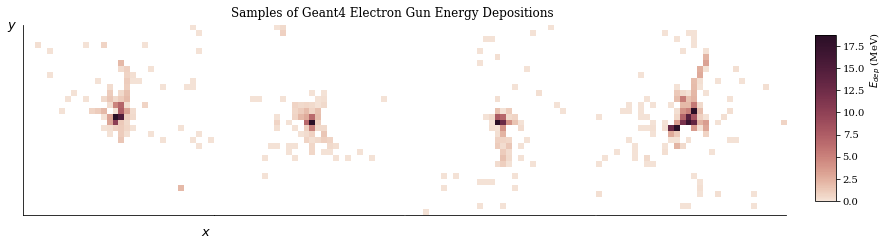

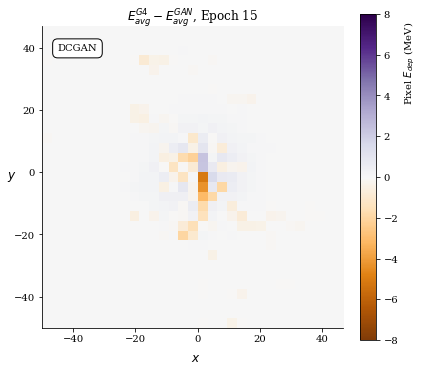

[15/50][0/1500] Loss_D: 0.1318 Loss_G: 5.7574 D(x): 0.9310 D(G(z)): 0.0107 / 0.0159
[15/50][100/1500] Loss_D: 0.0360 Loss_G: 6.0142 D(x): 0.9871 D(G(z)): 0.0105 / 0.0044
[15/50][200/1500] Loss_D: 0.0588 Loss_G: 5.7844 D(x): 0.9610 D(G(z)): 0.0026 / 0.0040
[15/50][300/1500] Loss_D: 0.1364 Loss_G: 6.0931 D(x): 0.9906 D(G(z)): 0.0990 / 0.0034
[15/50][400/1500] Loss_D: 0.4590 Loss_G: 7.5827 D(x): 0.9995 D(G(z)): 0.2849 / 0.0008
[15/50][500/1500] Loss_D: 0.0483 Loss_G: 4.0659 D(x): 0.9758 D(G(z)): 0.0073 / 0.0265
[15/50][600/1500] Loss_D: 0.0385 Loss_G: 4.7998 D(x): 0.9994 D(G(z)): 0.0221 / 0.0136
[15/50][700/1500] Loss_D: 0.0578 Loss_G: 4.5850 D(x): 0.9832 D(G(z)): 0.0277 / 0.0205
[15/50][800/1500] Loss_D: 0.1825 Loss_G: 6.8647 D(x): 0.9414 D(G(z)): 0.0844 / 0.0041
[15/50][900/1500] Loss_D: 0.0479 Loss_G: 5.0900 D(x): 0.9854 D(G(z)): 0.0172 / 0.0133
[15/50][1000/1500] Loss_D: 0.1347 Loss_G: 3.8314 D(x): 0.9610 D(G(z)): 0.0479 / 0.0289
[15/50][1100/1500] Loss_D: 0.2070 Loss_G: 5.8521 D(x): 

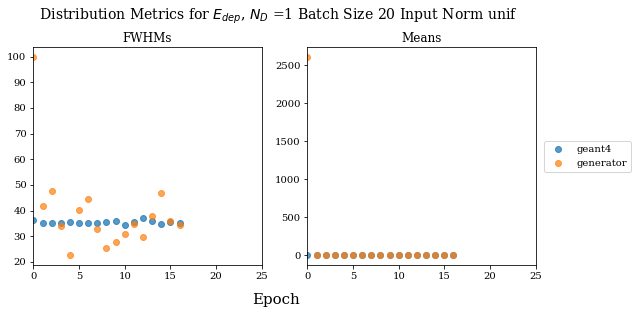

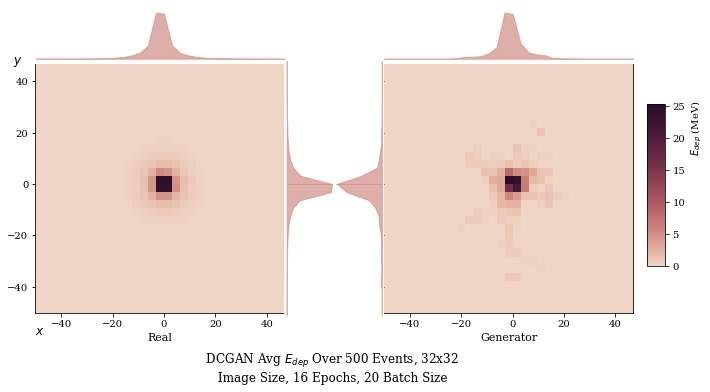

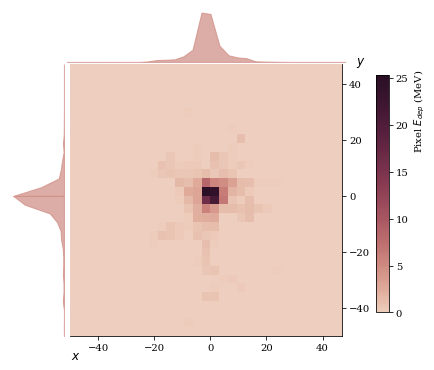

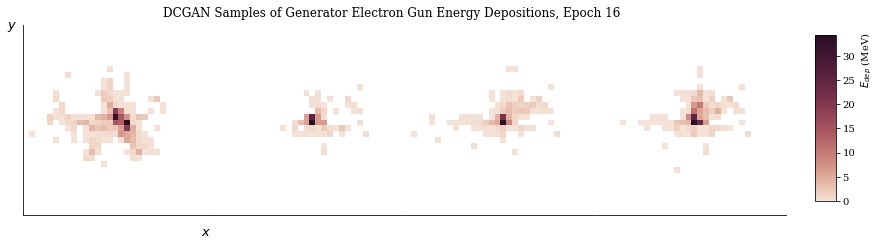

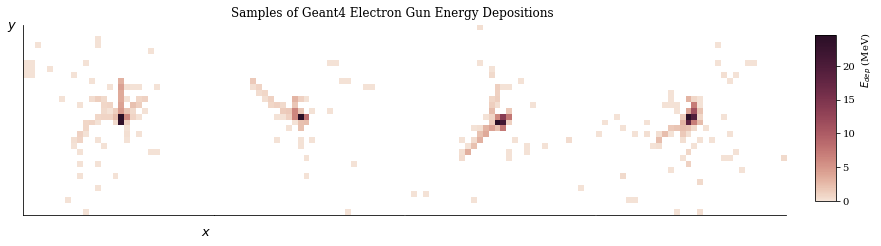

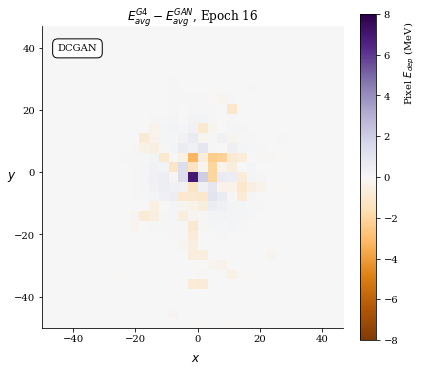

[16/50][0/1500] Loss_D: 0.1187 Loss_G: 4.9746 D(x): 0.9261 D(G(z)): 0.0088 / 0.0183
[16/50][100/1500] Loss_D: 0.0334 Loss_G: 6.4294 D(x): 0.9842 D(G(z)): 0.0042 / 0.0035
[16/50][200/1500] Loss_D: 0.0284 Loss_G: 5.9650 D(x): 0.9969 D(G(z)): 0.0082 / 0.0055
[16/50][300/1500] Loss_D: 0.2033 Loss_G: 4.3489 D(x): 0.8936 D(G(z)): 0.0208 / 0.0282
[16/50][400/1500] Loss_D: 0.0438 Loss_G: 4.0738 D(x): 0.9964 D(G(z)): 0.0279 / 0.0189
[16/50][500/1500] Loss_D: 0.0447 Loss_G: 7.2118 D(x): 0.9740 D(G(z)): 0.0069 / 0.0018
[16/50][600/1500] Loss_D: 0.1279 Loss_G: 6.0767 D(x): 0.9999 D(G(z)): 0.1000 / 0.0030
[16/50][700/1500] Loss_D: 0.0995 Loss_G: 3.9278 D(x): 0.9478 D(G(z)): 0.0322 / 0.0266
[16/50][800/1500] Loss_D: 0.5069 Loss_G: 7.6864 D(x): 0.7383 D(G(z)): 0.0004 / 0.0008
[16/50][900/1500] Loss_D: 0.0285 Loss_G: 7.5618 D(x): 0.9939 D(G(z)): 0.0045 / 0.0035
[16/50][1000/1500] Loss_D: 0.0605 Loss_G: 17.5861 D(x): 0.9676 D(G(z)): 0.0021 / 0.0023
[16/50][1100/1500] Loss_D: 0.1724 Loss_G: 2.9380 D(x):

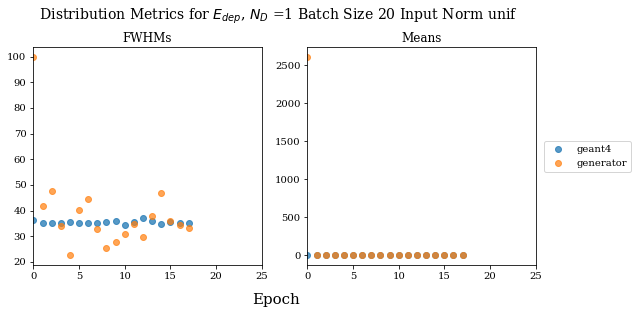

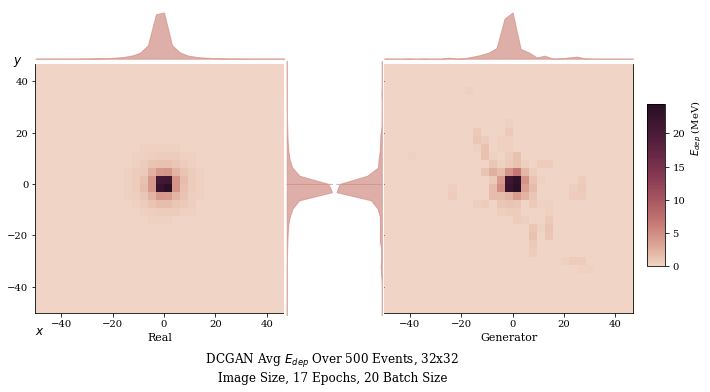

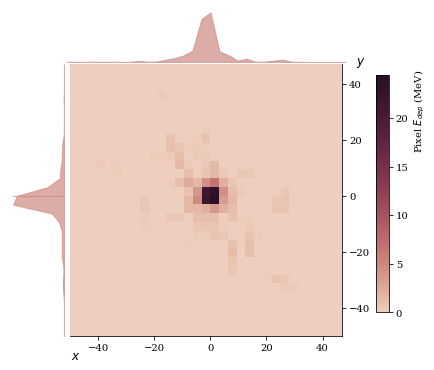

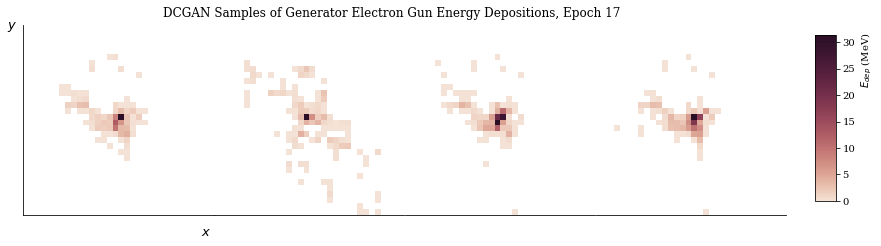

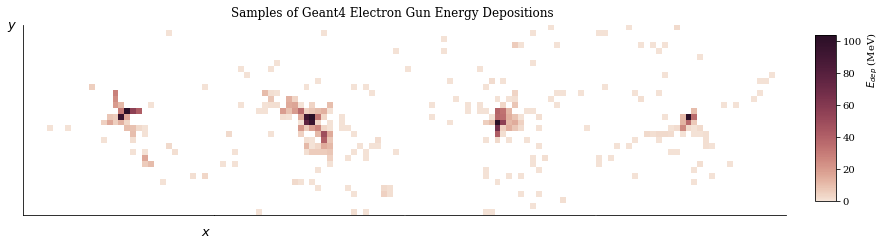

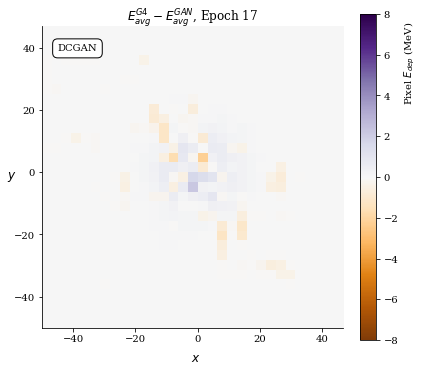

[17/50][0/1500] Loss_D: 0.0867 Loss_G: 4.3827 D(x): 0.9614 D(G(z)): 0.0347 / 0.0164
[17/50][100/1500] Loss_D: 0.3270 Loss_G: 2.3073 D(x): 0.7813 D(G(z)): 0.0206 / 0.1335
[17/50][200/1500] Loss_D: 0.2098 Loss_G: 3.7284 D(x): 0.8853 D(G(z)): 0.0586 / 0.0354
[17/50][300/1500] Loss_D: 0.3655 Loss_G: 4.8973 D(x): 0.9242 D(G(z)): 0.2221 / 0.0091
[17/50][400/1500] Loss_D: 0.6778 Loss_G: 6.8127 D(x): 0.9995 D(G(z)): 0.4246 / 0.0015
[17/50][500/1500] Loss_D: 0.0378 Loss_G: 5.3155 D(x): 0.9979 D(G(z)): 0.0236 / 0.0070
[17/50][600/1500] Loss_D: 0.2253 Loss_G: 4.6742 D(x): 0.9978 D(G(z)): 0.1850 / 0.0121
[17/50][700/1500] Loss_D: 0.1671 Loss_G: 5.1639 D(x): 0.9980 D(G(z)): 0.1346 / 0.0072
[17/50][800/1500] Loss_D: 0.0622 Loss_G: 5.0365 D(x): 0.9683 D(G(z)): 0.0180 / 0.0091
[17/50][900/1500] Loss_D: 0.0531 Loss_G: 5.2456 D(x): 0.9892 D(G(z)): 0.0282 / 0.0111
[17/50][1000/1500] Loss_D: 0.0287 Loss_G: 7.4248 D(x): 0.9961 D(G(z)): 0.0102 / 0.0016
[17/50][1100/1500] Loss_D: 0.3147 Loss_G: 8.3792 D(x): 

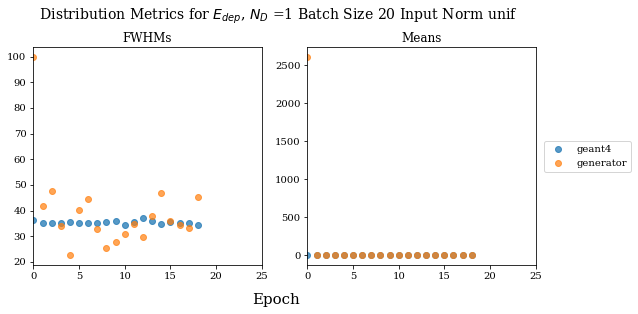

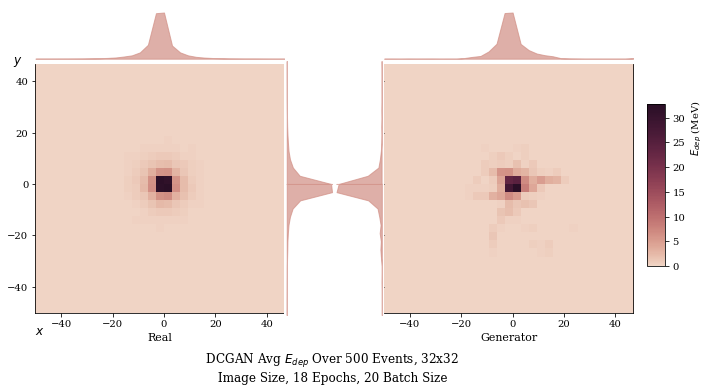

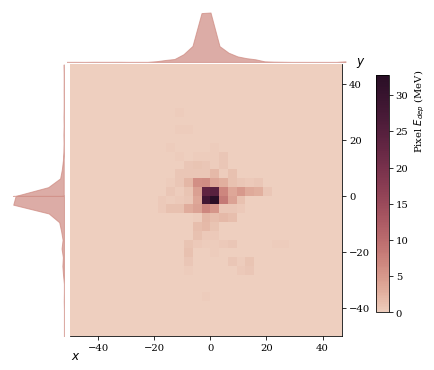

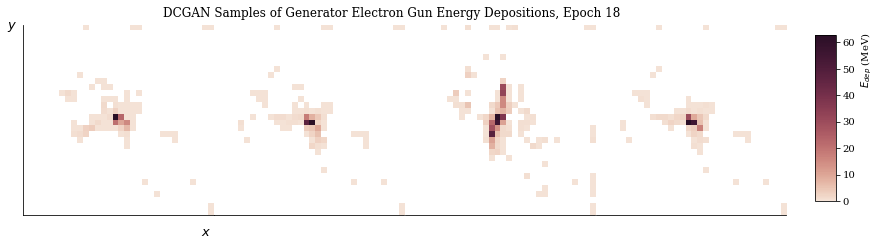

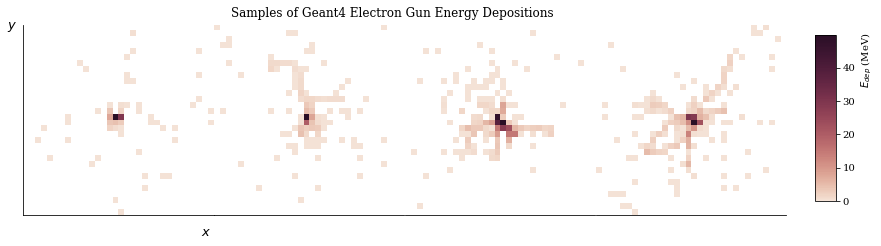

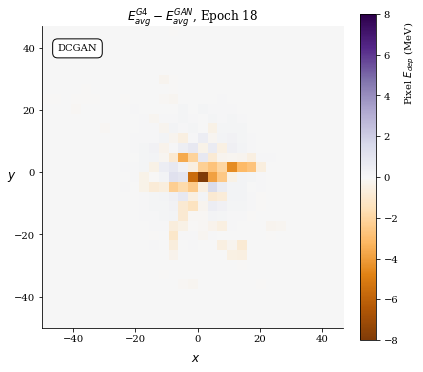

[18/50][0/1500] Loss_D: 0.2823 Loss_G: 2.2898 D(x): 0.8376 D(G(z)): 0.0318 / 0.1117
[18/50][100/1500] Loss_D: 0.3927 Loss_G: 3.9916 D(x): 0.7821 D(G(z)): 0.0027 / 0.0411
[18/50][200/1500] Loss_D: 0.0343 Loss_G: 10.5590 D(x): 0.9796 D(G(z)): 0.0014 / 0.0000
[18/50][300/1500] Loss_D: 1.1459 Loss_G: 9.5656 D(x): 0.9680 D(G(z)): 0.5187 / 0.0004
[18/50][400/1500] Loss_D: 0.1291 Loss_G: 4.3715 D(x): 0.9982 D(G(z)): 0.1069 / 0.0168
[18/50][500/1500] Loss_D: 0.4468 Loss_G: 4.7907 D(x): 0.7281 D(G(z)): 0.0020 / 0.0213
[18/50][600/1500] Loss_D: 0.0719 Loss_G: 4.2268 D(x): 0.9955 D(G(z)): 0.0533 / 0.0180
[18/50][700/1500] Loss_D: 0.5881 Loss_G: 7.7717 D(x): 0.9992 D(G(z)): 0.4163 / 0.0006
[18/50][800/1500] Loss_D: 0.0610 Loss_G: 5.2257 D(x): 0.9701 D(G(z)): 0.0162 / 0.0077
[18/50][900/1500] Loss_D: 0.1229 Loss_G: 5.5063 D(x): 0.9898 D(G(z)): 0.0914 / 0.0055
[18/50][1000/1500] Loss_D: 0.1147 Loss_G: 4.8744 D(x): 0.9235 D(G(z)): 0.0196 / 0.0090
[18/50][1100/1500] Loss_D: 0.3991 Loss_G: 2.5348 D(x):

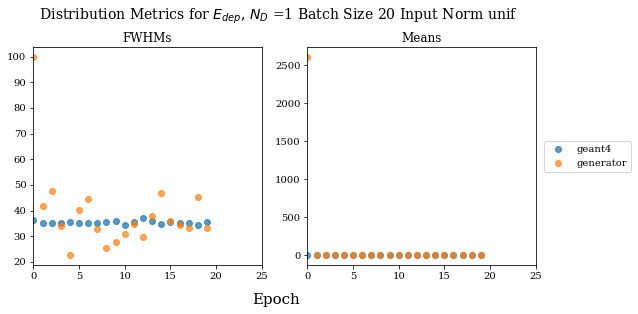

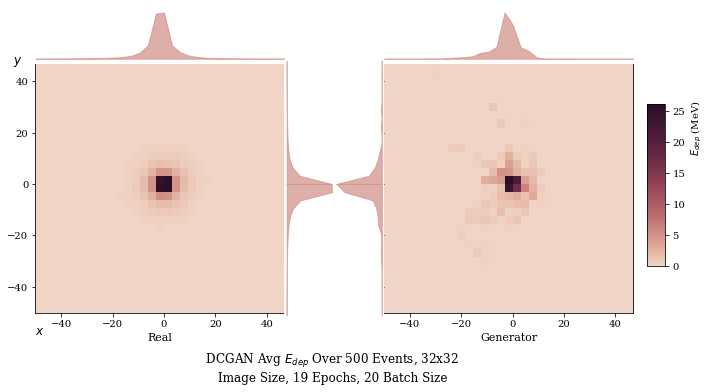

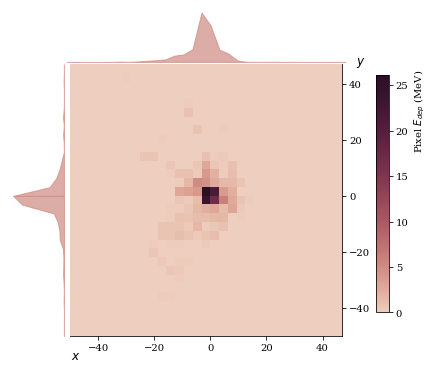

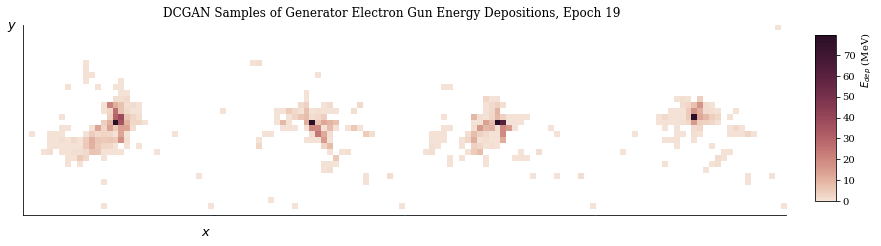

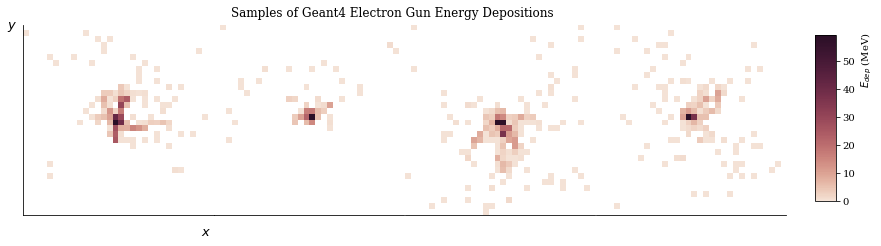

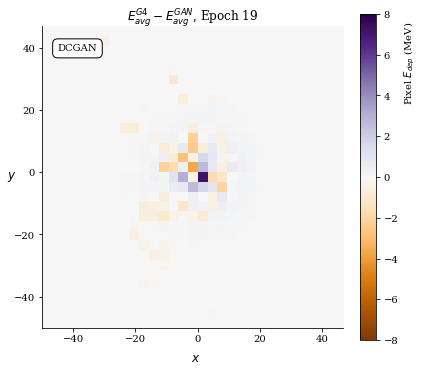

[19/50][0/1500] Loss_D: 0.3940 Loss_G: 3.3219 D(x): 0.7479 D(G(z)): 0.0021 / 0.0584
[19/50][100/1500] Loss_D: 0.1444 Loss_G: 5.8374 D(x): 0.8900 D(G(z)): 0.0047 / 0.0105
[19/50][200/1500] Loss_D: 0.0496 Loss_G: 5.9159 D(x): 0.9742 D(G(z)): 0.0086 / 0.0031
[19/50][300/1500] Loss_D: 0.1661 Loss_G: 4.6004 D(x): 0.8765 D(G(z)): 0.0154 / 0.0144
[19/50][400/1500] Loss_D: 1.5364 Loss_G: 14.9638 D(x): 0.9953 D(G(z)): 0.7484 / 0.0000
[19/50][500/1500] Loss_D: 0.3176 Loss_G: 7.2890 D(x): 0.9969 D(G(z)): 0.2427 / 0.0013
[19/50][600/1500] Loss_D: 0.0878 Loss_G: 5.9452 D(x): 0.9998 D(G(z)): 0.0686 / 0.0041
[19/50][700/1500] Loss_D: 0.1544 Loss_G: 5.2047 D(x): 0.8832 D(G(z)): 0.0097 / 0.0071
[19/50][800/1500] Loss_D: 0.0940 Loss_G: 4.6765 D(x): 0.9474 D(G(z)): 0.0199 / 0.0117
[19/50][900/1500] Loss_D: 0.0931 Loss_G: 4.7141 D(x): 0.9897 D(G(z)): 0.0691 / 0.0149
[19/50][1000/1500] Loss_D: 0.1955 Loss_G: 4.0472 D(x): 0.8926 D(G(z)): 0.0290 / 0.0241
[19/50][1100/1500] Loss_D: 0.3094 Loss_G: 3.4274 D(x):

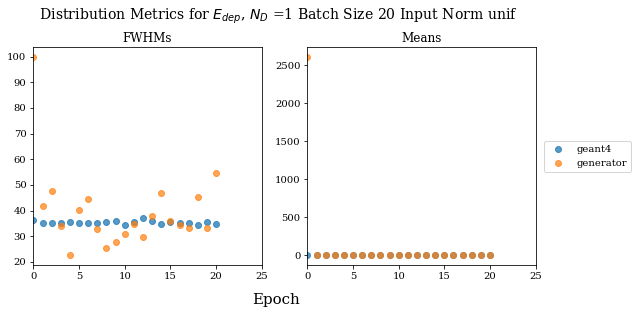

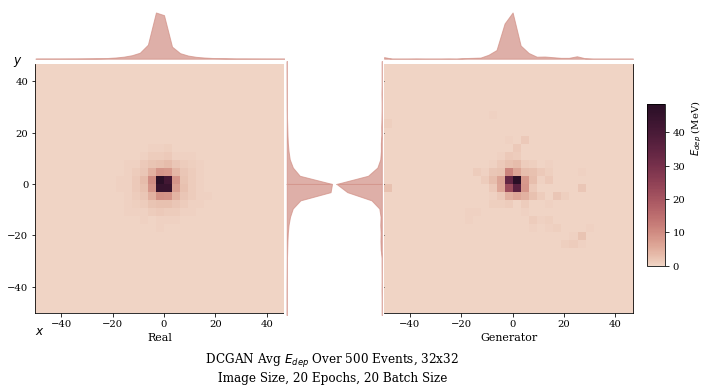

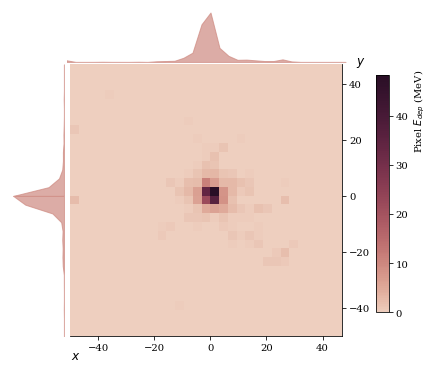

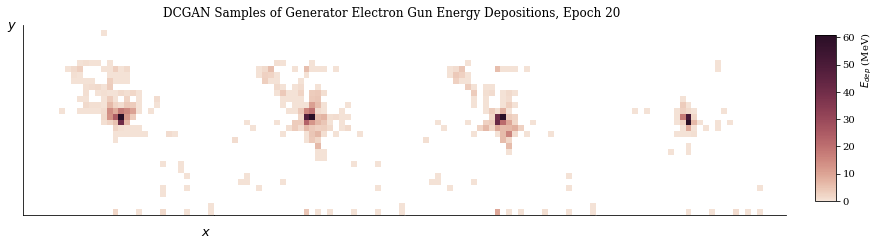

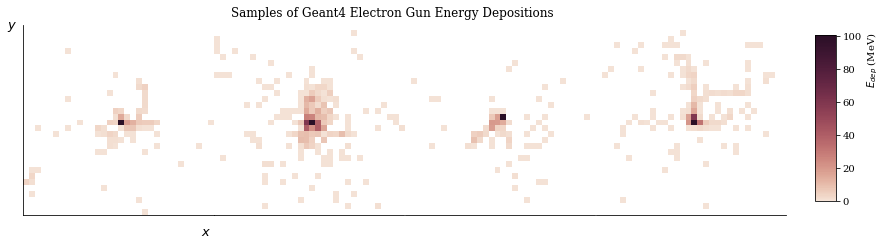

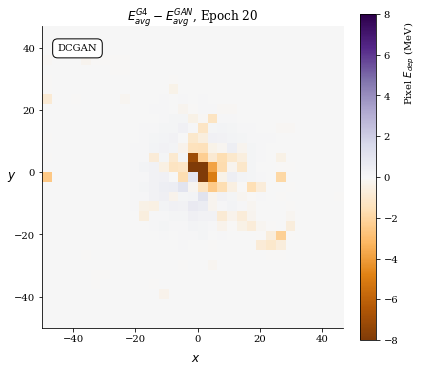

[20/50][0/1500] Loss_D: 0.1577 Loss_G: 6.0817 D(x): 0.9056 D(G(z)): 0.0081 / 0.0081
[20/50][100/1500] Loss_D: 0.0382 Loss_G: 7.2964 D(x): 0.9755 D(G(z)): 0.0008 / 0.0008
[20/50][200/1500] Loss_D: 0.1796 Loss_G: 3.0622 D(x): 0.8746 D(G(z)): 0.0079 / 0.0546
[20/50][300/1500] Loss_D: 0.0391 Loss_G: 6.2011 D(x): 0.9918 D(G(z)): 0.0174 / 0.0034
[20/50][400/1500] Loss_D: 0.0304 Loss_G: 5.5701 D(x): 0.9989 D(G(z)): 0.0136 / 0.0049
[20/50][500/1500] Loss_D: 0.3360 Loss_G: 5.5037 D(x): 0.9194 D(G(z)): 0.1311 / 0.0078
[20/50][600/1500] Loss_D: 0.1672 Loss_G: 5.1306 D(x): 0.9974 D(G(z)): 0.1302 / 0.0079
[20/50][700/1500] Loss_D: 0.0258 Loss_G: 5.6456 D(x): 0.9922 D(G(z)): 0.0062 / 0.0069
[20/50][800/1500] Loss_D: 0.0376 Loss_G: 7.1461 D(x): 0.9789 D(G(z)): 0.0023 / 0.0023
[20/50][900/1500] Loss_D: 0.0431 Loss_G: 5.2670 D(x): 0.9855 D(G(z)): 0.0151 / 0.0103
[20/50][1000/1500] Loss_D: 0.0272 Loss_G: 5.6065 D(x): 0.9920 D(G(z)): 0.0040 / 0.0041
[20/50][1100/1500] Loss_D: 0.2564 Loss_G: 8.0413 D(x): 

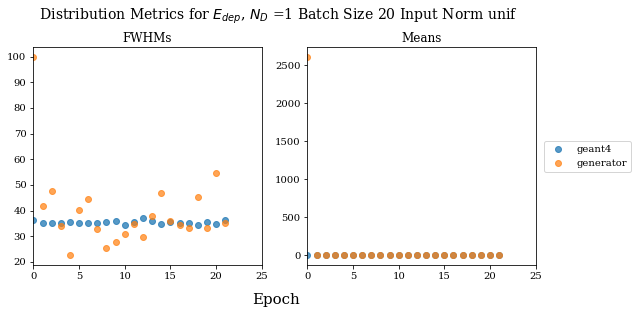

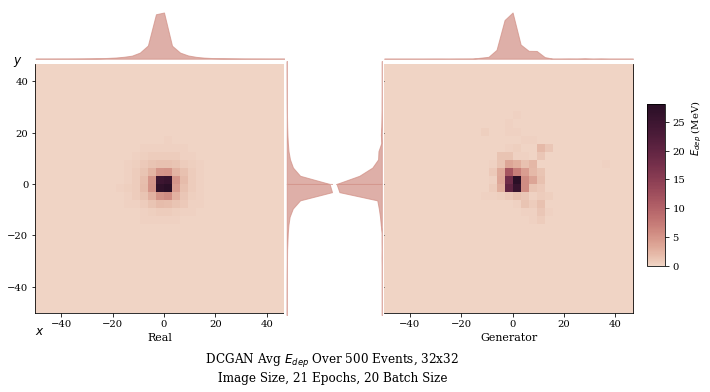

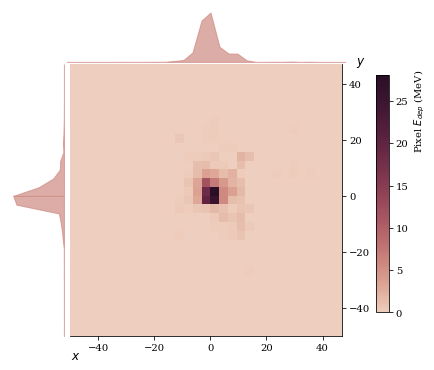

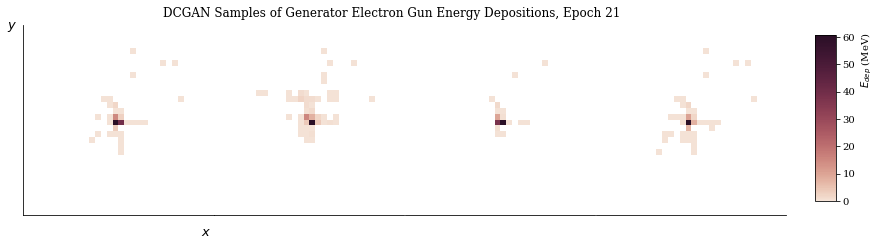

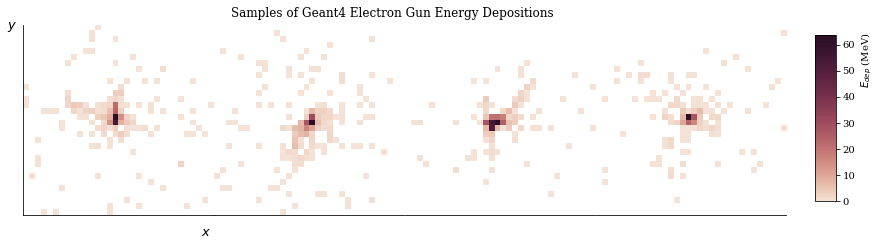

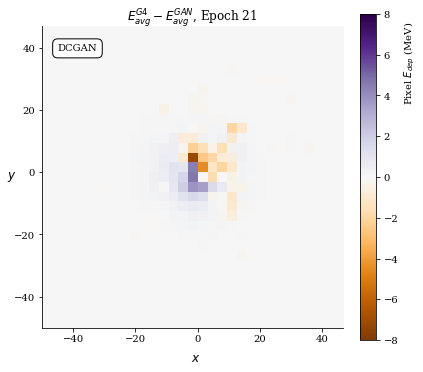

[21/50][0/1500] Loss_D: 0.0359 Loss_G: 5.5246 D(x): 0.9972 D(G(z)): 0.0192 / 0.0072
[21/50][100/1500] Loss_D: 0.0207 Loss_G: 5.8751 D(x): 0.9981 D(G(z)): 0.0049 / 0.0032
[21/50][200/1500] Loss_D: 0.0501 Loss_G: 5.3728 D(x): 0.9690 D(G(z)): 0.0057 / 0.0069
[21/50][300/1500] Loss_D: 0.0776 Loss_G: 5.1855 D(x): 0.9971 D(G(z)): 0.0579 / 0.0102
[21/50][400/1500] Loss_D: 0.1651 Loss_G: 4.3351 D(x): 0.9570 D(G(z)): 0.0507 / 0.0204
[21/50][500/1500] Loss_D: 0.4136 Loss_G: 8.3963 D(x): 0.9621 D(G(z)): 0.2731 / 0.0004
[21/50][600/1500] Loss_D: 0.0342 Loss_G: 4.8404 D(x): 0.9962 D(G(z)): 0.0183 / 0.0103
[21/50][700/1500] Loss_D: 0.1732 Loss_G: 4.9419 D(x): 0.8784 D(G(z)): 0.0033 / 0.0089
[21/50][800/1500] Loss_D: 0.0549 Loss_G: 4.5881 D(x): 0.9921 D(G(z)): 0.0355 / 0.0122
[21/50][900/1500] Loss_D: 0.1192 Loss_G: 3.5389 D(x): 0.9463 D(G(z)): 0.0492 / 0.0341
[21/50][1000/1500] Loss_D: 0.0481 Loss_G: 3.7785 D(x): 0.9986 D(G(z)): 0.0327 / 0.0353
[21/50][1100/1500] Loss_D: 0.2609 Loss_G: 2.5028 D(x): 

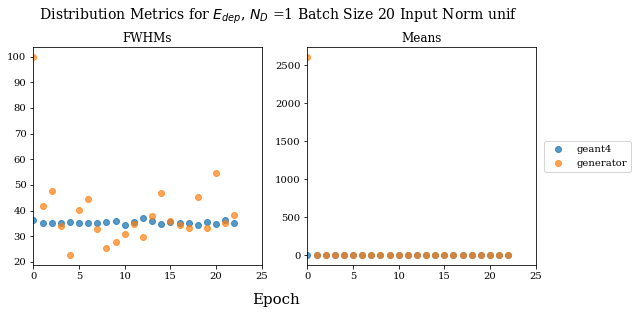

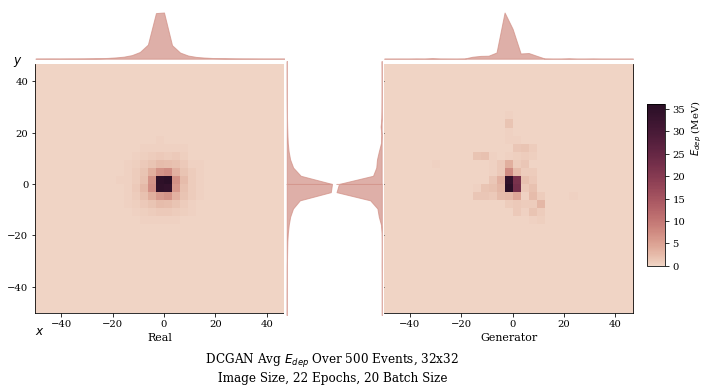

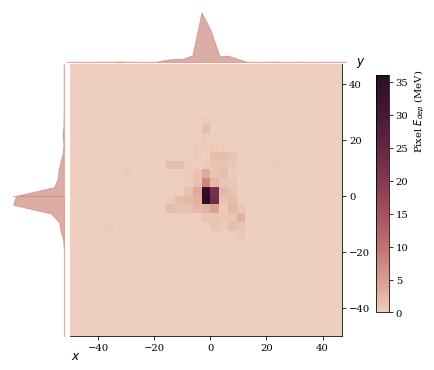

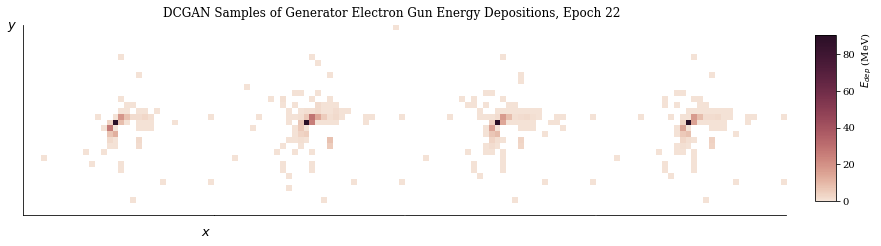

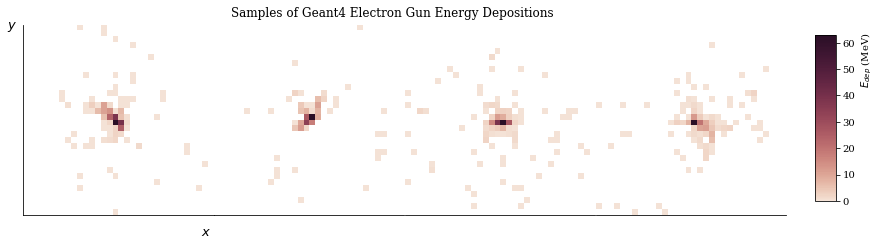

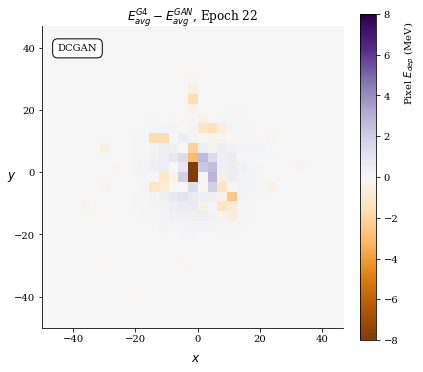

[22/50][0/1500] Loss_D: 0.6439 Loss_G: 10.0270 D(x): 0.9994 D(G(z)): 0.4218 / 0.0001
[22/50][100/1500] Loss_D: 0.0492 Loss_G: 5.1755 D(x): 0.9708 D(G(z)): 0.0076 / 0.0070
[22/50][200/1500] Loss_D: 0.4470 Loss_G: 2.7073 D(x): 0.8216 D(G(z)): 0.0144 / 0.0965
[22/50][300/1500] Loss_D: 0.0883 Loss_G: 4.9684 D(x): 0.9940 D(G(z)): 0.0653 / 0.0093
[22/50][400/1500] Loss_D: 0.0312 Loss_G: 5.1874 D(x): 0.9995 D(G(z)): 0.0145 / 0.0089
[22/50][500/1500] Loss_D: 0.1868 Loss_G: 4.9579 D(x): 0.8866 D(G(z)): 0.0173 / 0.0310
[22/50][600/1500] Loss_D: 0.0255 Loss_G: 5.7238 D(x): 0.9943 D(G(z)): 0.0032 / 0.0037
[22/50][700/1500] Loss_D: 0.4199 Loss_G: 9.2148 D(x): 0.9613 D(G(z)): 0.2180 / 0.0002
[22/50][800/1500] Loss_D: 0.3764 Loss_G: 4.8358 D(x): 0.9486 D(G(z)): 0.0599 / 0.0126
[22/50][900/1500] Loss_D: 0.0526 Loss_G: 5.0730 D(x): 0.9943 D(G(z)): 0.0294 / 0.0347
[22/50][1000/1500] Loss_D: 0.2640 Loss_G: 5.9741 D(x): 0.9936 D(G(z)): 0.2139 / 0.0030
[22/50][1100/1500] Loss_D: 0.2003 Loss_G: 2.9500 D(x):

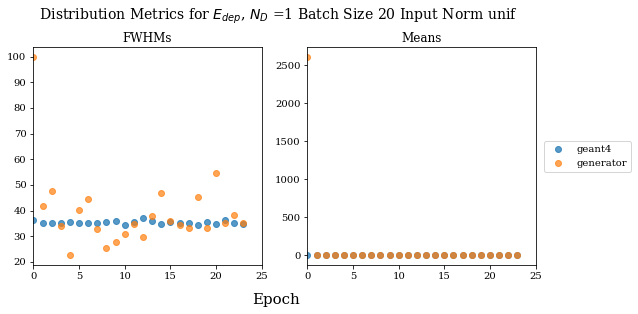

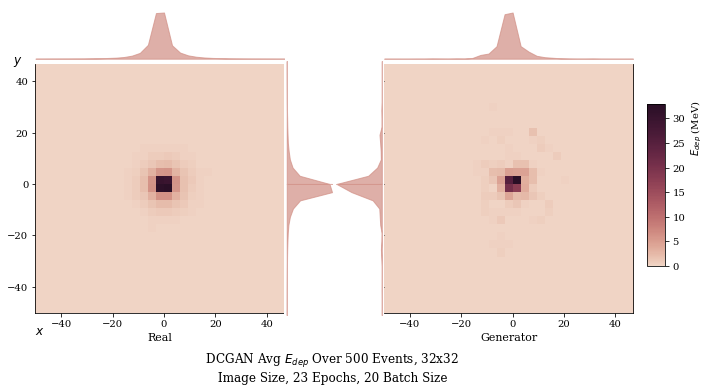

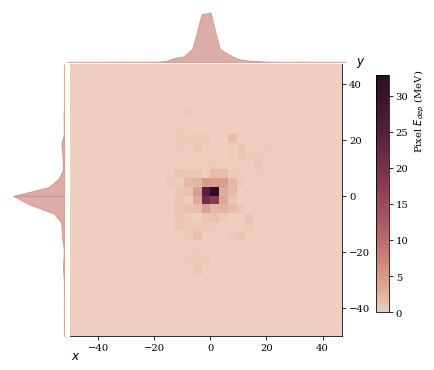

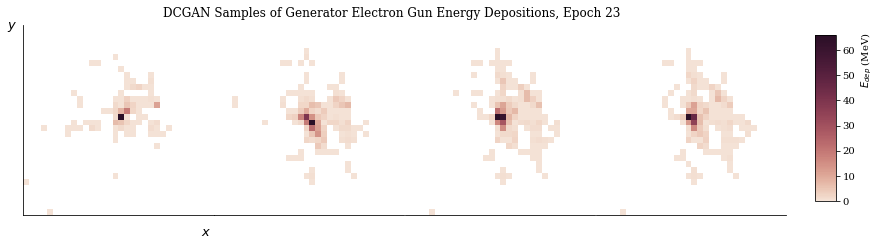

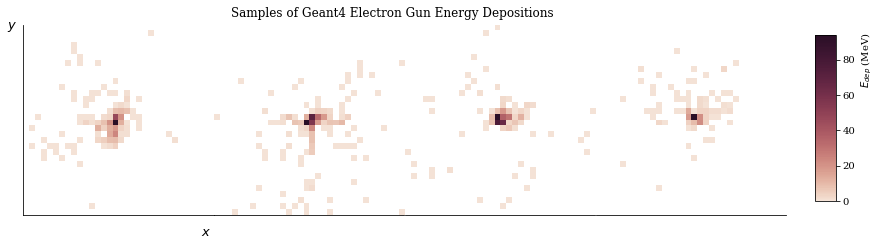

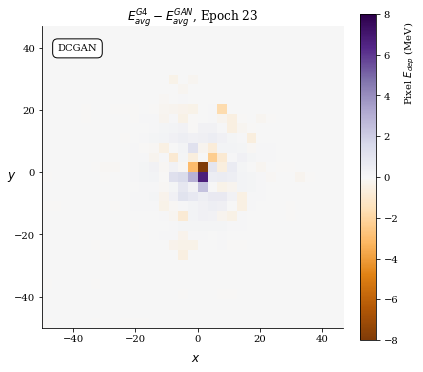

[23/50][0/1500] Loss_D: 0.1934 Loss_G: 2.3028 D(x): 0.8571 D(G(z)): 0.0005 / 0.1521
[23/50][100/1500] Loss_D: 0.1327 Loss_G: 4.4933 D(x): 0.9435 D(G(z)): 0.0332 / 0.0546
[23/50][200/1500] Loss_D: 0.5572 Loss_G: 6.1848 D(x): 0.6833 D(G(z)): 0.0135 / 0.0099
[23/50][300/1500] Loss_D: 0.2832 Loss_G: 3.5857 D(x): 0.8996 D(G(z)): 0.1180 / 0.0393
[23/50][400/1500] Loss_D: 0.1005 Loss_G: 3.4671 D(x): 0.9985 D(G(z)): 0.0834 / 0.0380
[23/50][500/1500] Loss_D: 0.0932 Loss_G: 4.3893 D(x): 0.9633 D(G(z)): 0.0440 / 0.0170
[23/50][600/1500] Loss_D: 0.0811 Loss_G: 4.5088 D(x): 0.9985 D(G(z)): 0.0640 / 0.0145
[23/50][700/1500] Loss_D: 0.2734 Loss_G: 5.4239 D(x): 0.9614 D(G(z)): 0.1960 / 0.0053
[23/50][800/1500] Loss_D: 0.0490 Loss_G: 5.3671 D(x): 0.9690 D(G(z)): 0.0055 / 0.0060
[23/50][900/1500] Loss_D: 0.1411 Loss_G: 3.6296 D(x): 0.9595 D(G(z)): 0.0465 / 0.0407
[23/50][1000/1500] Loss_D: 0.1518 Loss_G: 4.0820 D(x): 0.9391 D(G(z)): 0.0576 / 0.0297
[23/50][1100/1500] Loss_D: 0.4266 Loss_G: 1.3353 D(x): 

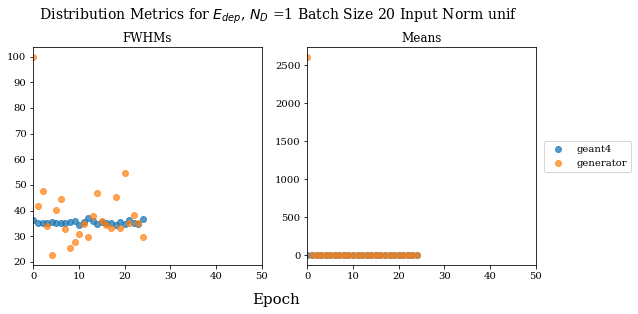

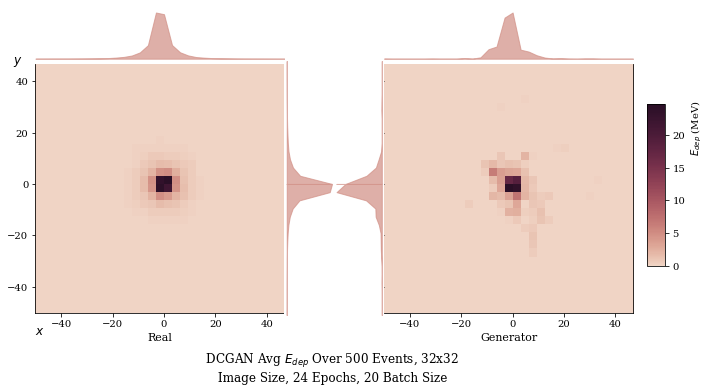

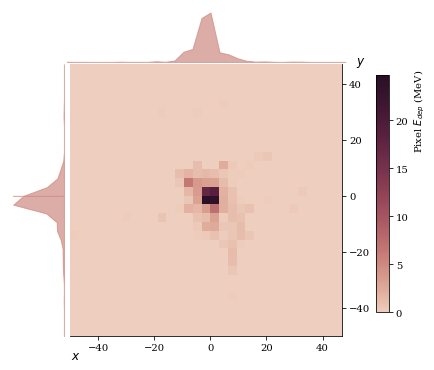

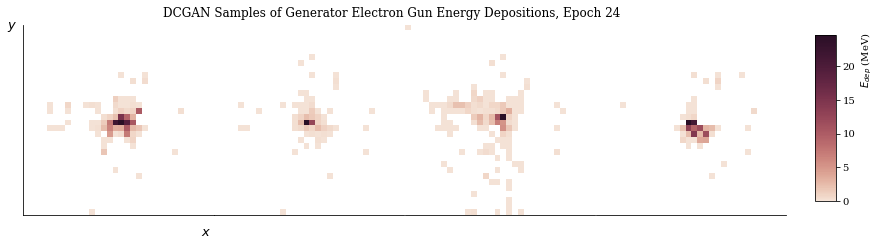

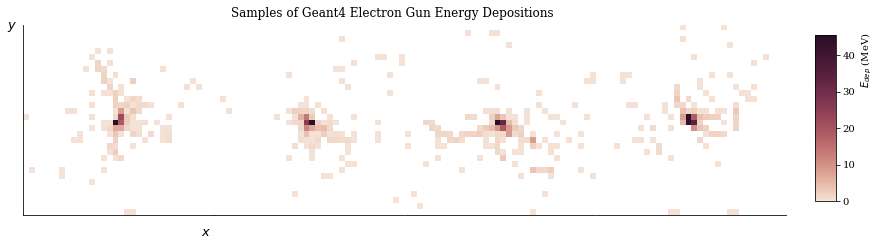

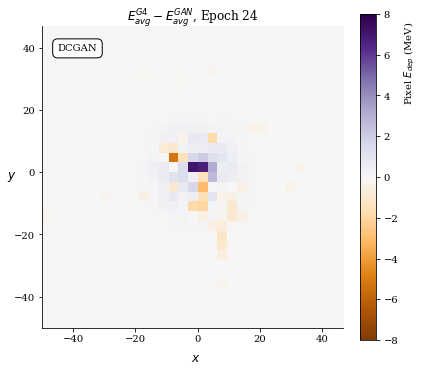

[24/50][0/1500] Loss_D: 0.0684 Loss_G: 4.3276 D(x): 0.9903 D(G(z)): 0.0466 / 0.0163
[24/50][100/1500] Loss_D: 0.0358 Loss_G: 4.4742 D(x): 0.9811 D(G(z)): 0.0060 / 0.0132
[24/50][200/1500] Loss_D: 0.2529 Loss_G: 3.2634 D(x): 0.8209 D(G(z)): 0.0047 / 0.0421
[24/50][300/1500] Loss_D: 0.1414 Loss_G: 7.2629 D(x): 0.9923 D(G(z)): 0.1115 / 0.0014
[24/50][400/1500] Loss_D: 0.1246 Loss_G: 5.8236 D(x): 0.9529 D(G(z)): 0.0294 / 0.0055
[24/50][500/1500] Loss_D: 0.5559 Loss_G: 2.3030 D(x): 0.6489 D(G(z)): 0.0018 / 0.1437
[24/50][600/1500] Loss_D: 0.1024 Loss_G: 3.4354 D(x): 0.9968 D(G(z)): 0.0852 / 0.0375
[24/50][700/1500] Loss_D: 0.1634 Loss_G: 3.7196 D(x): 0.9402 D(G(z)): 0.0670 / 0.0334
[24/50][800/1500] Loss_D: 0.3380 Loss_G: 3.1743 D(x): 0.7845 D(G(z)): 0.0038 / 0.0511
[24/50][900/1500] Loss_D: 0.0450 Loss_G: 4.3959 D(x): 0.9935 D(G(z)): 0.0272 / 0.0183
[24/50][1000/1500] Loss_D: 0.3364 Loss_G: 6.8346 D(x): 0.9890 D(G(z)): 0.2579 / 0.0012
[24/50][1100/1500] Loss_D: 0.2656 Loss_G: 6.0739 D(x): 

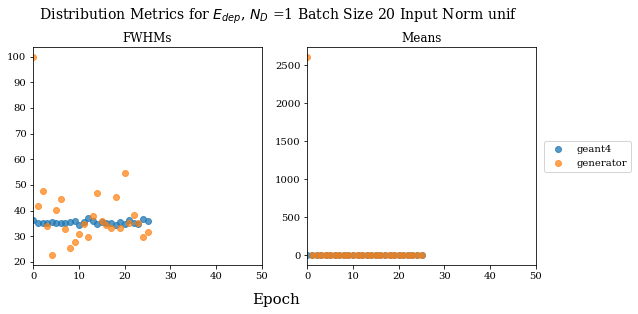

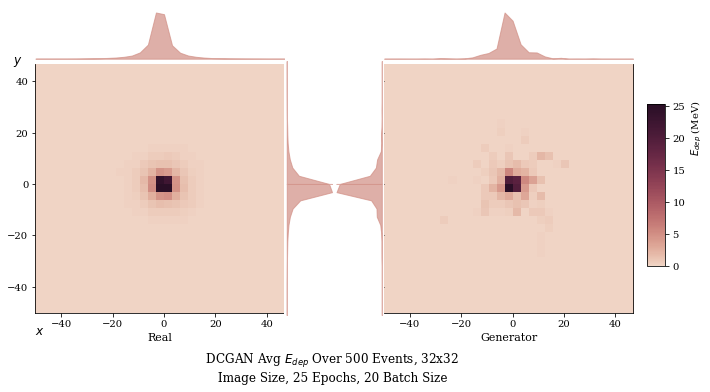

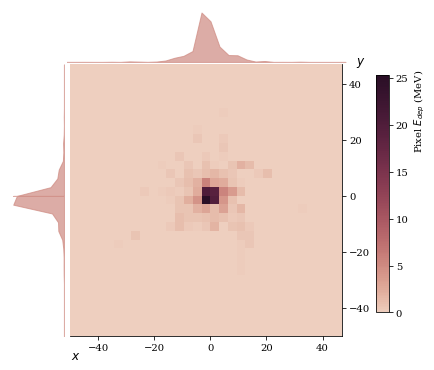

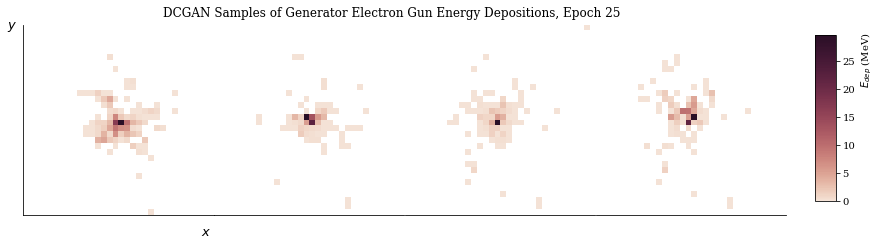

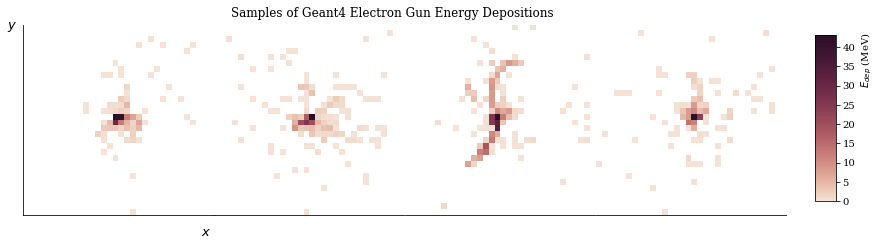

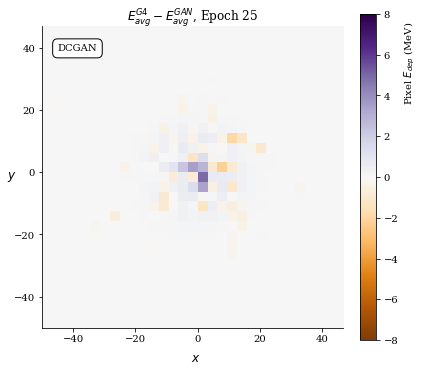

[25/50][0/1500] Loss_D: 0.1072 Loss_G: 6.7011 D(x): 0.9243 D(G(z)): 0.0017 / 0.0020
[25/50][100/1500] Loss_D: 0.1973 Loss_G: 4.5845 D(x): 0.8572 D(G(z)): 0.0042 / 0.0170
[25/50][200/1500] Loss_D: 0.0475 Loss_G: 4.6847 D(x): 0.9857 D(G(z)): 0.0207 / 0.0140
[25/50][300/1500] Loss_D: 0.0521 Loss_G: 4.5916 D(x): 0.9745 D(G(z)): 0.0096 / 0.0113
[25/50][400/1500] Loss_D: 0.0586 Loss_G: 5.3321 D(x): 0.9985 D(G(z)): 0.0423 / 0.0107
[25/50][500/1500] Loss_D: 0.4872 Loss_G: 2.3484 D(x): 0.7716 D(G(z)): 0.0735 / 0.1235
[25/50][600/1500] Loss_D: 0.1649 Loss_G: 4.6862 D(x): 0.9999 D(G(z)): 0.1382 / 0.0098
[25/50][700/1500] Loss_D: 0.0213 Loss_G: 6.1699 D(x): 0.9966 D(G(z)): 0.0048 / 0.0042
[25/50][800/1500] Loss_D: 0.0521 Loss_G: 5.4829 D(x): 0.9697 D(G(z)): 0.0098 / 0.0075
[25/50][900/1500] Loss_D: 0.1582 Loss_G: 6.4188 D(x): 0.9967 D(G(z)): 0.1196 / 0.0054
[25/50][1000/1500] Loss_D: 0.7210 Loss_G: 4.8905 D(x): 0.7980 D(G(z)): 0.2432 / 0.0300
[25/50][1100/1500] Loss_D: 0.1354 Loss_G: 3.4615 D(x): 

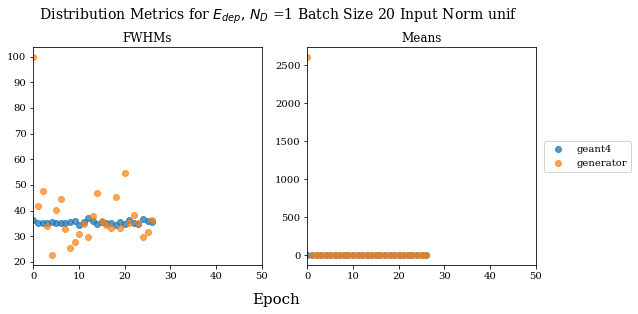

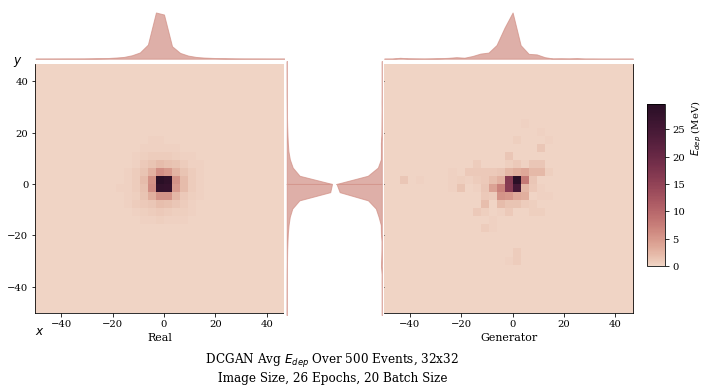

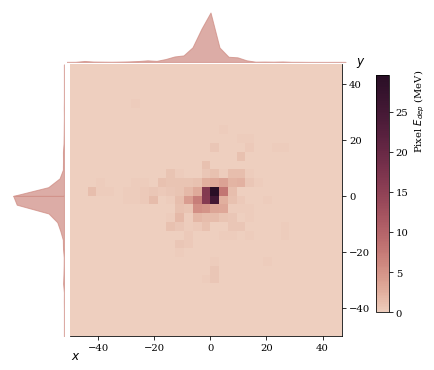

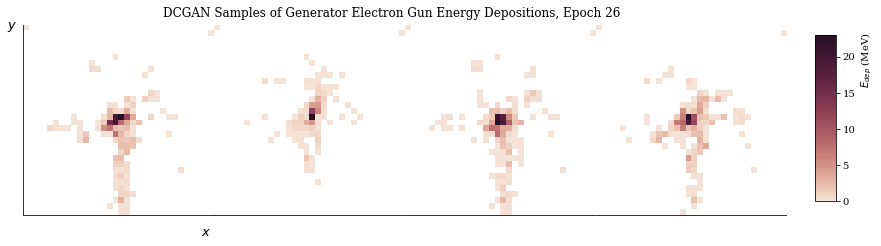

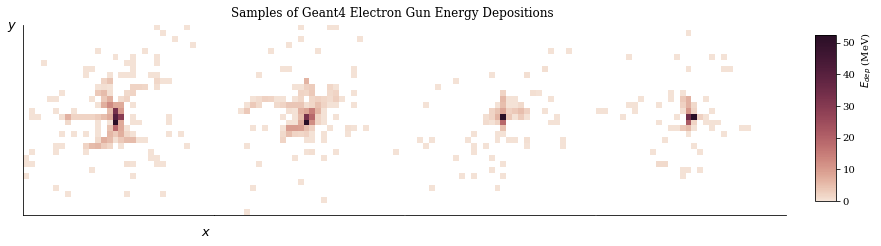

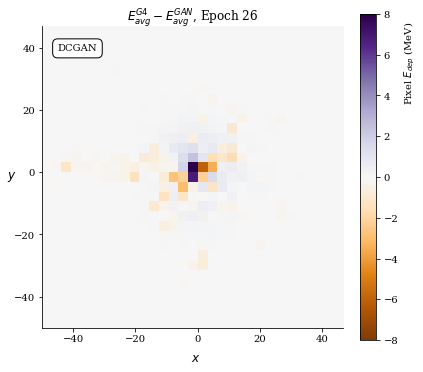

[26/50][0/1500] Loss_D: 1.0000 Loss_G: 7.7680 D(x): 0.5527 D(G(z)): 0.0000 / 0.0026
[26/50][100/1500] Loss_D: 0.0771 Loss_G: 6.1359 D(x): 0.9425 D(G(z)): 0.0016 / 0.0030
[26/50][200/1500] Loss_D: 0.3120 Loss_G: 4.2021 D(x): 0.8775 D(G(z)): 0.0482 / 0.0302
[26/50][300/1500] Loss_D: 0.0520 Loss_G: 5.8404 D(x): 0.9733 D(G(z)): 0.0130 / 0.0157
[26/50][400/1500] Loss_D: 0.0546 Loss_G: 5.7693 D(x): 0.9625 D(G(z)): 0.0037 / 0.0189
[26/50][500/1500] Loss_D: 0.2174 Loss_G: 6.7284 D(x): 0.8493 D(G(z)): 0.0021 / 0.0016
[26/50][600/1500] Loss_D: 0.0768 Loss_G: 3.4634 D(x): 0.9944 D(G(z)): 0.0573 / 0.0401
[26/50][700/1500] Loss_D: 0.0970 Loss_G: 5.1831 D(x): 0.9520 D(G(z)): 0.0119 / 0.0072
[26/50][800/1500] Loss_D: 0.0410 Loss_G: 5.1375 D(x): 0.9980 D(G(z)): 0.0246 / 0.0108
[26/50][900/1500] Loss_D: 0.0470 Loss_G: 6.9173 D(x): 0.9983 D(G(z)): 0.0249 / 0.0058
[26/50][1000/1500] Loss_D: 0.1612 Loss_G: 4.8130 D(x): 0.9865 D(G(z)): 0.1218 / 0.0100
[26/50][1100/1500] Loss_D: 0.2043 Loss_G: 4.2465 D(x): 

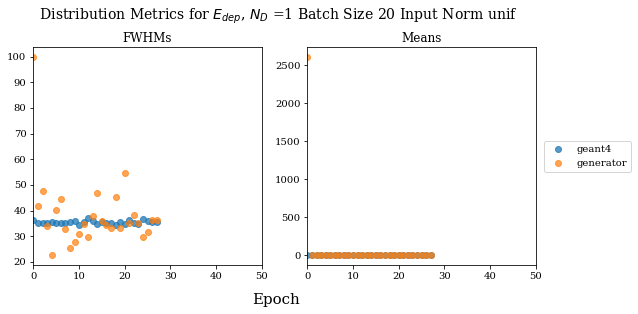

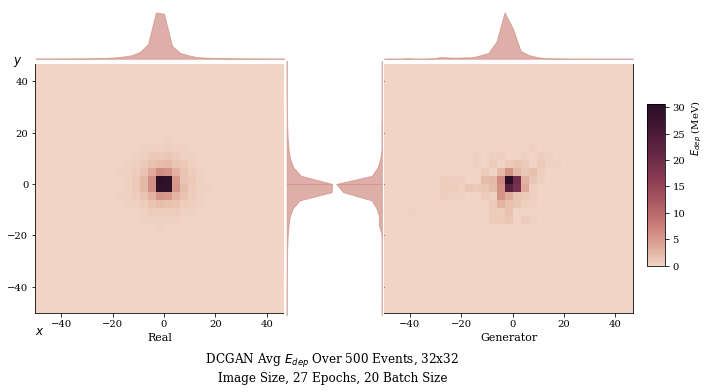

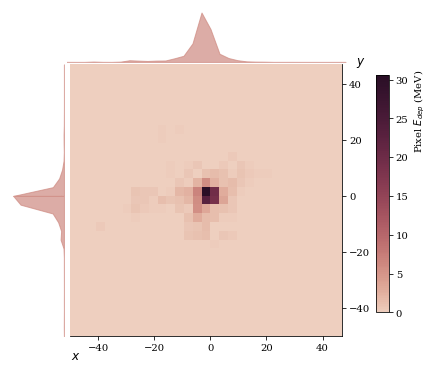

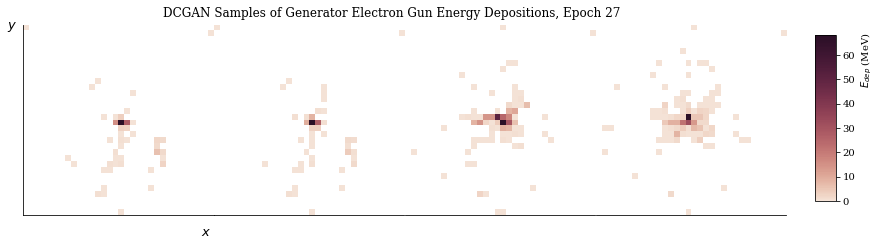

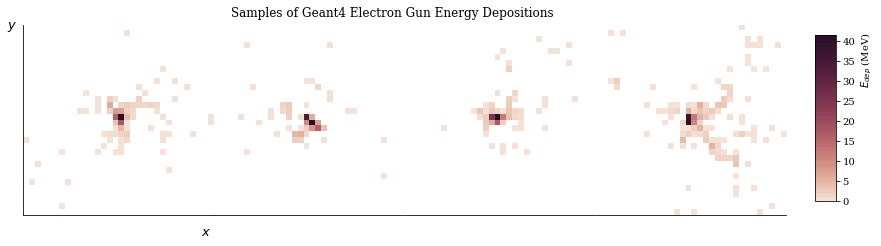

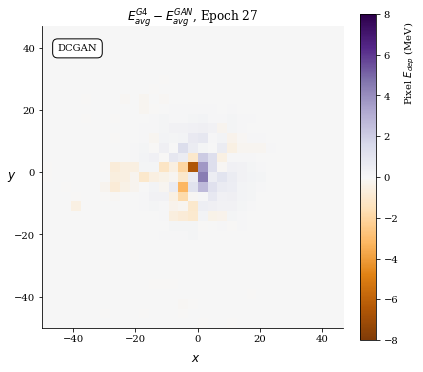

[27/50][0/1500] Loss_D: 0.2245 Loss_G: 4.1599 D(x): 0.8930 D(G(z)): 0.0663 / 0.0242
[27/50][100/1500] Loss_D: 0.1999 Loss_G: 4.7081 D(x): 0.8539 D(G(z)): 0.0059 / 0.0278
[27/50][200/1500] Loss_D: 0.3012 Loss_G: 2.8668 D(x): 0.8064 D(G(z)): 0.0216 / 0.0811
[27/50][300/1500] Loss_D: 0.1984 Loss_G: 6.3026 D(x): 0.9918 D(G(z)): 0.1574 / 0.0027
[27/50][400/1500] Loss_D: 0.0385 Loss_G: 5.8221 D(x): 0.9963 D(G(z)): 0.0221 / 0.0098
[27/50][500/1500] Loss_D: 0.3217 Loss_G: 2.4951 D(x): 0.8206 D(G(z)): 0.0821 / 0.1013
[27/50][600/1500] Loss_D: 0.0265 Loss_G: 4.4777 D(x): 0.9983 D(G(z)): 0.0105 / 0.0161
[27/50][700/1500] Loss_D: 0.2893 Loss_G: 6.3989 D(x): 0.9999 D(G(z)): 0.2254 / 0.0023
[27/50][800/1500] Loss_D: 0.0425 Loss_G: 6.0641 D(x): 0.9742 D(G(z)): 0.0046 / 0.0035
[27/50][900/1500] Loss_D: 0.0671 Loss_G: 3.9247 D(x): 0.9980 D(G(z)): 0.0509 / 0.0271
[27/50][1000/1500] Loss_D: 0.1803 Loss_G: 3.8599 D(x): 0.9610 D(G(z)): 0.1145 / 0.0243
[27/50][1100/1500] Loss_D: 0.2584 Loss_G: 4.1513 D(x): 

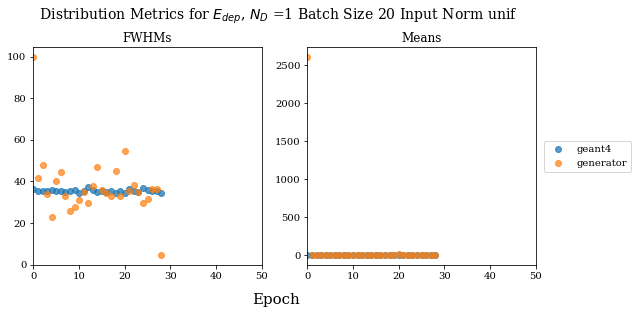

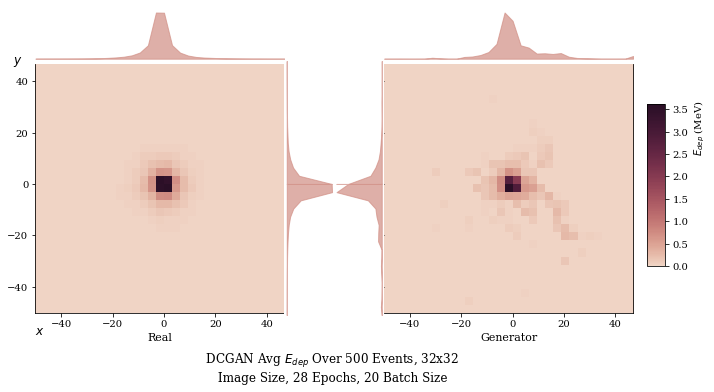

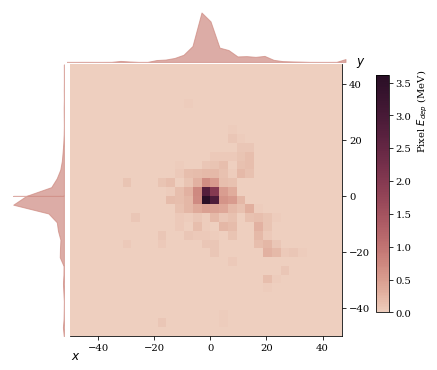

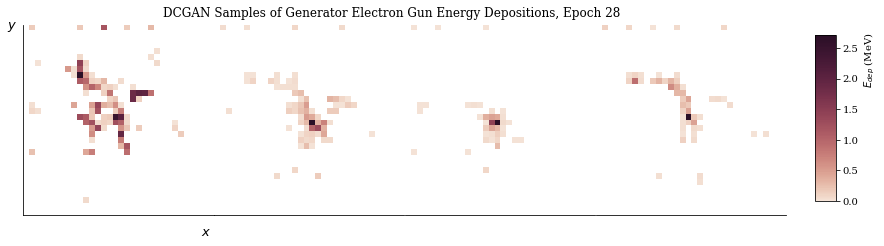

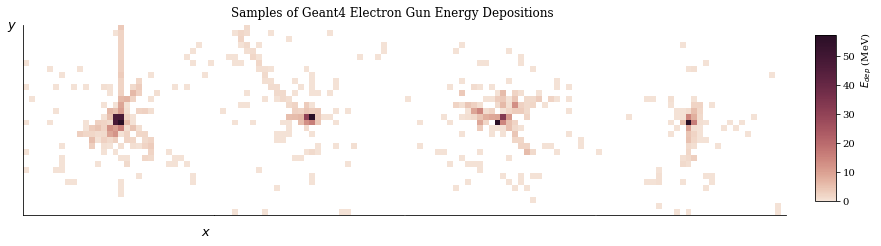

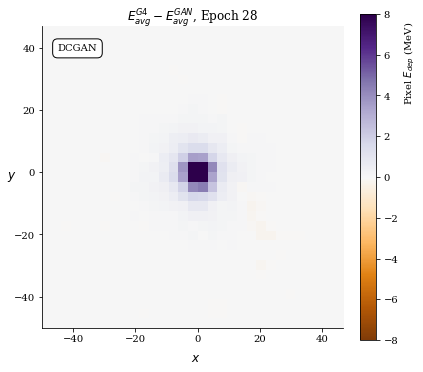

[28/50][0/1500] Loss_D: 0.1545 Loss_G: 6.6360 D(x): 0.9035 D(G(z)): 0.0016 / 0.0023
[28/50][100/1500] Loss_D: 0.0320 Loss_G: 8.3607 D(x): 0.9839 D(G(z)): 0.0004 / 0.0008
[28/50][200/1500] Loss_D: 0.0353 Loss_G: 7.6936 D(x): 0.9844 D(G(z)): 0.0087 / 0.0008
[28/50][300/1500] Loss_D: 0.0688 Loss_G: 5.8479 D(x): 0.9638 D(G(z)): 0.0202 / 0.0046
[28/50][400/1500] Loss_D: 0.0256 Loss_G: 5.1448 D(x): 0.9999 D(G(z)): 0.0093 / 0.0093
[28/50][500/1500] Loss_D: 0.2336 Loss_G: 4.8354 D(x): 0.9748 D(G(z)): 0.1664 / 0.0136
[28/50][600/1500] Loss_D: 0.0415 Loss_G: 5.1366 D(x): 0.9903 D(G(z)): 0.0211 / 0.0094
[28/50][700/1500] Loss_D: 0.6114 Loss_G: 7.5839 D(x): 0.9916 D(G(z)): 0.3880 / 0.0010
[28/50][800/1500] Loss_D: 0.2090 Loss_G: 3.8294 D(x): 0.8760 D(G(z)): 0.0199 / 0.0356
[28/50][900/1500] Loss_D: 0.0514 Loss_G: 5.0767 D(x): 0.9926 D(G(z)): 0.0312 / 0.0087
[28/50][1000/1500] Loss_D: 0.2538 Loss_G: 7.0112 D(x): 0.9834 D(G(z)): 0.1894 / 0.0014
[28/50][1100/1500] Loss_D: 0.4464 Loss_G: 8.8754 D(x): 

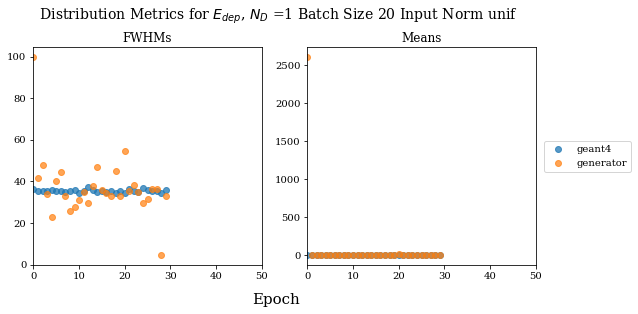

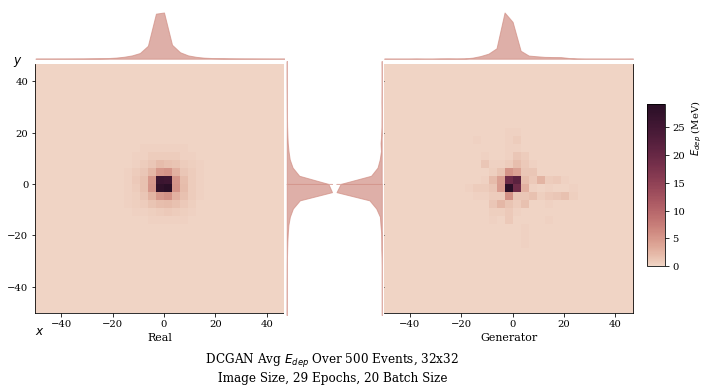

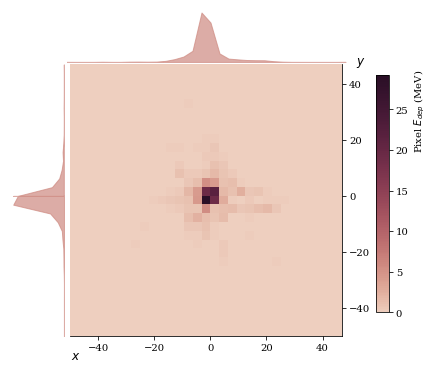

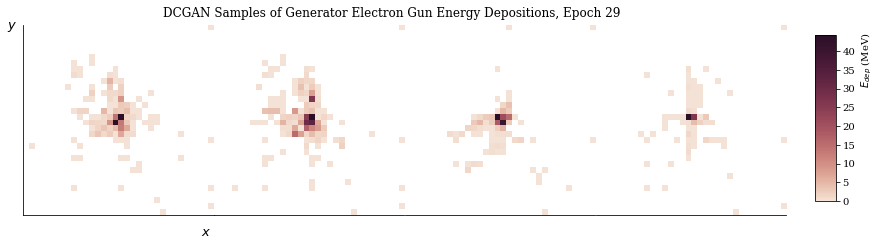

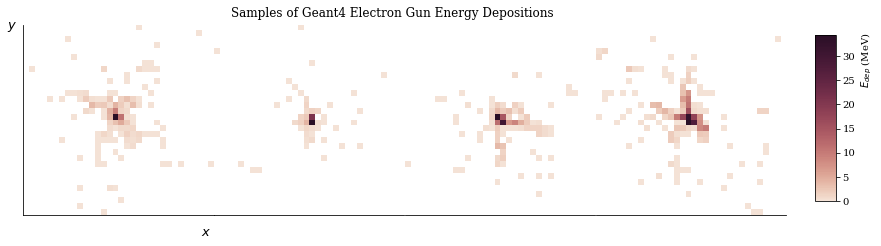

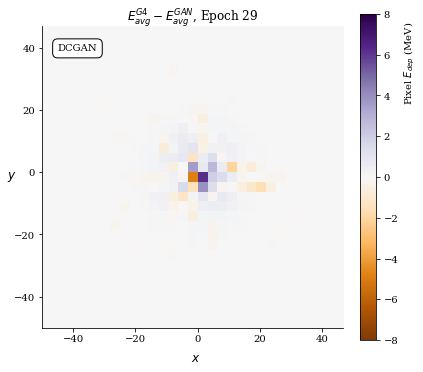

[29/50][0/1500] Loss_D: 0.2147 Loss_G: 3.3225 D(x): 0.8515 D(G(z)): 0.0032 / 0.0542
[29/50][100/1500] Loss_D: 0.2582 Loss_G: 3.7087 D(x): 0.7996 D(G(z)): 0.0043 / 0.0471
[29/50][200/1500] Loss_D: 0.0364 Loss_G: 8.6714 D(x): 0.9785 D(G(z)): 0.0019 / 0.0003
[29/50][300/1500] Loss_D: 1.5855 Loss_G: 19.8014 D(x): 0.9881 D(G(z)): 0.7322 / 0.0000
[29/50][400/1500] Loss_D: 0.0758 Loss_G: 4.7126 D(x): 0.9997 D(G(z)): 0.0603 / 0.0116
[29/50][500/1500] Loss_D: 0.0338 Loss_G: 3.9933 D(x): 0.9946 D(G(z)): 0.0162 / 0.0228
[29/50][600/1500] Loss_D: 0.0723 Loss_G: 5.2833 D(x): 0.9549 D(G(z)): 0.0098 / 0.0187
[29/50][700/1500] Loss_D: 0.1938 Loss_G: 4.0505 D(x): 0.8590 D(G(z)): 0.0050 / 0.0267
[29/50][800/1500] Loss_D: 0.0352 Loss_G: 5.7327 D(x): 0.9863 D(G(z)): 0.0099 / 0.0057
[29/50][900/1500] Loss_D: 0.1185 Loss_G: 5.9591 D(x): 0.9996 D(G(z)): 0.0944 / 0.0045
[29/50][1000/1500] Loss_D: 0.1015 Loss_G: 4.8274 D(x): 0.9942 D(G(z)): 0.0793 / 0.0113
[29/50][1100/1500] Loss_D: 0.2399 Loss_G: 3.4298 D(x):

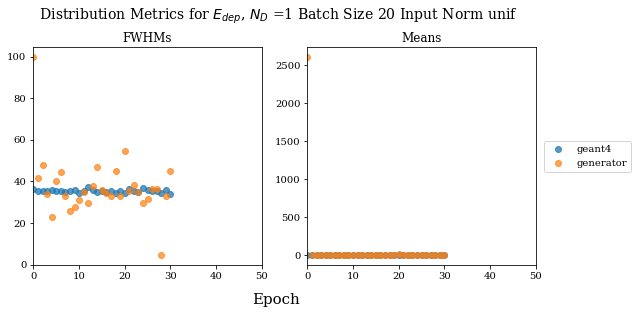

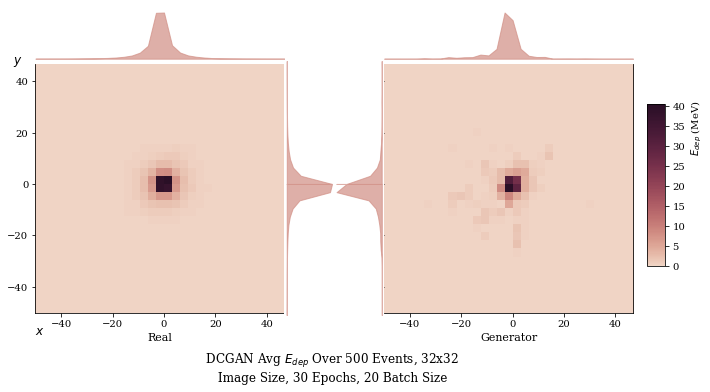

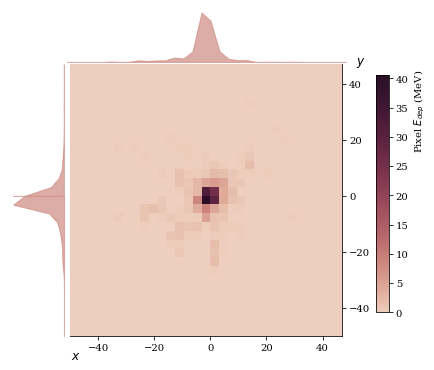

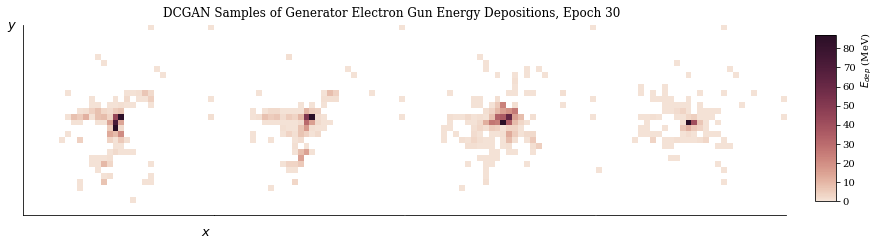

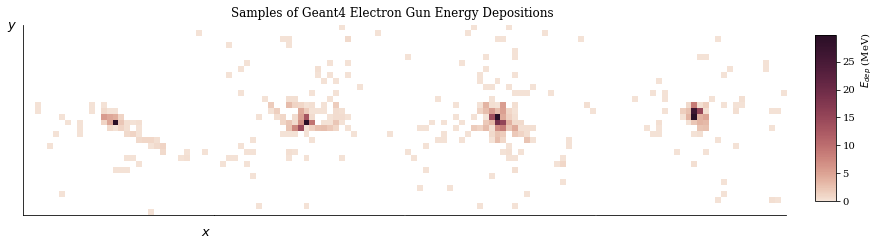

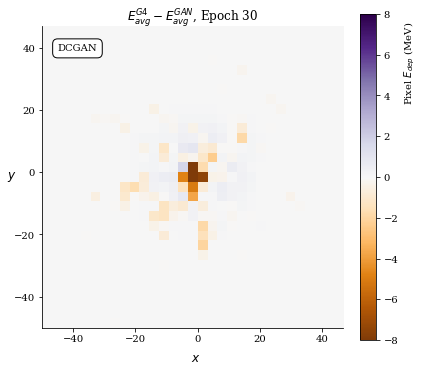

[30/50][0/1500] Loss_D: 0.1325 Loss_G: 4.2228 D(x): 0.9035 D(G(z)): 0.0118 / 0.0374
[30/50][100/1500] Loss_D: 0.1170 Loss_G: 5.7699 D(x): 0.9104 D(G(z)): 0.0026 / 0.0096
[30/50][200/1500] Loss_D: 0.0688 Loss_G: 4.9252 D(x): 0.9736 D(G(z)): 0.0270 / 0.0118
[30/50][300/1500] Loss_D: 0.1441 Loss_G: 3.7779 D(x): 0.9137 D(G(z)): 0.0080 / 0.0297
[30/50][400/1500] Loss_D: 0.0312 Loss_G: 5.5021 D(x): 0.9982 D(G(z)): 0.0156 / 0.0092
[30/50][500/1500] Loss_D: 0.2535 Loss_G: 3.1811 D(x): 0.8636 D(G(z)): 0.0633 / 0.0477
[30/50][600/1500] Loss_D: 0.0473 Loss_G: 4.9921 D(x): 0.9997 D(G(z)): 0.0325 / 0.0073
[30/50][700/1500] Loss_D: 0.0396 Loss_G: 5.7392 D(x): 0.9813 D(G(z)): 0.0042 / 0.0044
[30/50][800/1500] Loss_D: 0.0304 Loss_G: 6.9359 D(x): 0.9845 D(G(z)): 0.0019 / 0.0013
[30/50][900/1500] Loss_D: 0.0605 Loss_G: 5.0907 D(x): 0.9991 D(G(z)): 0.0434 / 0.0088
[30/50][1000/1500] Loss_D: 0.0198 Loss_G: 5.4102 D(x): 0.9995 D(G(z)): 0.0003 / 0.0061
[30/50][1100/1500] Loss_D: 0.0580 Loss_G: 5.6154 D(x): 

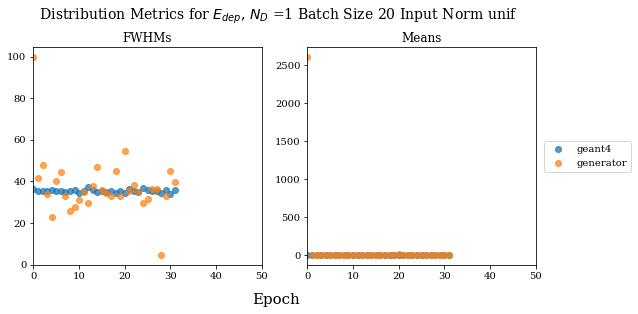

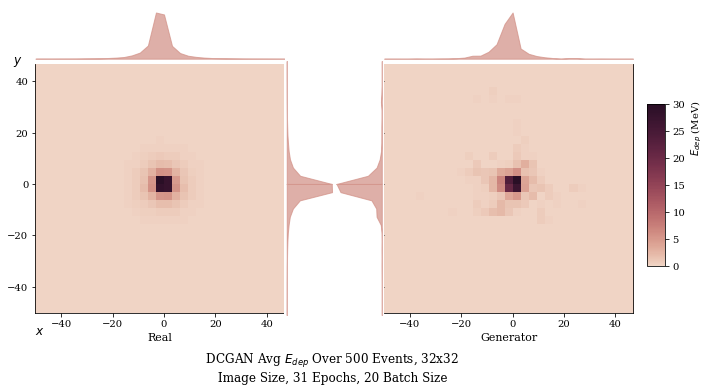

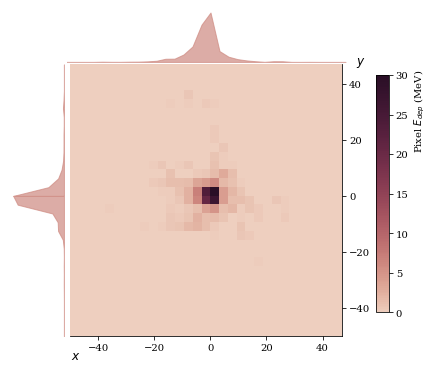

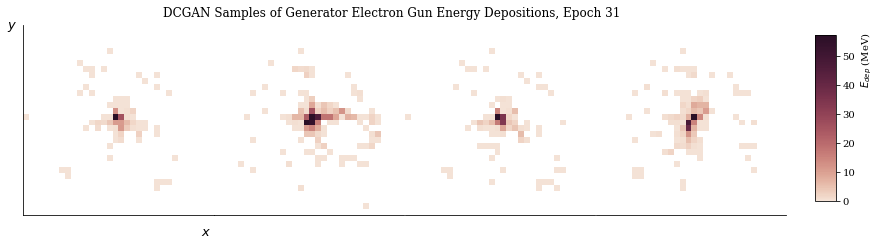

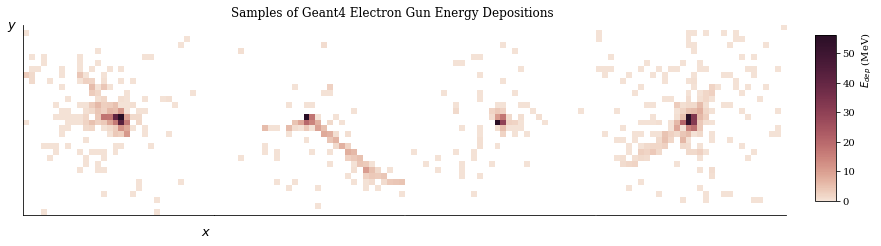

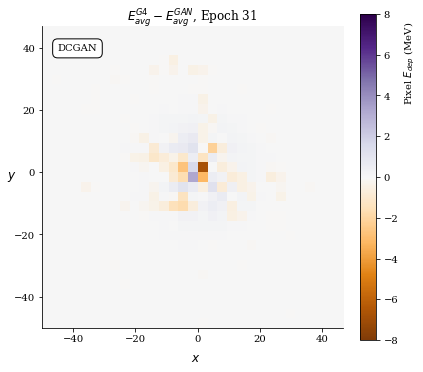

[31/50][0/1500] Loss_D: 0.0634 Loss_G: 5.0028 D(x): 0.9666 D(G(z)): 0.0183 / 0.0088
[31/50][100/1500] Loss_D: 0.1122 Loss_G: 5.4581 D(x): 0.9151 D(G(z)): 0.0032 / 0.0095
[31/50][200/1500] Loss_D: 0.1634 Loss_G: 5.0119 D(x): 0.9063 D(G(z)): 0.0085 / 0.0096
[31/50][300/1500] Loss_D: 0.0512 Loss_G: 6.2213 D(x): 0.9675 D(G(z)): 0.0040 / 0.0029
[31/50][400/1500] Loss_D: 0.0675 Loss_G: 4.3126 D(x): 0.9969 D(G(z)): 0.0503 / 0.0201
[31/50][500/1500] Loss_D: 0.0729 Loss_G: 4.2113 D(x): 0.9861 D(G(z)): 0.0457 / 0.0201
[31/50][600/1500] Loss_D: 0.0422 Loss_G: 4.8576 D(x): 1.0000 D(G(z)): 0.0242 / 0.0113
[31/50][700/1500] Loss_D: 0.2689 Loss_G: 16.7526 D(x): 0.8219 D(G(z)): 0.0000 / 0.0000
[31/50][800/1500] Loss_D: 0.1847 Loss_G: 3.6807 D(x): 0.8957 D(G(z)): 0.0119 / 0.0419
[31/50][900/1500] Loss_D: 0.0194 Loss_G: 8.4984 D(x): 0.9992 D(G(z)): 0.0005 / 0.0003
[31/50][1000/1500] Loss_D: 0.0372 Loss_G: 3.9234 D(x): 0.9887 D(G(z)): 0.0090 / 0.0290
[31/50][1100/1500] Loss_D: 0.1380 Loss_G: 4.0834 D(x):

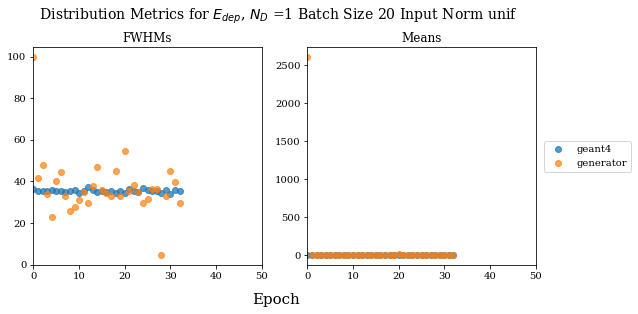

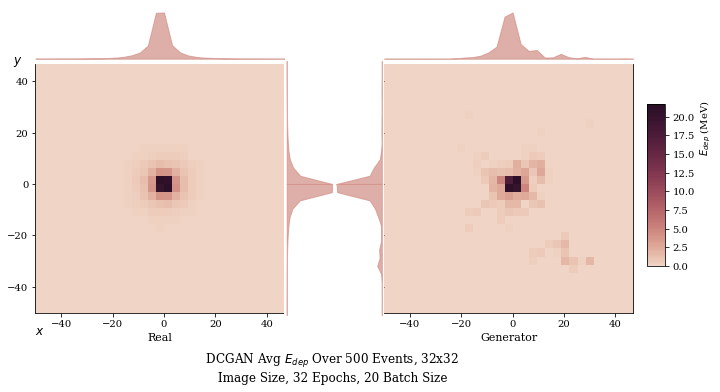

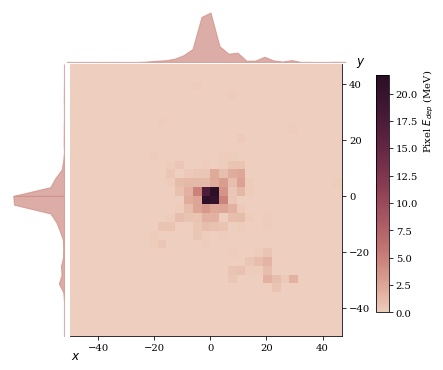

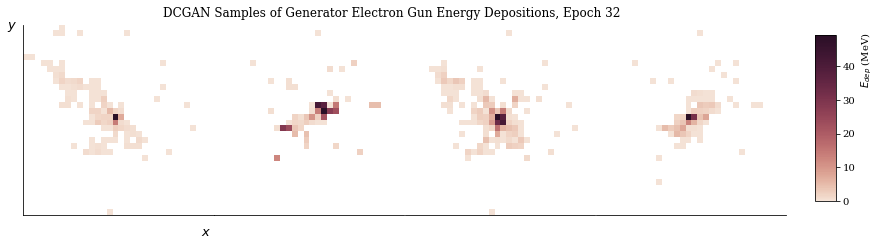

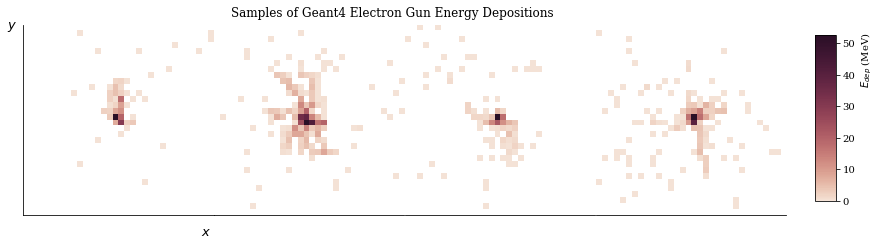

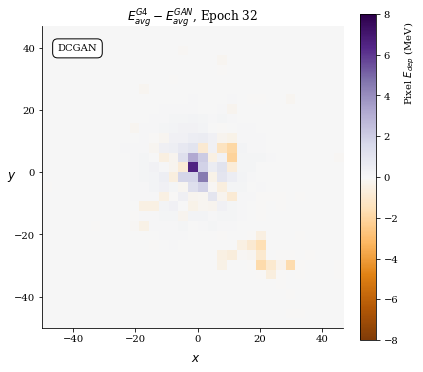

[32/50][0/1500] Loss_D: 0.0387 Loss_G: 6.8556 D(x): 0.9806 D(G(z)): 0.0024 / 0.0022
[32/50][100/1500] Loss_D: 0.0581 Loss_G: 5.5276 D(x): 0.9678 D(G(z)): 0.0043 / 0.0057
[32/50][200/1500] Loss_D: 0.1706 Loss_G: 3.6044 D(x): 0.8816 D(G(z)): 0.0174 / 0.0443
[32/50][300/1500] Loss_D: 0.0319 Loss_G: 6.0739 D(x): 0.9895 D(G(z)): 0.0067 / 0.0037
[32/50][400/1500] Loss_D: 0.0283 Loss_G: 5.8245 D(x): 0.9997 D(G(z)): 0.0089 / 0.0048
[32/50][500/1500] Loss_D: 0.1317 Loss_G: 5.7175 D(x): 0.9939 D(G(z)): 0.1037 / 0.0047
[32/50][600/1500] Loss_D: 0.0270 Loss_G: 6.8461 D(x): 1.0000 D(G(z)): 0.0103 / 0.0018
[32/50][700/1500] Loss_D: 0.1579 Loss_G: 4.8613 D(x): 0.8984 D(G(z)): 0.0289 / 0.0159
[32/50][800/1500] Loss_D: 0.0281 Loss_G: 5.4524 D(x): 0.9964 D(G(z)): 0.0119 / 0.0059
[32/50][900/1500] Loss_D: 0.0531 Loss_G: 5.3420 D(x): 0.9975 D(G(z)): 0.0328 / 0.0075
[32/50][1000/1500] Loss_D: 0.0748 Loss_G: 6.4649 D(x): 0.9750 D(G(z)): 0.0272 / 0.0035
[32/50][1100/1500] Loss_D: 0.0625 Loss_G: 5.4702 D(x): 

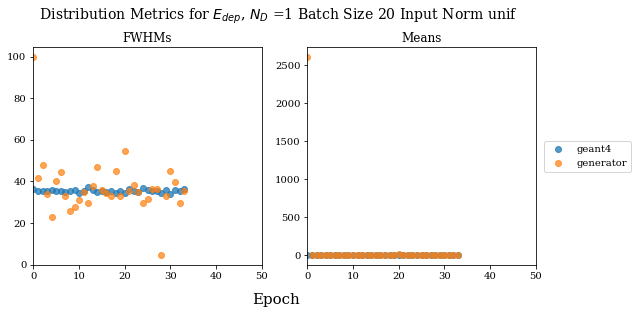

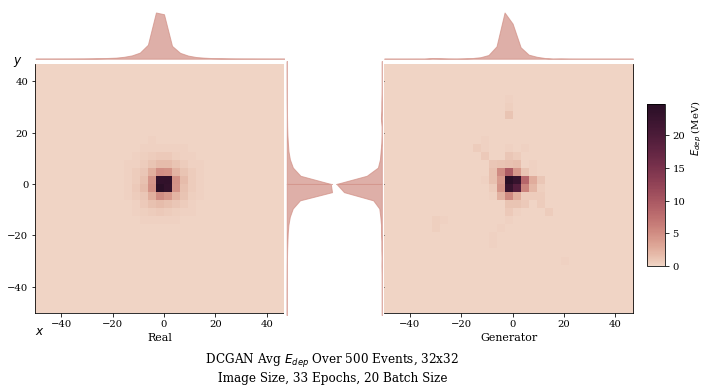

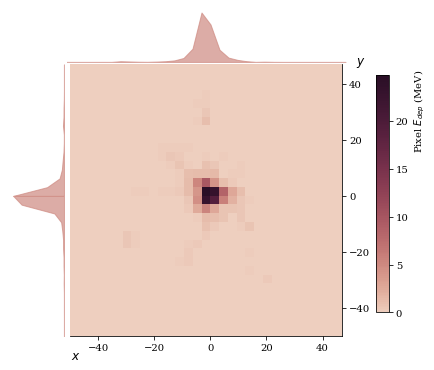

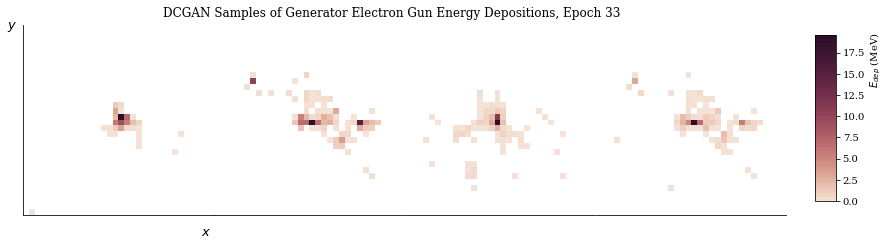

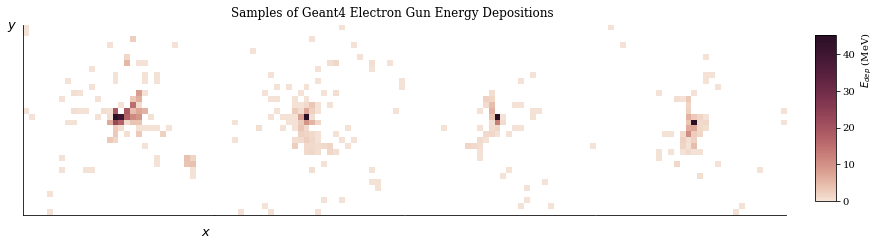

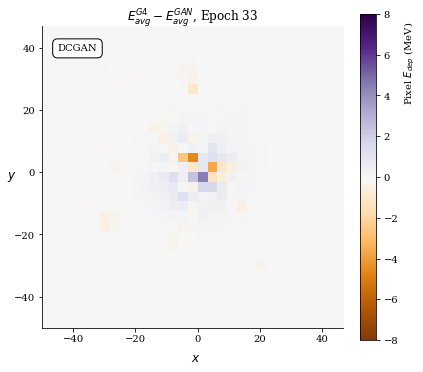

[33/50][0/1500] Loss_D: 0.1131 Loss_G: 9.7659 D(x): 0.9243 D(G(z)): 0.0000 / 0.0001
[33/50][100/1500] Loss_D: 0.0459 Loss_G: 5.5549 D(x): 0.9780 D(G(z)): 0.0127 / 0.0050
[33/50][200/1500] Loss_D: 0.1105 Loss_G: 11.2337 D(x): 0.9345 D(G(z)): 0.0107 / 0.0005
[33/50][300/1500] Loss_D: 0.0433 Loss_G: 6.7534 D(x): 0.9971 D(G(z)): 0.0238 / 0.0048
[33/50][400/1500] Loss_D: 0.0272 Loss_G: 7.7725 D(x): 0.9993 D(G(z)): 0.0107 / 0.0017
[33/50][500/1500] Loss_D: 0.0303 Loss_G: 4.9501 D(x): 0.9998 D(G(z)): 0.0144 / 0.0118
[33/50][600/1500] Loss_D: 0.0350 Loss_G: 5.0038 D(x): 1.0000 D(G(z)): 0.0120 / 0.0097
[33/50][700/1500] Loss_D: 0.1297 Loss_G: 6.4577 D(x): 0.9992 D(G(z)): 0.0979 / 0.0038
[33/50][800/1500] Loss_D: 0.0744 Loss_G: 5.4028 D(x): 0.9628 D(G(z)): 0.0208 / 0.0093
[33/50][900/1500] Loss_D: 0.0918 Loss_G: 5.5482 D(x): 0.9995 D(G(z)): 0.0716 / 0.0061
[33/50][1000/1500] Loss_D: 0.1421 Loss_G: 3.2299 D(x): 0.9393 D(G(z)): 0.0337 / 0.0549
[33/50][1100/1500] Loss_D: 0.0491 Loss_G: 4.5818 D(x):

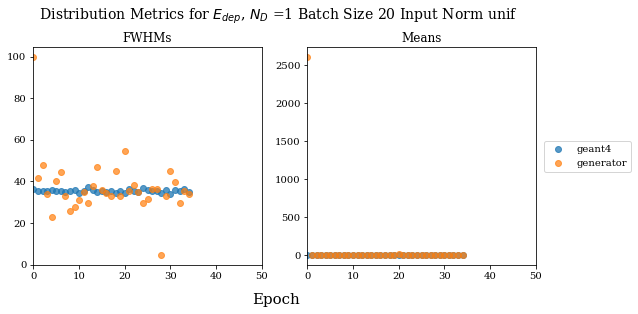

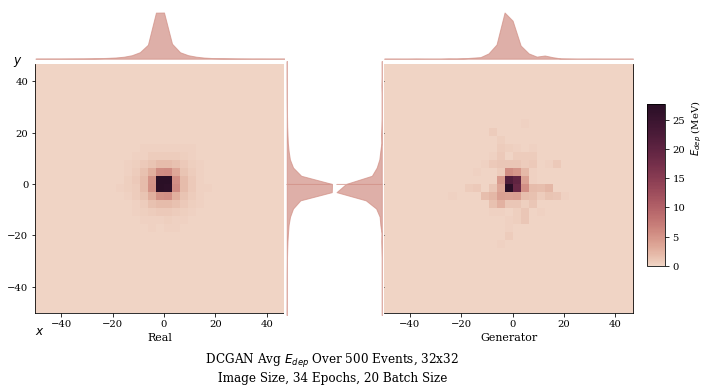

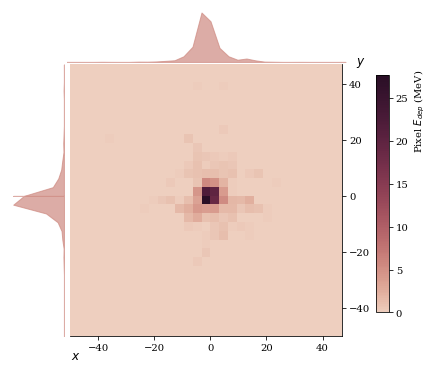

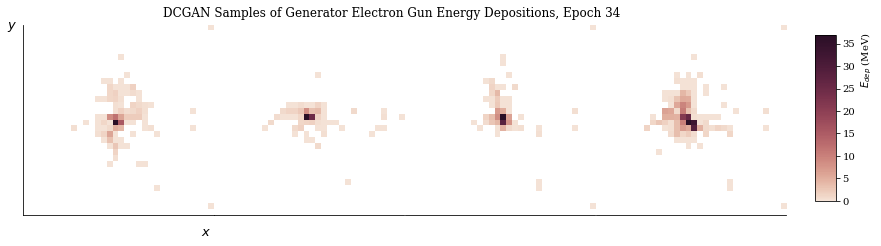

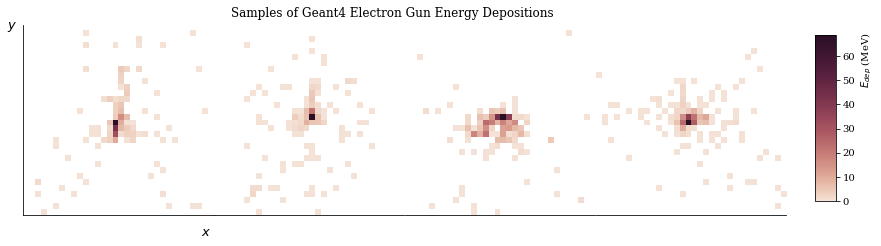

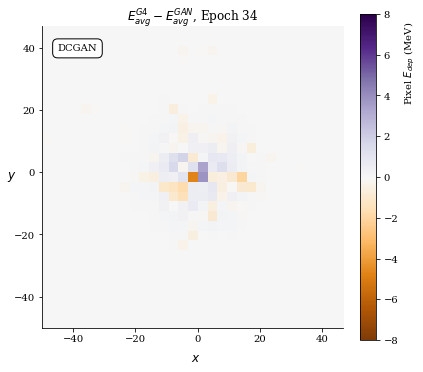

[34/50][0/1500] Loss_D: 0.0415 Loss_G: 5.0335 D(x): 0.9888 D(G(z)): 0.0164 / 0.0098
[34/50][100/1500] Loss_D: 0.0513 Loss_G: 6.3213 D(x): 0.9704 D(G(z)): 0.0017 / 0.0027
[34/50][200/1500] Loss_D: 0.1611 Loss_G: 8.4582 D(x): 1.0000 D(G(z)): 0.1201 / 0.0009
[34/50][300/1500] Loss_D: 0.0499 Loss_G: 4.7426 D(x): 0.9980 D(G(z)): 0.0350 / 0.0103
[34/50][400/1500] Loss_D: 0.0735 Loss_G: 10.3758 D(x): 0.9529 D(G(z)): 0.0003 / 0.0001
[34/50][500/1500] Loss_D: 0.0281 Loss_G: 5.1785 D(x): 0.9968 D(G(z)): 0.0108 / 0.0097
[34/50][600/1500] Loss_D: 0.0203 Loss_G: 7.3214 D(x): 0.9995 D(G(z)): 0.0033 / 0.0011
[34/50][700/1500] Loss_D: 0.0573 Loss_G: 9.8351 D(x): 0.9649 D(G(z)): 0.0004 / 0.0005
[34/50][800/1500] Loss_D: 0.0498 Loss_G: 4.7165 D(x): 0.9865 D(G(z)): 0.0238 / 0.0126
[34/50][900/1500] Loss_D: 0.0247 Loss_G: 5.7785 D(x): 0.9995 D(G(z)): 0.0080 / 0.0040
[34/50][1000/1500] Loss_D: 0.3592 Loss_G: 2.5290 D(x): 0.7826 D(G(z)): 0.0179 / 0.0922
[34/50][1100/1500] Loss_D: 0.1559 Loss_G: 3.6628 D(x):

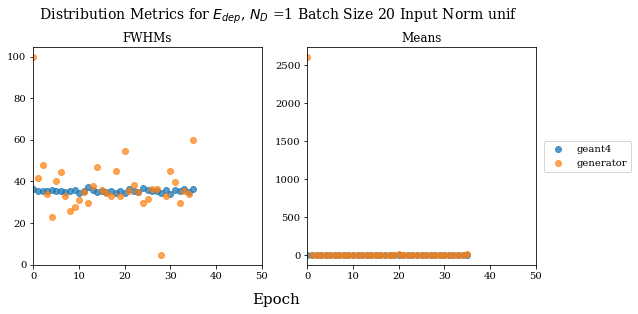

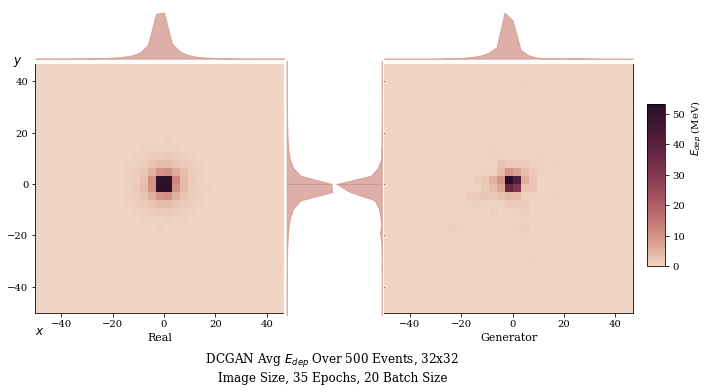

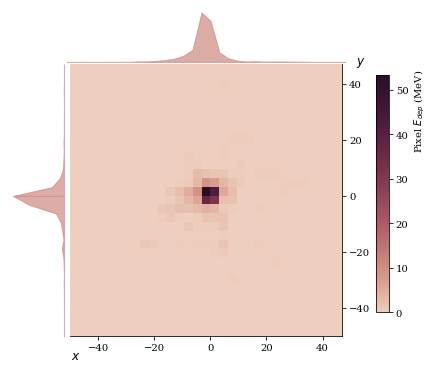

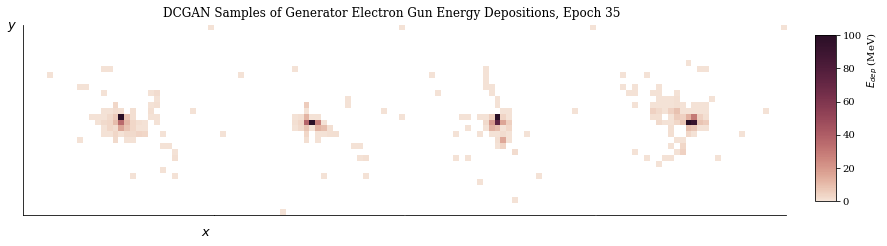

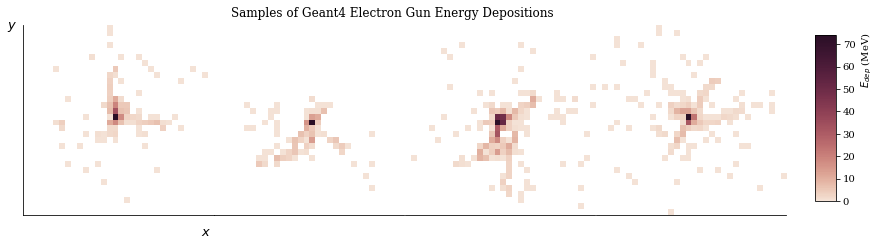

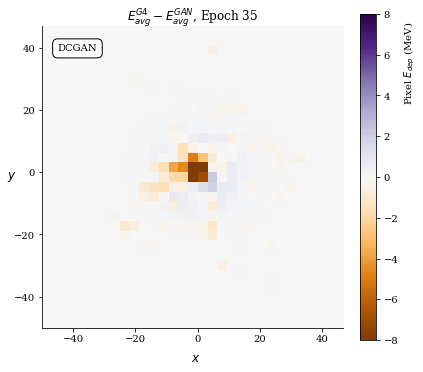

[35/50][0/1500] Loss_D: 0.2420 Loss_G: 6.1530 D(x): 0.9247 D(G(z)): 0.0849 / 0.0036
[35/50][100/1500] Loss_D: 0.0739 Loss_G: 4.3702 D(x): 0.9558 D(G(z)): 0.0110 / 0.0175
[35/50][200/1500] Loss_D: 0.1602 Loss_G: 3.6035 D(x): 0.8985 D(G(z)): 0.0097 / 0.0458
[35/50][300/1500] Loss_D: 0.0429 Loss_G: 4.6991 D(x): 0.9987 D(G(z)): 0.0279 / 0.0116
[35/50][400/1500] Loss_D: 0.0253 Loss_G: 7.1583 D(x): 0.9979 D(G(z)): 0.0090 / 0.0020
[35/50][500/1500] Loss_D: 0.2073 Loss_G: 7.3125 D(x): 0.9998 D(G(z)): 0.1698 / 0.0010
[35/50][600/1500] Loss_D: 0.0297 Loss_G: 5.4248 D(x): 0.9999 D(G(z)): 0.0137 / 0.0068
[35/50][700/1500] Loss_D: 0.0299 Loss_G: 5.8689 D(x): 0.9867 D(G(z)): 0.0033 / 0.0041
[35/50][800/1500] Loss_D: 0.1175 Loss_G: 3.9676 D(x): 0.9368 D(G(z)): 0.0287 / 0.0287
[35/50][900/1500] Loss_D: 0.0204 Loss_G: 6.4538 D(x): 0.9987 D(G(z)): 0.0026 / 0.0022
[35/50][1000/1500] Loss_D: 0.0905 Loss_G: 5.2282 D(x): 0.9839 D(G(z)): 0.0583 / 0.0088
[35/50][1100/1500] Loss_D: 0.1854 Loss_G: 4.5655 D(x): 

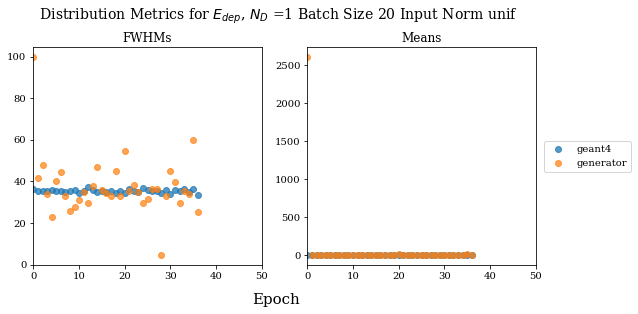

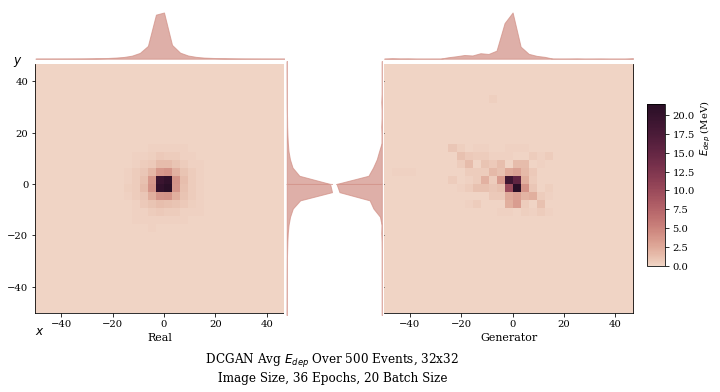

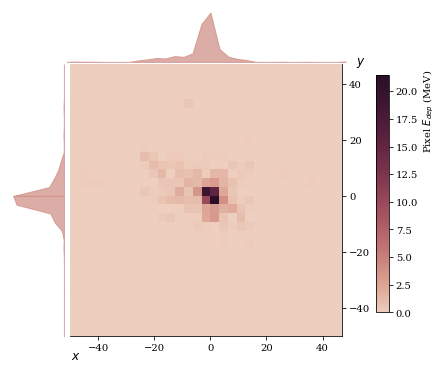

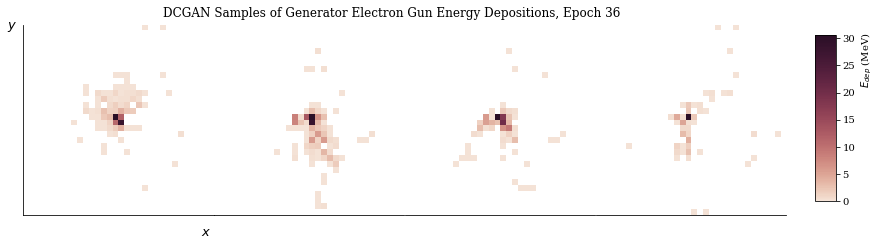

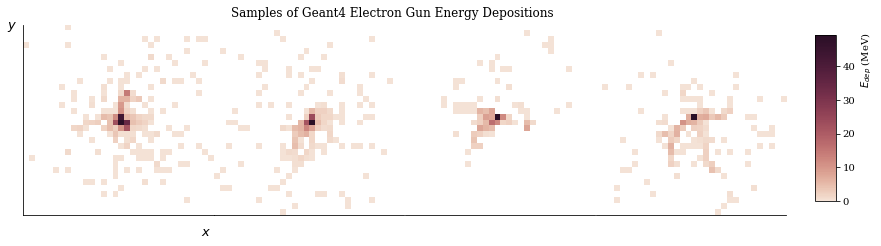

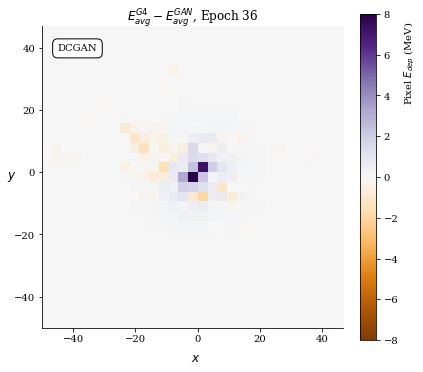

[36/50][0/1500] Loss_D: 0.0362 Loss_G: 5.6612 D(x): 0.9911 D(G(z)): 0.0150 / 0.0072
[36/50][100/1500] Loss_D: 0.0448 Loss_G: 5.0437 D(x): 0.9752 D(G(z)): 0.0050 / 0.0120
[36/50][200/1500] Loss_D: 0.0744 Loss_G: 4.9564 D(x): 0.9488 D(G(z)): 0.0080 / 0.0144
[36/50][300/1500] Loss_D: 0.0218 Loss_G: 7.1182 D(x): 0.9982 D(G(z)): 0.0020 / 0.0012
[36/50][400/1500] Loss_D: 0.0597 Loss_G: 5.7232 D(x): 0.9993 D(G(z)): 0.0433 / 0.0061
[36/50][500/1500] Loss_D: 0.0328 Loss_G: 7.1379 D(x): 0.9932 D(G(z)): 0.0107 / 0.0013
[36/50][600/1500] Loss_D: 0.0678 Loss_G: 4.7913 D(x): 0.9999 D(G(z)): 0.0507 / 0.0094
[36/50][700/1500] Loss_D: 0.0715 Loss_G: 4.5527 D(x): 0.9610 D(G(z)): 0.0207 / 0.0222
[36/50][800/1500] Loss_D: 0.5177 Loss_G: 3.7561 D(x): 0.8565 D(G(z)): 0.0046 / 0.0504
[36/50][900/1500] Loss_D: 0.0238 Loss_G: 9.8221 D(x): 0.9964 D(G(z)): 0.0037 / 0.0003
[36/50][1000/1500] Loss_D: 0.0625 Loss_G: 3.8154 D(x): 0.9702 D(G(z)): 0.0188 / 0.0329
[36/50][1100/1500] Loss_D: 0.0422 Loss_G: 4.9575 D(x): 

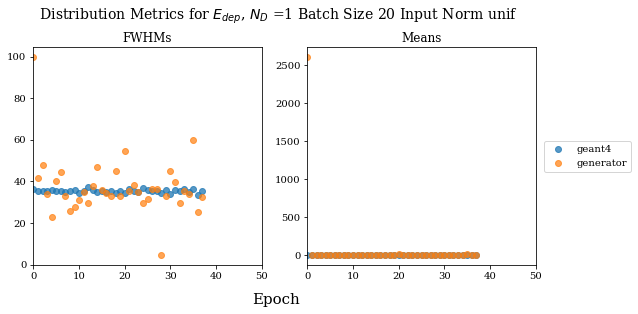

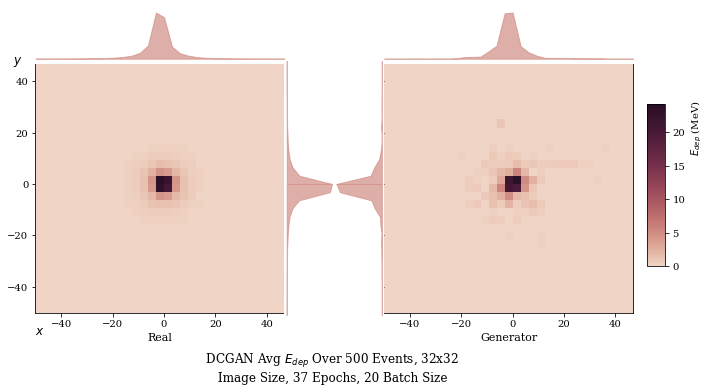

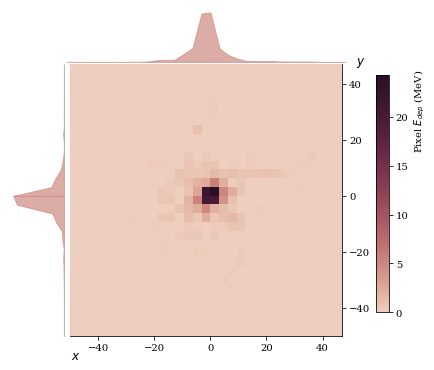

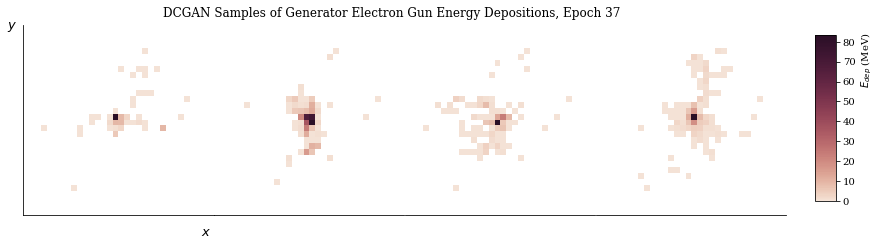

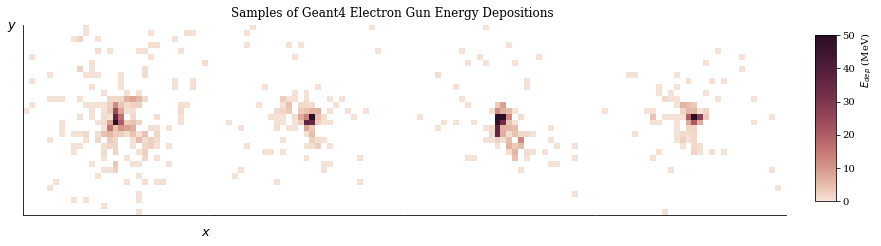

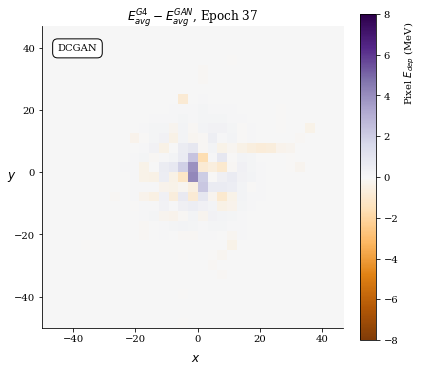

[37/50][0/1500] Loss_D: 0.1602 Loss_G: 8.9429 D(x): 0.8845 D(G(z)): 0.0001 / 0.0002
[37/50][100/1500] Loss_D: 0.2502 Loss_G: 3.8906 D(x): 0.8396 D(G(z)): 0.0097 / 0.0781
[37/50][200/1500] Loss_D: 0.1354 Loss_G: 5.0202 D(x): 0.9399 D(G(z)): 0.0070 / 0.0287
[37/50][300/1500] Loss_D: 0.0351 Loss_G: 4.7948 D(x): 0.9979 D(G(z)): 0.0201 / 0.0110
[37/50][400/1500] Loss_D: 0.0481 Loss_G: 8.7165 D(x): 0.9712 D(G(z)): 0.0004 / 0.0004
[37/50][500/1500] Loss_D: 0.0567 Loss_G: 5.1005 D(x): 1.0000 D(G(z)): 0.0354 / 0.0177
[37/50][600/1500] Loss_D: 0.0340 Loss_G: 5.1813 D(x): 0.9999 D(G(z)): 0.0162 / 0.0089
[37/50][700/1500] Loss_D: 0.0275 Loss_G: 5.1990 D(x): 0.9931 D(G(z)): 0.0087 / 0.0069
[37/50][800/1500] Loss_D: 0.0742 Loss_G: 4.4557 D(x): 0.9618 D(G(z)): 0.0171 / 0.0146
[37/50][900/1500] Loss_D: 0.0375 Loss_G: 4.8508 D(x): 0.9988 D(G(z)): 0.0207 / 0.0099
[37/50][1000/1500] Loss_D: 0.0497 Loss_G: 4.4434 D(x): 0.9823 D(G(z)): 0.0110 / 0.0265
[37/50][1100/1500] Loss_D: 0.0251 Loss_G: 4.3478 D(x): 

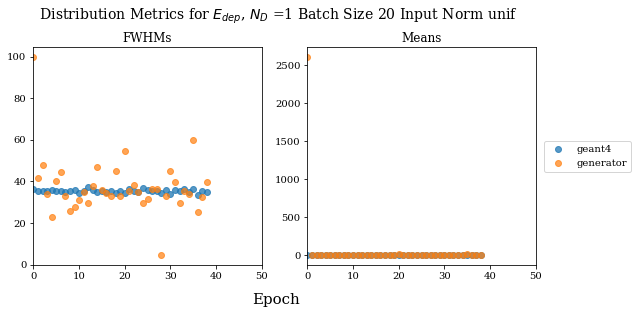

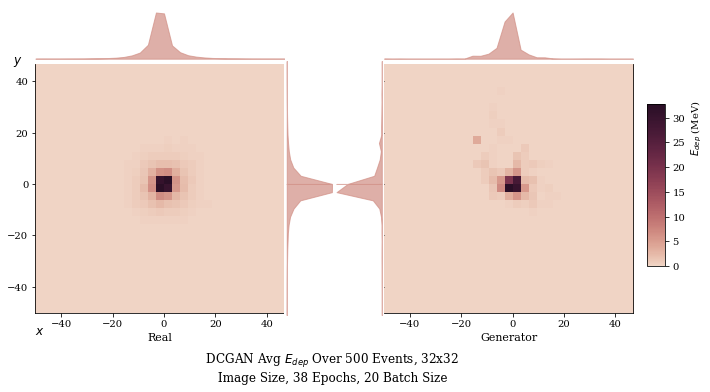

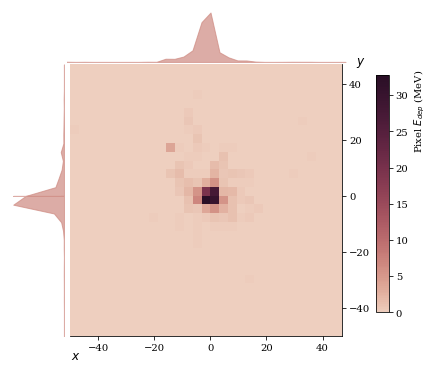

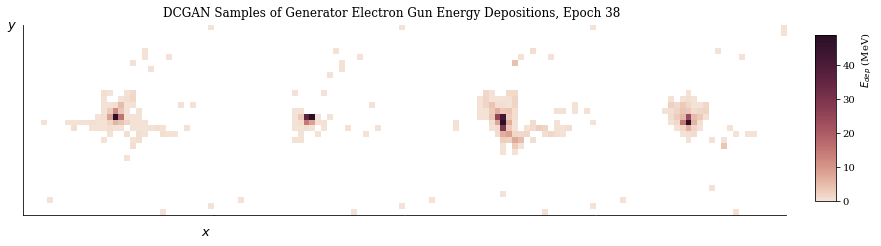

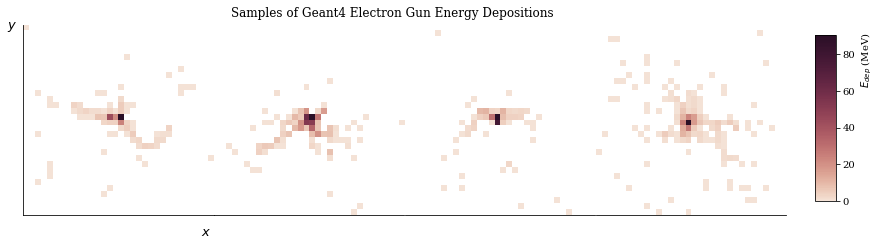

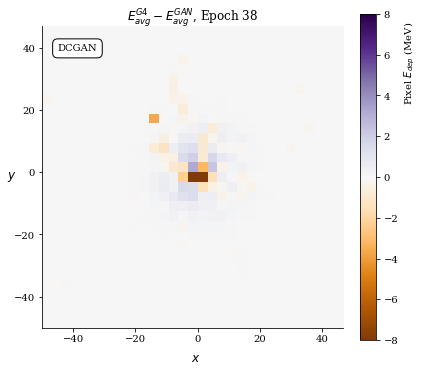

[38/50][0/1500] Loss_D: 0.0404 Loss_G: 4.6554 D(x): 0.9931 D(G(z)): 0.0193 / 0.0122
[38/50][100/1500] Loss_D: 0.1483 Loss_G: 7.1182 D(x): 0.9878 D(G(z)): 0.0931 / 0.0022
[38/50][200/1500] Loss_D: 0.1005 Loss_G: 5.5454 D(x): 0.9373 D(G(z)): 0.0033 / 0.0079
[38/50][300/1500] Loss_D: 0.0246 Loss_G: 5.4913 D(x): 0.9983 D(G(z)): 0.0098 / 0.0059
[38/50][400/1500] Loss_D: 0.0639 Loss_G: 3.9873 D(x): 0.9995 D(G(z)): 0.0483 / 0.0234
[38/50][500/1500] Loss_D: 0.8076 Loss_G: 1.8062 D(x): 0.6049 D(G(z)): 0.0376 / 0.2696
[38/50][600/1500] Loss_D: 0.1451 Loss_G: 6.5708 D(x): 0.9970 D(G(z)): 0.1142 / 0.0023
[38/50][700/1500] Loss_D: 0.1381 Loss_G: 5.9087 D(x): 0.9979 D(G(z)): 0.1086 / 0.0043
[38/50][800/1500] Loss_D: 0.0724 Loss_G: 5.2570 D(x): 0.9485 D(G(z)): 0.0067 / 0.0066
[38/50][900/1500] Loss_D: 0.0524 Loss_G: 5.5893 D(x): 0.9999 D(G(z)): 0.0342 / 0.0074
[38/50][1000/1500] Loss_D: 0.7172 Loss_G: 13.4013 D(x): 0.9985 D(G(z)): 0.4697 / 0.0000
[38/50][1100/1500] Loss_D: 0.3248 Loss_G: 3.2034 D(x):

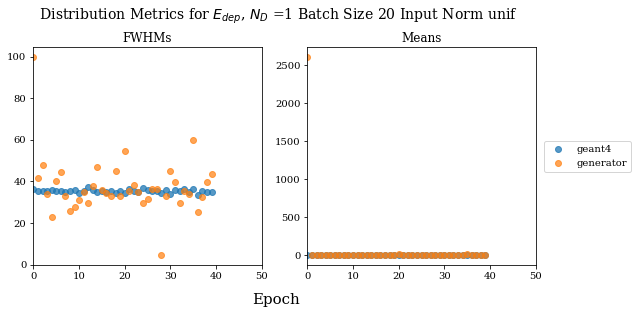

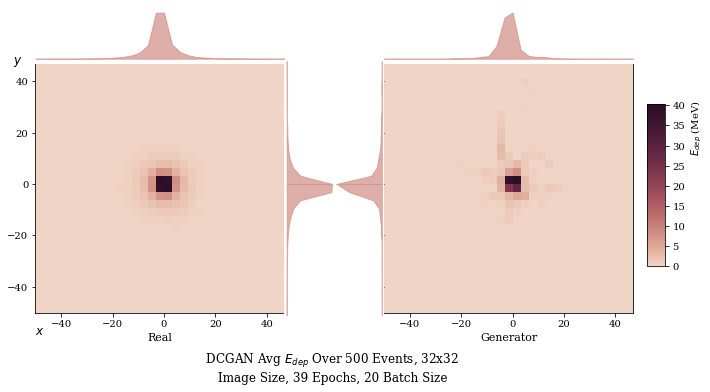

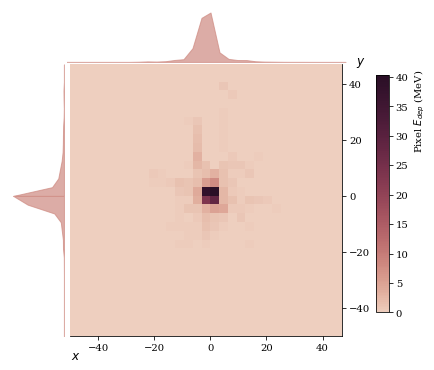

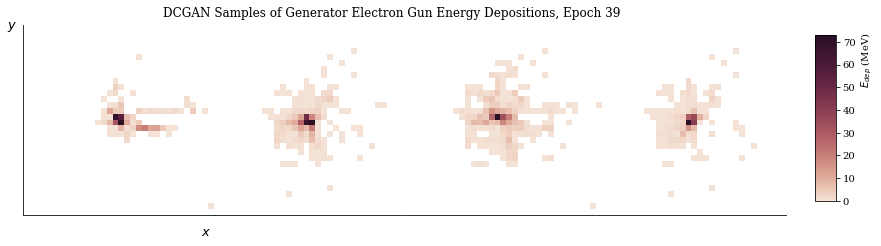

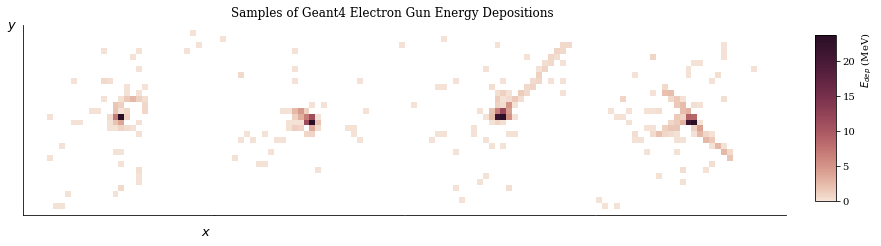

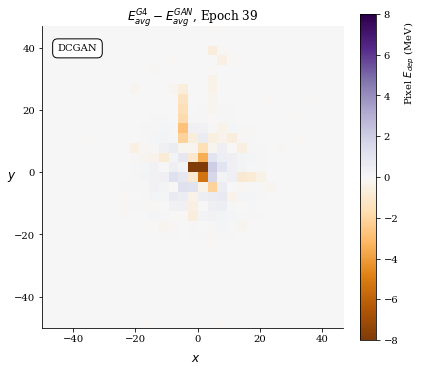

[39/50][0/1500] Loss_D: 0.0391 Loss_G: 11.5599 D(x): 0.9800 D(G(z)): 0.0001 / 0.0001
[39/50][100/1500] Loss_D: 0.4339 Loss_G: 2.0885 D(x): 0.8018 D(G(z)): 0.0282 / 0.1634
[39/50][200/1500] Loss_D: 0.0873 Loss_G: 4.9000 D(x): 0.9377 D(G(z)): 0.0046 / 0.0113
[39/50][300/1500] Loss_D: 0.0208 Loss_G: 5.8767 D(x): 0.9970 D(G(z)): 0.0028 / 0.0040
[39/50][400/1500] Loss_D: 0.0190 Loss_G: 11.4311 D(x): 0.9989 D(G(z)): 0.0005 / 0.0000
[39/50][500/1500] Loss_D: 0.0502 Loss_G: 6.0248 D(x): 0.9720 D(G(z)): 0.0073 / 0.0040
[39/50][600/1500] Loss_D: 0.0341 Loss_G: 11.2010 D(x): 0.9818 D(G(z)): 0.0018 / 0.0001
[39/50][700/1500] Loss_D: 0.0277 Loss_G: 6.7246 D(x): 0.9913 D(G(z)): 0.0064 / 0.0018
[39/50][800/1500] Loss_D: 0.0229 Loss_G: 6.1124 D(x): 0.9975 D(G(z)): 0.0061 / 0.0040
[39/50][900/1500] Loss_D: 0.2492 Loss_G: 6.9203 D(x): 1.0000 D(G(z)): 0.1543 / 0.0192
[39/50][1000/1500] Loss_D: 0.0272 Loss_G: 6.9243 D(x): 0.9887 D(G(z)): 0.0009 / 0.0011
[39/50][1100/1500] Loss_D: 0.0479 Loss_G: 5.9983 D(x

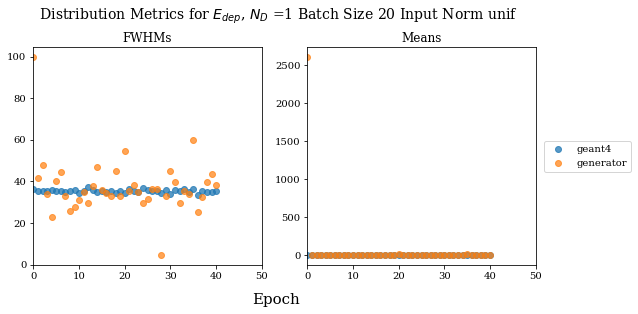

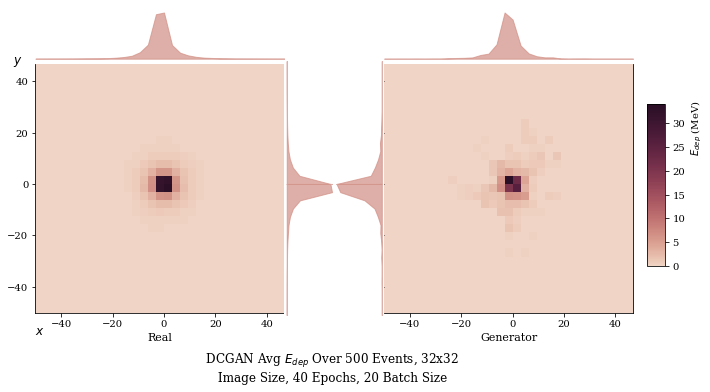

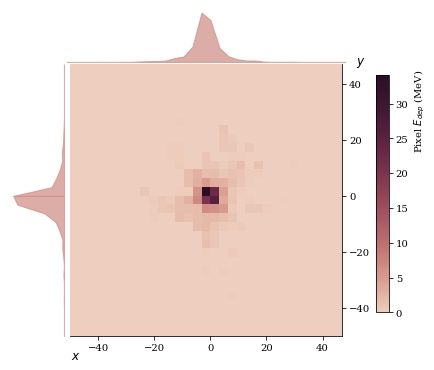

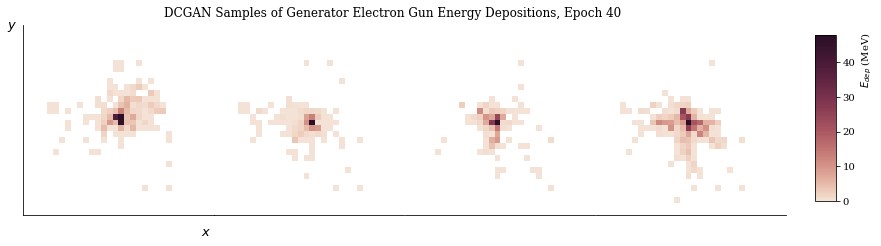

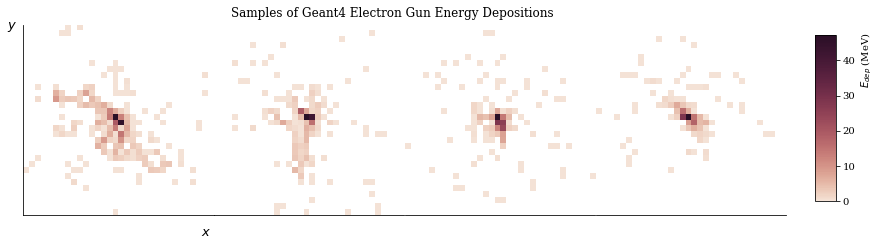

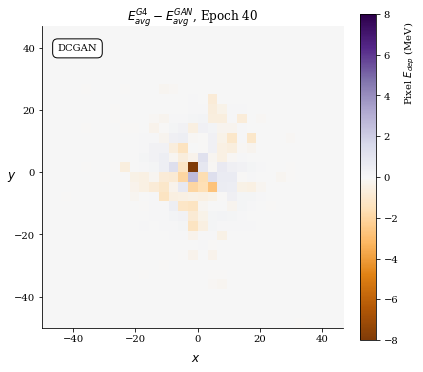

[40/50][0/1500] Loss_D: 0.2294 Loss_G: 7.1744 D(x): 0.8251 D(G(z)): 0.0001 / 0.0012
[40/50][100/1500] Loss_D: 0.0220 Loss_G: 6.1727 D(x): 0.9978 D(G(z)): 0.0045 / 0.0037
[40/50][200/1500] Loss_D: 0.0307 Loss_G: 7.4071 D(x): 0.9840 D(G(z)): 0.0008 / 0.0009
[40/50][300/1500] Loss_D: 0.0204 Loss_G: 5.7174 D(x): 0.9989 D(G(z)): 0.0043 / 0.0040
[40/50][400/1500] Loss_D: 0.1487 Loss_G: 8.2526 D(x): 0.9993 D(G(z)): 0.1143 / 0.0008
[40/50][500/1500] Loss_D: 0.0487 Loss_G: 4.8298 D(x): 0.9985 D(G(z)): 0.0320 / 0.0142
[40/50][600/1500] Loss_D: 0.0214 Loss_G: 7.6693 D(x): 0.9989 D(G(z)): 0.0007 / 0.0006
[40/50][700/1500] Loss_D: 0.0269 Loss_G: 6.5519 D(x): 0.9915 D(G(z)): 0.0051 / 0.0020
[40/50][800/1500] Loss_D: 0.2365 Loss_G: 2.8563 D(x): 0.8648 D(G(z)): 0.0095 / 0.0701
[40/50][900/1500] Loss_D: 0.0262 Loss_G: 5.9396 D(x): 0.9995 D(G(z)): 0.0074 / 0.0046
[40/50][1000/1500] Loss_D: 0.0242 Loss_G: 5.9991 D(x): 0.9998 D(G(z)): 0.0045 / 0.0031
[40/50][1100/1500] Loss_D: 0.1068 Loss_G: 5.9603 D(x): 

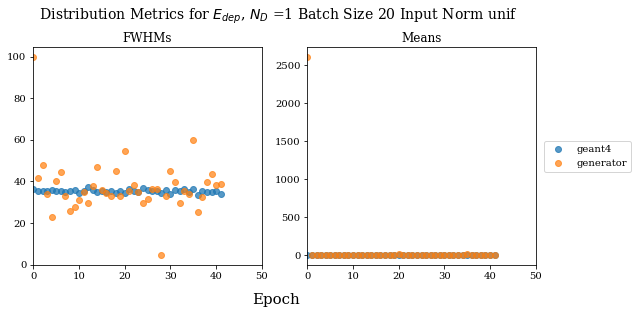

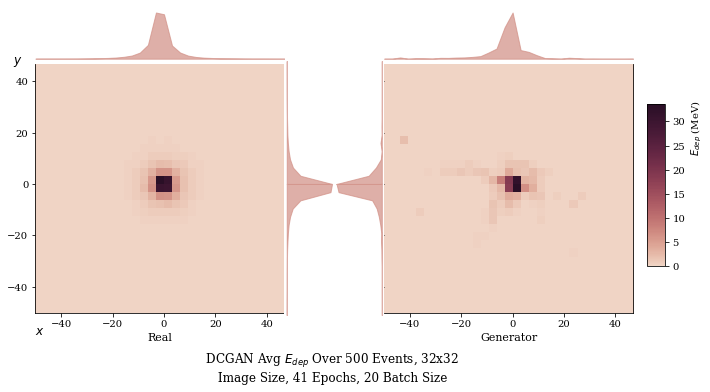

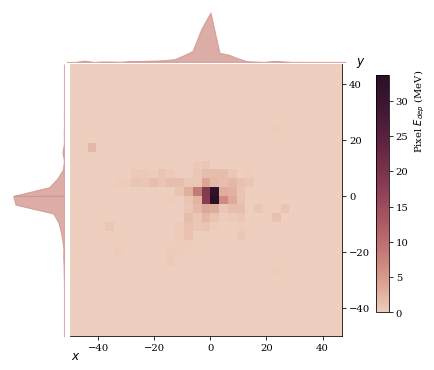

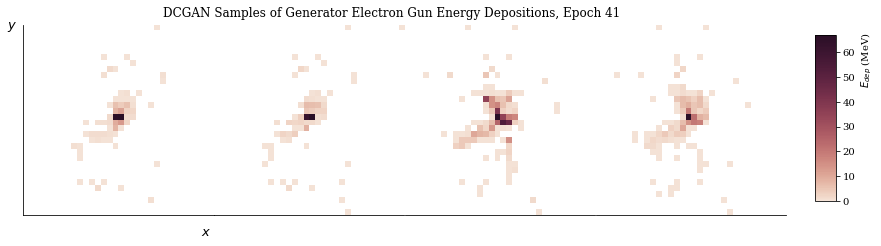

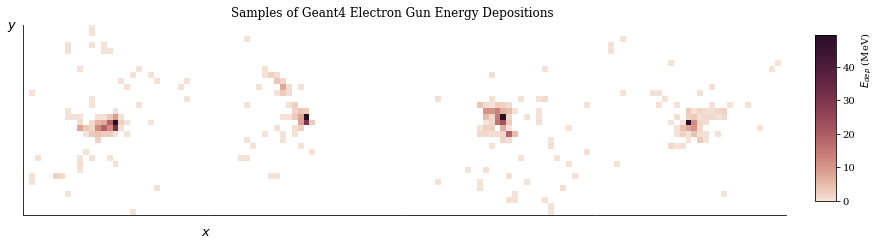

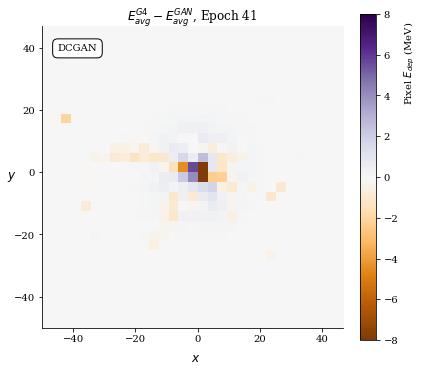

[41/50][0/1500] Loss_D: 0.0436 Loss_G: 9.7404 D(x): 0.9725 D(G(z)): 0.0016 / 0.0001
[41/50][100/1500] Loss_D: 0.1002 Loss_G: 4.0822 D(x): 0.9267 D(G(z)): 0.0073 / 0.0204
[41/50][200/1500] Loss_D: 0.0213 Loss_G: 6.6019 D(x): 0.9975 D(G(z)): 0.0031 / 0.0020
[41/50][300/1500] Loss_D: 0.0252 Loss_G: 6.0217 D(x): 0.9927 D(G(z)): 0.0031 / 0.0043
[41/50][400/1500] Loss_D: 0.2134 Loss_G: 7.8394 D(x): 0.9997 D(G(z)): 0.1444 / 0.0006
[41/50][500/1500] Loss_D: 0.0460 Loss_G: 6.0077 D(x): 0.9970 D(G(z)): 0.0273 / 0.0061
[41/50][600/1500] Loss_D: 0.1910 Loss_G: 6.4134 D(x): 1.0000 D(G(z)): 0.1467 / 0.0029
[41/50][700/1500] Loss_D: 0.0371 Loss_G: 5.9335 D(x): 0.9945 D(G(z)): 0.0169 / 0.0054
[41/50][800/1500] Loss_D: 0.0295 Loss_G: 5.8839 D(x): 0.9981 D(G(z)): 0.0118 / 0.0050
[41/50][900/1500] Loss_D: 0.2120 Loss_G: 3.4457 D(x): 0.9979 D(G(z)): 0.1727 / 0.0346
[41/50][1000/1500] Loss_D: 0.0413 Loss_G: 6.1213 D(x): 0.9768 D(G(z)): 0.0031 / 0.0035
[41/50][1100/1500] Loss_D: 0.1011 Loss_G: 4.2959 D(x): 

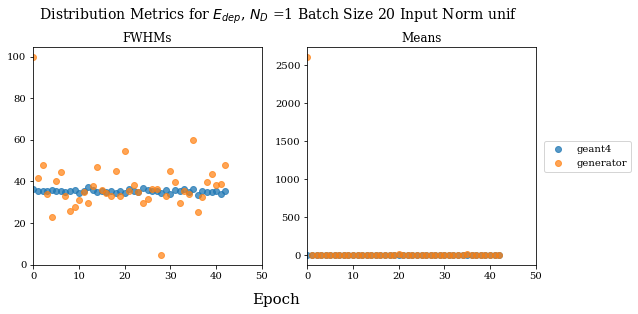

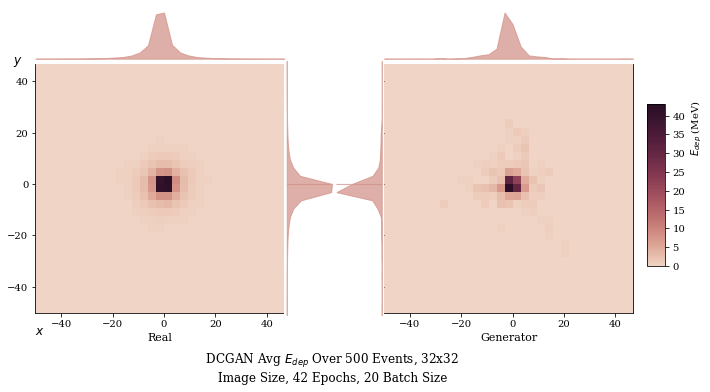

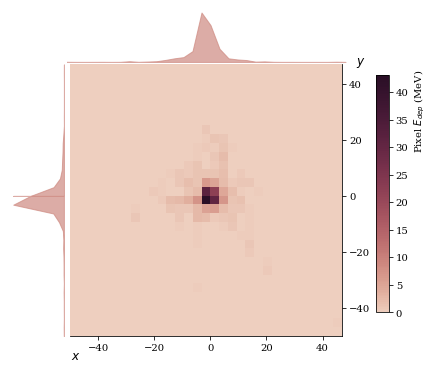

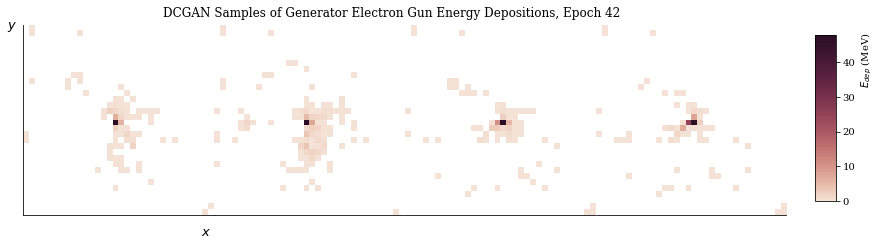

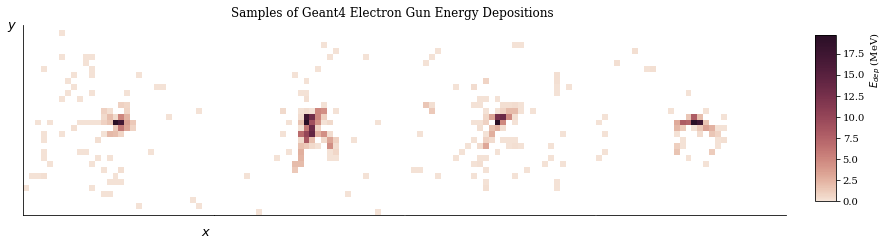

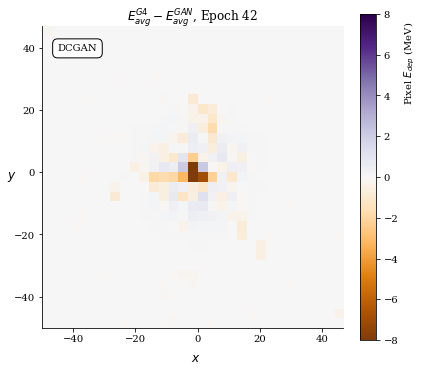

[42/50][0/1500] Loss_D: 0.1450 Loss_G: 11.0034 D(x): 0.8975 D(G(z)): 0.0000 / 0.0000
[42/50][100/1500] Loss_D: 0.0747 Loss_G: 4.1772 D(x): 0.9992 D(G(z)): 0.0564 / 0.0233
[42/50][200/1500] Loss_D: 0.4191 Loss_G: 2.4930 D(x): 0.7123 D(G(z)): 0.0116 / 0.1576
[42/50][300/1500] Loss_D: 0.1186 Loss_G: 4.7511 D(x): 0.9164 D(G(z)): 0.0066 / 0.0104
[42/50][400/1500] Loss_D: 0.0395 Loss_G: 10.6928 D(x): 0.9776 D(G(z)): 0.0000 / 0.0000
[42/50][500/1500] Loss_D: 0.0214 Loss_G: 5.8268 D(x): 0.9969 D(G(z)): 0.0046 / 0.0036
[42/50][600/1500] Loss_D: 0.0180 Loss_G: 9.6971 D(x): 0.9984 D(G(z)): 0.0008 / 0.0001
[42/50][700/1500] Loss_D: 0.0359 Loss_G: 5.2042 D(x): 0.9874 D(G(z)): 0.0116 / 0.0077
[42/50][800/1500] Loss_D: 0.0331 Loss_G: 6.2704 D(x): 0.9930 D(G(z)): 0.0127 / 0.0043
[42/50][900/1500] Loss_D: 0.1147 Loss_G: 7.6792 D(x): 0.9503 D(G(z)): 0.0004 / 0.0008
[42/50][1000/1500] Loss_D: 0.1376 Loss_G: 4.3576 D(x): 0.9510 D(G(z)): 0.0144 / 0.0190
[42/50][1100/1500] Loss_D: 0.0923 Loss_G: 6.2128 D(x)

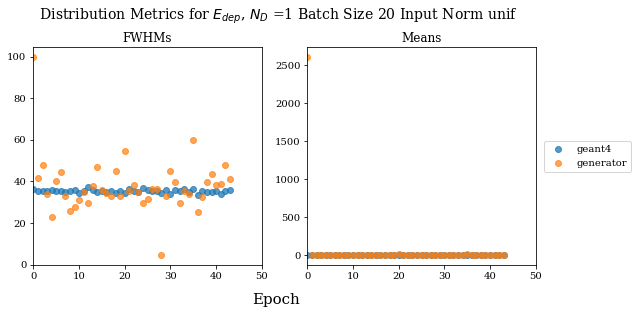

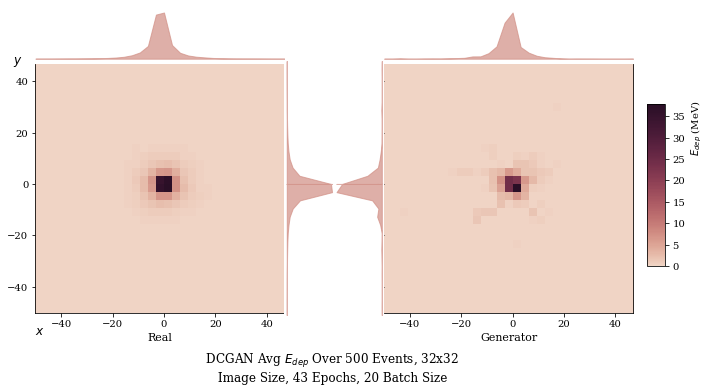

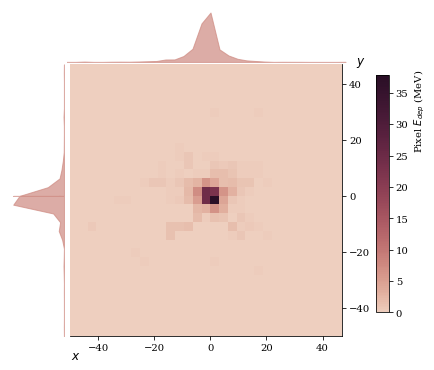

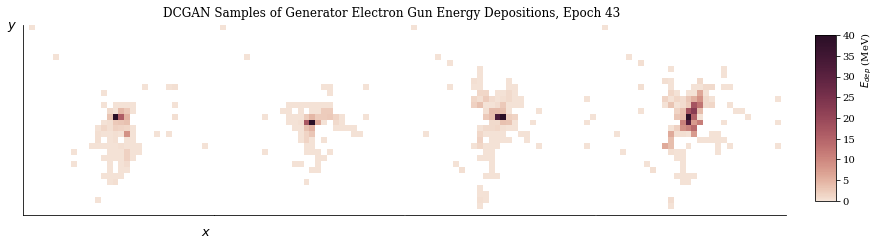

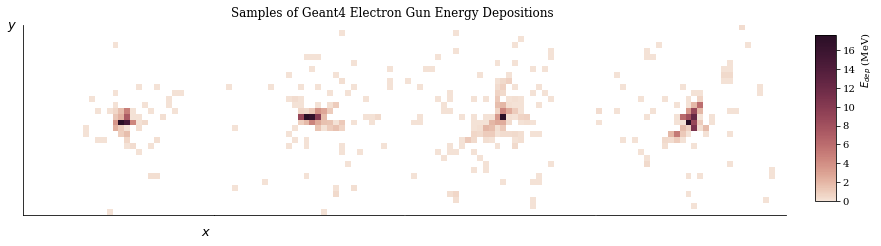

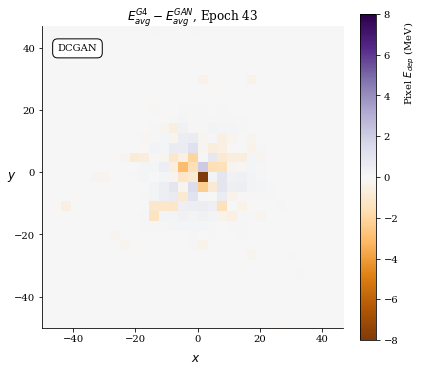

[43/50][0/1500] Loss_D: 0.3094 Loss_G: 6.1976 D(x): 0.9647 D(G(z)): 0.2187 / 0.0024
[43/50][100/1500] Loss_D: 0.0277 Loss_G: 6.4793 D(x): 0.9871 D(G(z)): 0.0022 / 0.0019
[43/50][200/1500] Loss_D: 0.1586 Loss_G: 5.1627 D(x): 0.9959 D(G(z)): 0.1332 / 0.0063
[43/50][300/1500] Loss_D: 0.0749 Loss_G: 3.7723 D(x): 0.9618 D(G(z)): 0.0254 / 0.0280
[43/50][400/1500] Loss_D: 0.0242 Loss_G: 5.9855 D(x): 0.9976 D(G(z)): 0.0082 / 0.0046
[43/50][500/1500] Loss_D: 0.1933 Loss_G: 5.3905 D(x): 0.9946 D(G(z)): 0.1581 / 0.0061
[43/50][600/1500] Loss_D: 0.0521 Loss_G: 5.9133 D(x): 1.0000 D(G(z)): 0.0305 / 0.0081
[43/50][700/1500] Loss_D: 0.1357 Loss_G: 5.3514 D(x): 0.9170 D(G(z)): 0.0040 / 0.0098
[43/50][800/1500] Loss_D: 0.0426 Loss_G: 5.3879 D(x): 0.9772 D(G(z)): 0.0045 / 0.0059
[43/50][900/1500] Loss_D: 0.0276 Loss_G: 5.8512 D(x): 0.9907 D(G(z)): 0.0029 / 0.0037
[43/50][1000/1500] Loss_D: 0.7041 Loss_G: 11.3031 D(x): 1.0000 D(G(z)): 0.4520 / 0.0000
[43/50][1100/1500] Loss_D: 0.0528 Loss_G: 6.3677 D(x):

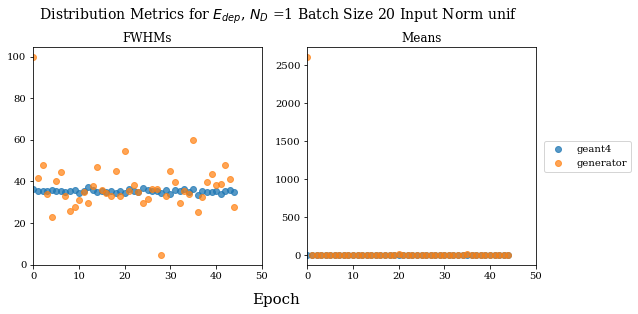

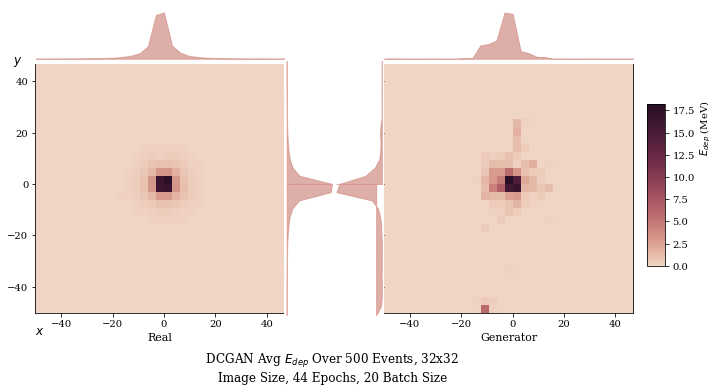

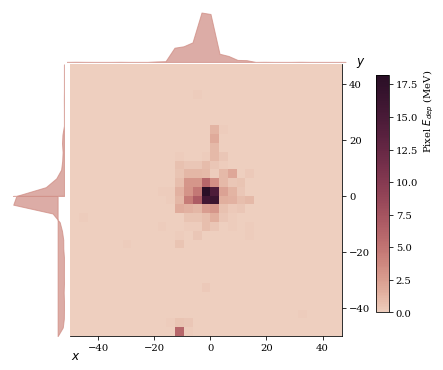

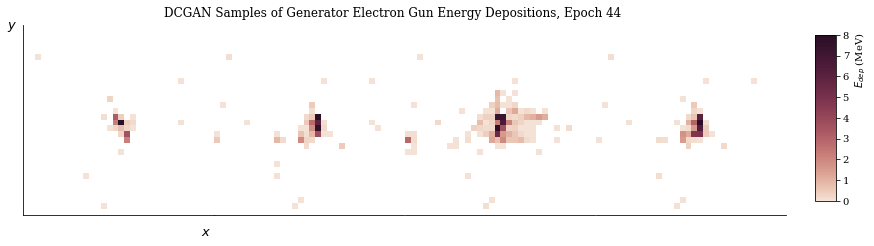

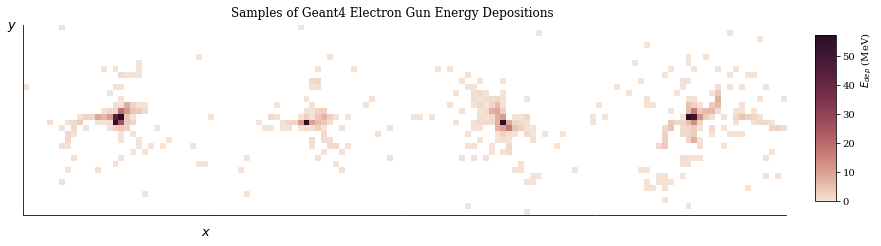

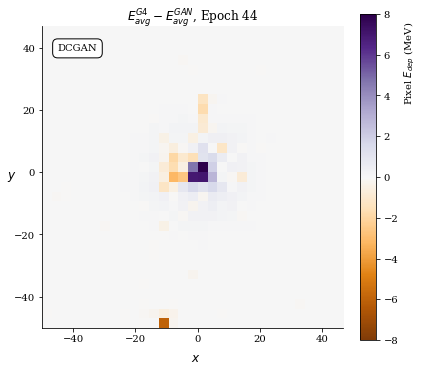

[44/50][0/1500] Loss_D: 0.0198 Loss_G: 8.7632 D(x): 0.9995 D(G(z)): 0.0012 / 0.0002
[44/50][100/1500] Loss_D: 0.0222 Loss_G: 10.7865 D(x): 0.9965 D(G(z)): 0.0001 / 0.0001
[44/50][200/1500] Loss_D: 0.0948 Loss_G: 5.6049 D(x): 0.9415 D(G(z)): 0.0039 / 0.0062
[44/50][300/1500] Loss_D: 0.1736 Loss_G: 8.4011 D(x): 0.8937 D(G(z)): 0.0007 / 0.0003
[44/50][400/1500] Loss_D: 0.0275 Loss_G: 5.3252 D(x): 0.9986 D(G(z)): 0.0111 / 0.0061
[44/50][500/1500] Loss_D: 0.0342 Loss_G: 6.8912 D(x): 0.9820 D(G(z)): 0.0032 / 0.0016
[44/50][600/1500] Loss_D: 0.0383 Loss_G: 5.0727 D(x): 0.9994 D(G(z)): 0.0189 / 0.0085
[44/50][700/1500] Loss_D: 0.0352 Loss_G: 4.6475 D(x): 0.9960 D(G(z)): 0.0173 / 0.0128
[44/50][800/1500] Loss_D: 0.0242 Loss_G: 6.4886 D(x): 0.9950 D(G(z)): 0.0038 / 0.0029
[44/50][900/1500] Loss_D: 0.0228 Loss_G: 10.1667 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[44/50][1000/1500] Loss_D: 0.0244 Loss_G: 6.1213 D(x): 0.9965 D(G(z)): 0.0060 / 0.0060
[44/50][1100/1500] Loss_D: 0.2762 Loss_G: 3.4192 D(x)

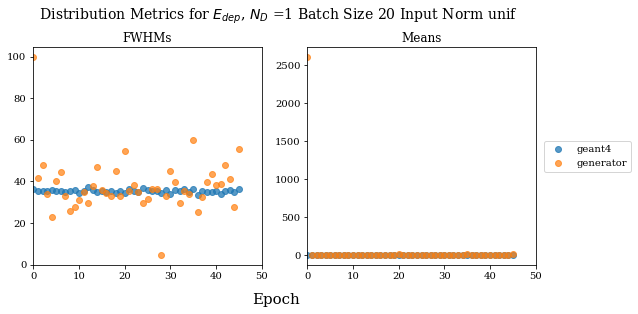

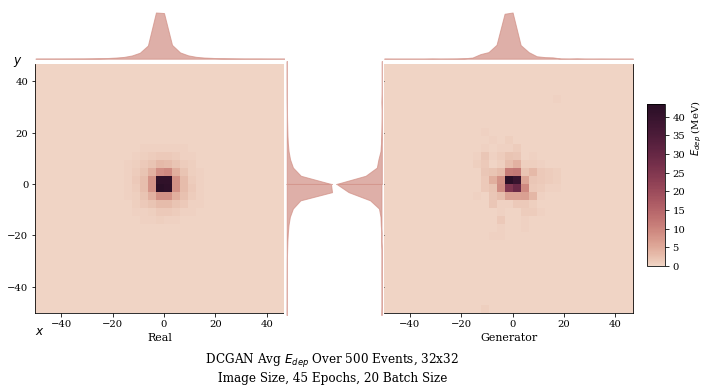

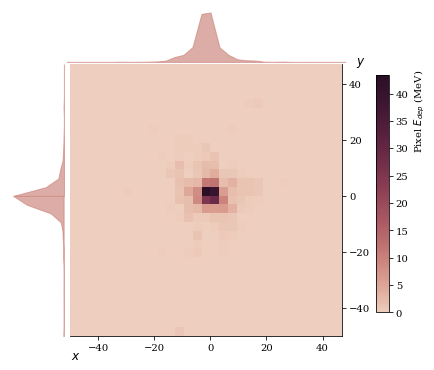

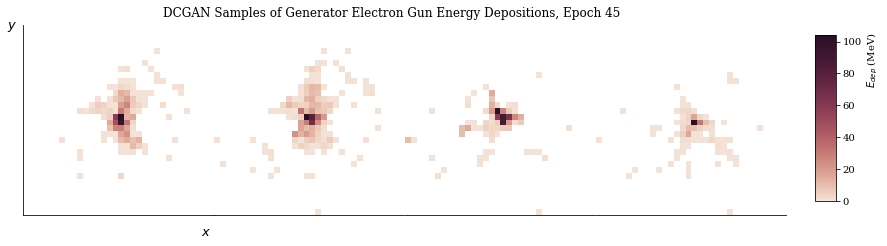

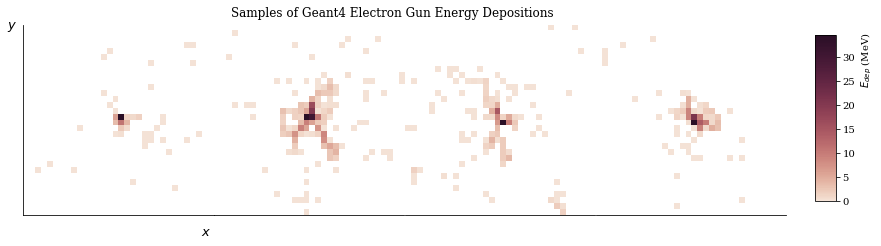

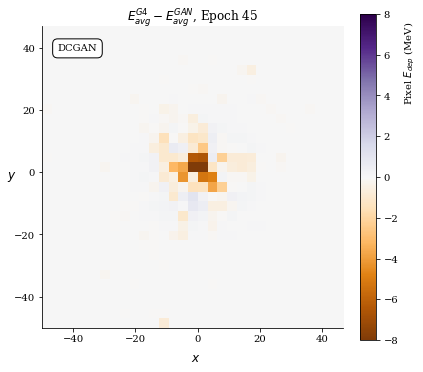

[45/50][0/1500] Loss_D: 0.0238 Loss_G: 6.1546 D(x): 0.9977 D(G(z)): 0.0076 / 0.0079
[45/50][100/1500] Loss_D: 0.0293 Loss_G: 5.6703 D(x): 0.9942 D(G(z)): 0.0106 / 0.0052
[45/50][200/1500] Loss_D: 0.0289 Loss_G: 6.5738 D(x): 0.9881 D(G(z)): 0.0022 / 0.0020
[45/50][300/1500] Loss_D: 0.0214 Loss_G: 6.3842 D(x): 0.9983 D(G(z)): 0.0032 / 0.0036
[45/50][400/1500] Loss_D: 0.0360 Loss_G: 4.8594 D(x): 0.9996 D(G(z)): 0.0197 / 0.0120
[45/50][500/1500] Loss_D: 0.0329 Loss_G: 4.3940 D(x): 0.9988 D(G(z)): 0.0163 / 0.0164
[45/50][600/1500] Loss_D: 0.0456 Loss_G: 19.1884 D(x): 0.9810 D(G(z)): 0.0000 / 0.0000
[45/50][700/1500] Loss_D: 0.0865 Loss_G: 4.9187 D(x): 0.9987 D(G(z)): 0.0689 / 0.0088
[45/50][800/1500] Loss_D: 0.0271 Loss_G: 5.4527 D(x): 0.9981 D(G(z)): 0.0122 / 0.0085
[45/50][900/1500] Loss_D: 0.0317 Loss_G: 5.9825 D(x): 0.9990 D(G(z)): 0.0139 / 0.0067
[45/50][1000/1500] Loss_D: 0.0664 Loss_G: 4.9023 D(x): 0.9964 D(G(z)): 0.0476 / 0.0117
[45/50][1100/1500] Loss_D: 0.1875 Loss_G: 4.4473 D(x):

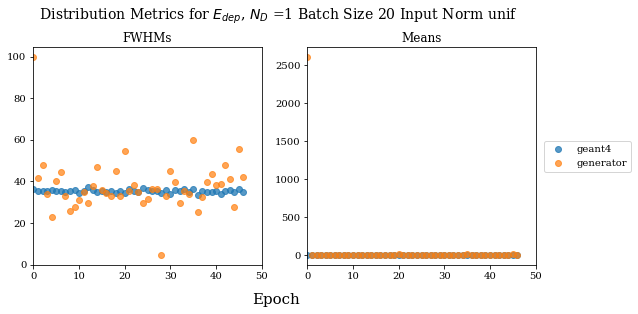

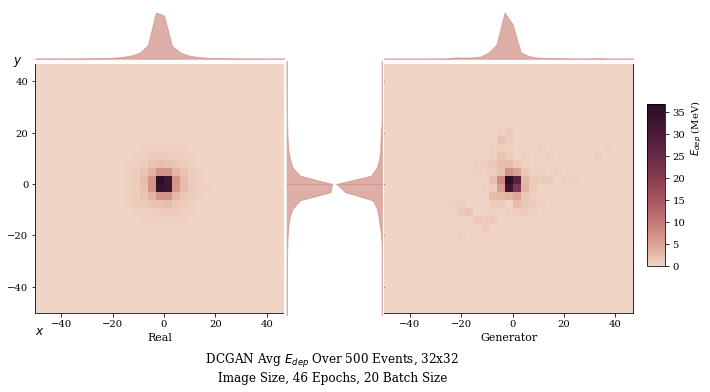

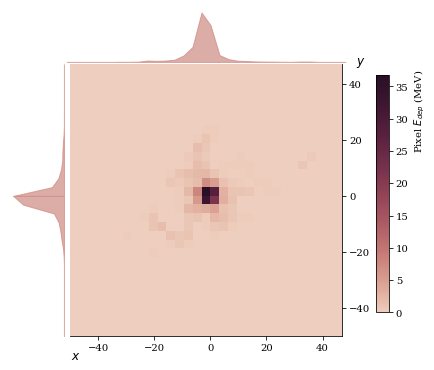

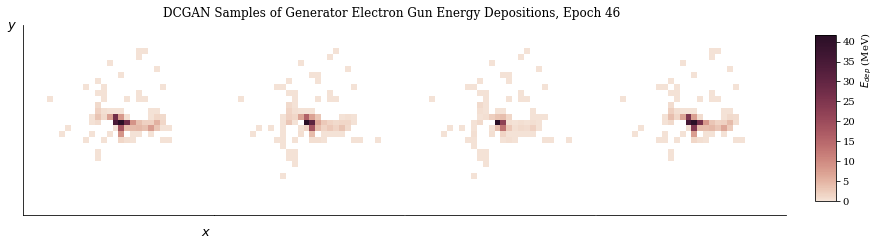

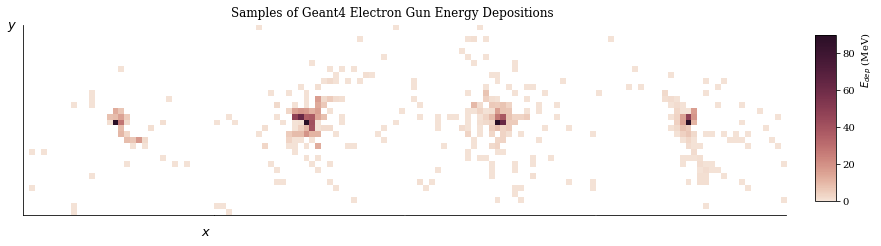

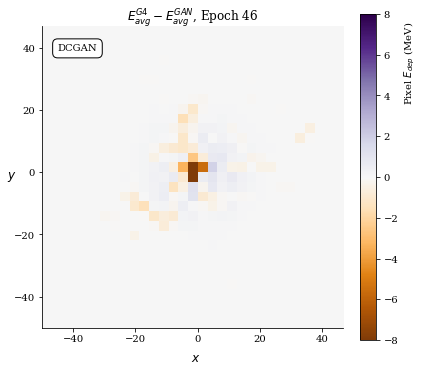

[46/50][0/1500] Loss_D: 0.0734 Loss_G: 9.1901 D(x): 0.9551 D(G(z)): 0.0009 / 0.0003
[46/50][100/1500] Loss_D: 0.0350 Loss_G: 5.5675 D(x): 0.9969 D(G(z)): 0.0161 / 0.0252
[46/50][200/1500] Loss_D: 0.1054 Loss_G: 4.6498 D(x): 0.9669 D(G(z)): 0.0461 / 0.0169
[46/50][300/1500] Loss_D: 0.0271 Loss_G: 5.3712 D(x): 0.9995 D(G(z)): 0.0105 / 0.0080
[46/50][400/1500] Loss_D: 0.0463 Loss_G: 4.7904 D(x): 0.9976 D(G(z)): 0.0283 / 0.0134
[46/50][500/1500] Loss_D: 0.0868 Loss_G: 5.6195 D(x): 0.9940 D(G(z)): 0.0639 / 0.0056
[46/50][600/1500] Loss_D: 0.0384 Loss_G: 6.1811 D(x): 1.0000 D(G(z)): 0.0167 / 0.0036
[46/50][700/1500] Loss_D: 0.0362 Loss_G: 6.3023 D(x): 0.9989 D(G(z)): 0.0195 / 0.0025
[46/50][800/1500] Loss_D: 0.0424 Loss_G: 5.5751 D(x): 0.9847 D(G(z)): 0.0105 / 0.0083
[46/50][900/1500] Loss_D: 0.0636 Loss_G: 6.3560 D(x): 0.9951 D(G(z)): 0.0422 / 0.0026
[46/50][1000/1500] Loss_D: 0.1492 Loss_G: 4.4033 D(x): 0.9080 D(G(z)): 0.0045 / 0.0250
[46/50][1100/1500] Loss_D: 0.1236 Loss_G: 3.9420 D(x): 

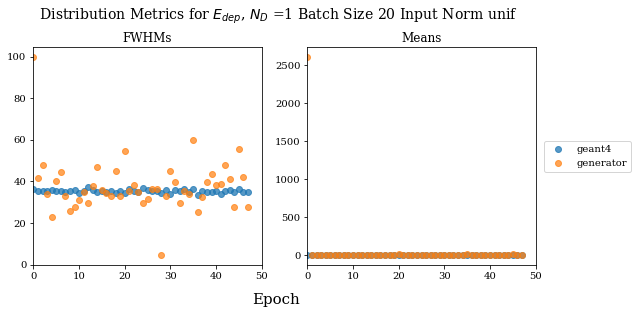

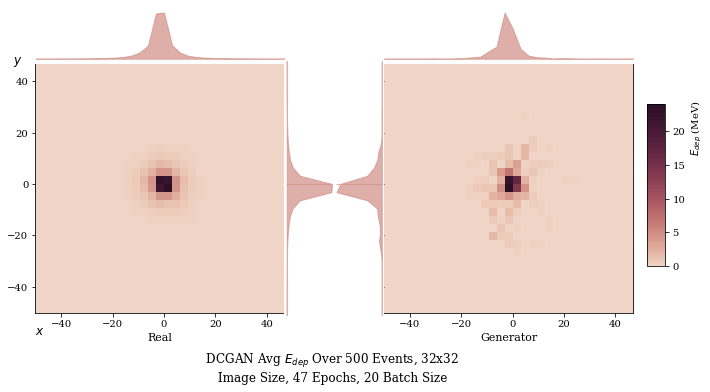

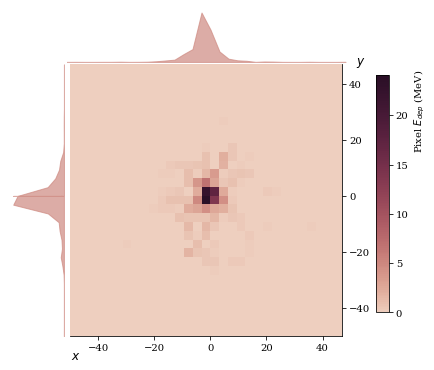

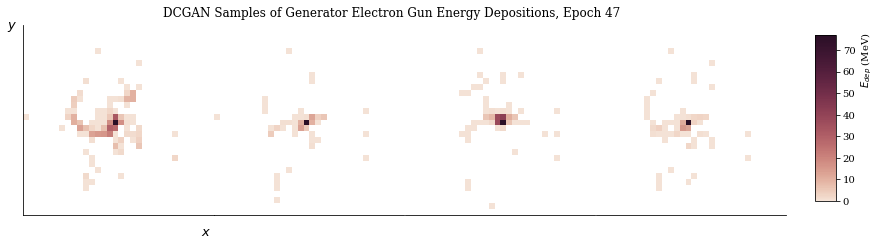

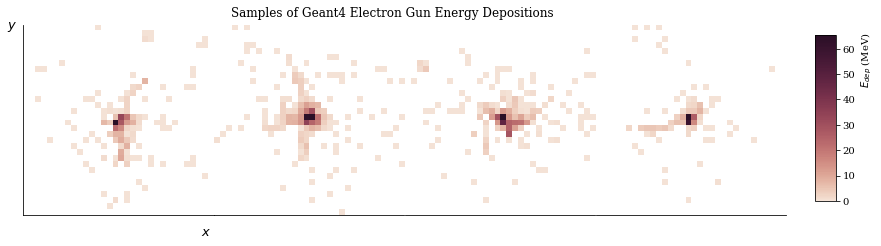

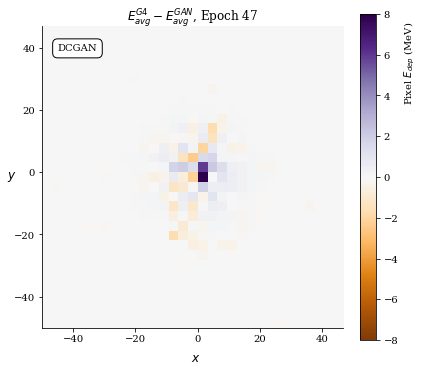

[47/50][0/1500] Loss_D: 0.0485 Loss_G: 6.3675 D(x): 0.9748 D(G(z)): 0.0049 / 0.0039
[47/50][100/1500] Loss_D: 0.0526 Loss_G: 7.0681 D(x): 0.9955 D(G(z)): 0.0318 / 0.0056
[47/50][200/1500] Loss_D: 0.1068 Loss_G: 4.5811 D(x): 0.9317 D(G(z)): 0.0054 / 0.0159
[47/50][300/1500] Loss_D: 0.0607 Loss_G: 5.0969 D(x): 0.9865 D(G(z)): 0.0319 / 0.0104
[47/50][400/1500] Loss_D: 0.0384 Loss_G: 5.4201 D(x): 0.9994 D(G(z)): 0.0205 / 0.0078
[47/50][500/1500] Loss_D: 0.2655 Loss_G: 5.1079 D(x): 0.8147 D(G(z)): 0.0003 / 0.0148
[47/50][600/1500] Loss_D: 0.0268 Loss_G: 5.1564 D(x): 0.9998 D(G(z)): 0.0104 / 0.0077
[47/50][700/1500] Loss_D: 0.0806 Loss_G: 10.7377 D(x): 0.9438 D(G(z)): 0.0003 / 0.0000
[47/50][800/1500] Loss_D: 0.2929 Loss_G: 4.8653 D(x): 0.9472 D(G(z)): 0.0729 / 0.0111
[47/50][900/1500] Loss_D: 0.0325 Loss_G: 4.9019 D(x): 0.9986 D(G(z)): 0.0148 / 0.0113
[47/50][1000/1500] Loss_D: 0.1490 Loss_G: 4.6756 D(x): 0.9148 D(G(z)): 0.0433 / 0.0123
[47/50][1100/1500] Loss_D: 0.1907 Loss_G: 3.0366 D(x):

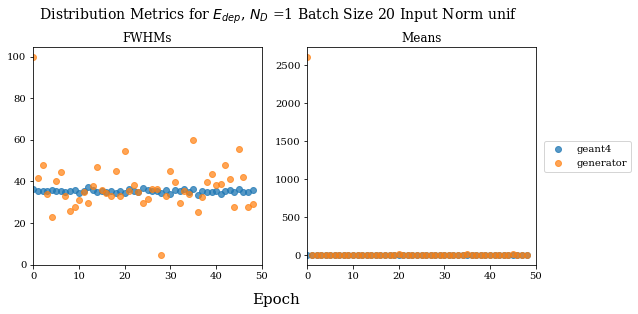

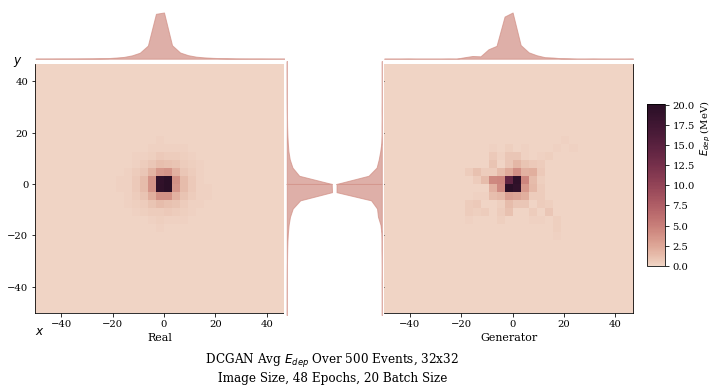

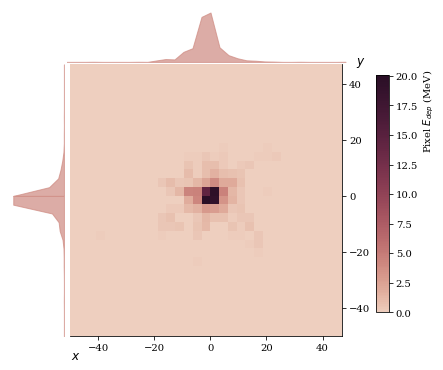

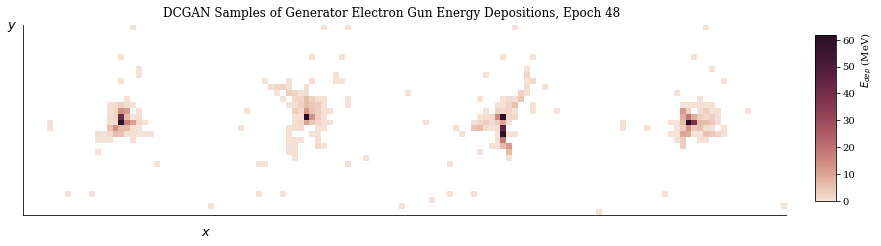

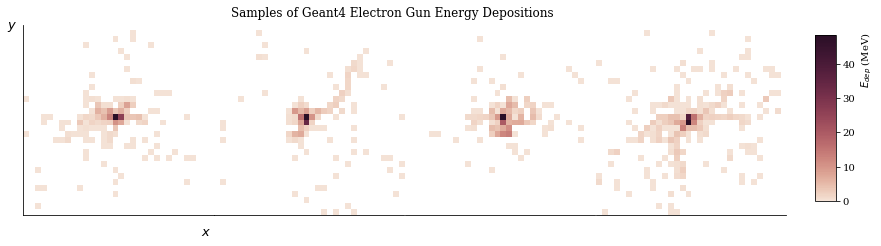

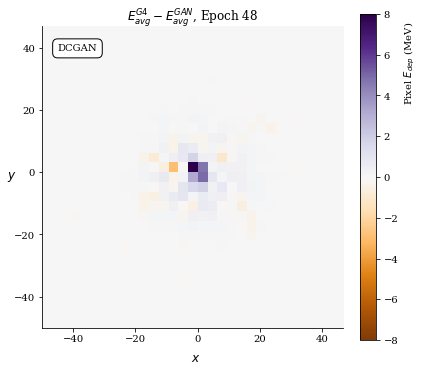

[48/50][0/1500] Loss_D: 0.0457 Loss_G: 4.8266 D(x): 0.9774 D(G(z)): 0.0089 / 0.0094
[48/50][100/1500] Loss_D: 0.0948 Loss_G: 4.6009 D(x): 0.9515 D(G(z)): 0.0125 / 0.0154
[48/50][200/1500] Loss_D: 0.3789 Loss_G: 3.2957 D(x): 0.7888 D(G(z)): 0.0080 / 0.0713
[48/50][300/1500] Loss_D: 0.0184 Loss_G: 6.7376 D(x): 0.9994 D(G(z)): 0.0018 / 0.0019
[48/50][400/1500] Loss_D: 0.0267 Loss_G: 6.8118 D(x): 0.9962 D(G(z)): 0.0097 / 0.0013
[48/50][500/1500] Loss_D: 0.2512 Loss_G: 5.6305 D(x): 0.9709 D(G(z)): 0.1830 / 0.0046
[48/50][600/1500] Loss_D: 0.0769 Loss_G: 5.3876 D(x): 1.0000 D(G(z)): 0.0557 / 0.0077
[48/50][700/1500] Loss_D: 0.0487 Loss_G: 6.1485 D(x): 0.9952 D(G(z)): 0.0302 / 0.0056
[48/50][800/1500] Loss_D: 0.0184 Loss_G: 8.3149 D(x): 0.9981 D(G(z)): 0.0017 / 0.0005
[48/50][900/1500] Loss_D: 0.1006 Loss_G: 9.1718 D(x): 0.9432 D(G(z)): 0.0001 / 0.0002
[48/50][1000/1500] Loss_D: 0.0526 Loss_G: 5.7223 D(x): 0.9693 D(G(z)): 0.0054 / 0.0052
[48/50][1100/1500] Loss_D: 0.0733 Loss_G: 6.2190 D(x): 

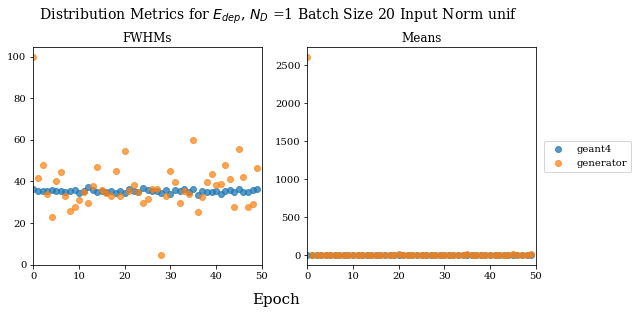

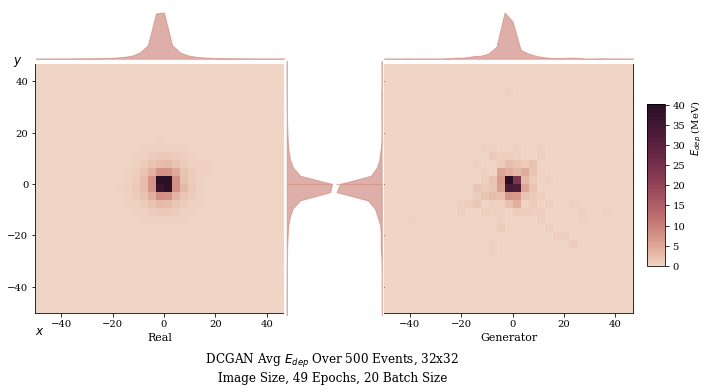

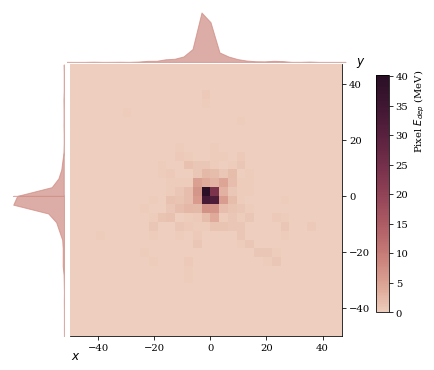

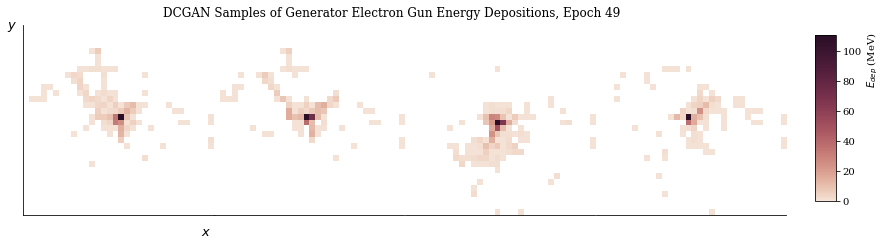

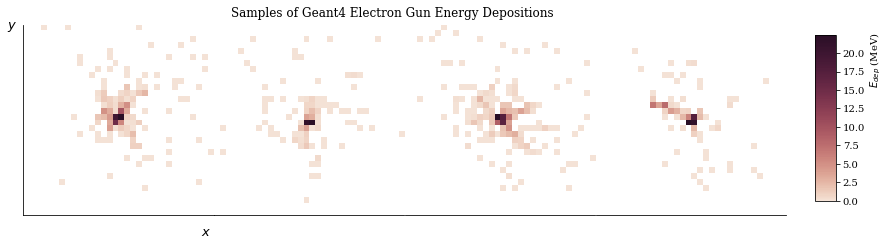

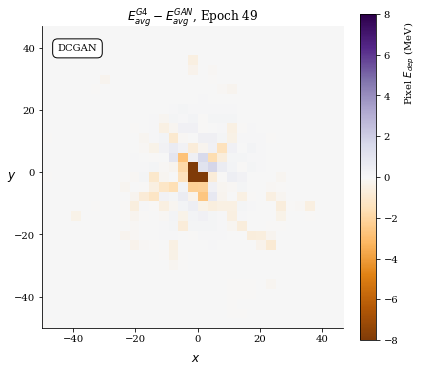

[49/50][0/1500] Loss_D: 1.4095 Loss_G: 5.6050 D(x): 0.4810 D(G(z)): 0.0000 / 0.0083
[49/50][100/1500] Loss_D: 0.0890 Loss_G: 4.7915 D(x): 0.9408 D(G(z)): 0.0070 / 0.0173
[49/50][200/1500] Loss_D: 0.3304 Loss_G: 3.0237 D(x): 0.8242 D(G(z)): 0.0115 / 0.0613
[49/50][300/1500] Loss_D: 0.0240 Loss_G: 5.9323 D(x): 0.9957 D(G(z)): 0.0067 / 0.0053
[49/50][400/1500] Loss_D: 0.0326 Loss_G: 5.0985 D(x): 0.9972 D(G(z)): 0.0166 / 0.0093
[49/50][500/1500] Loss_D: 0.0664 Loss_G: 6.3637 D(x): 0.9538 D(G(z)): 0.0055 / 0.0034
[49/50][600/1500] Loss_D: 0.0413 Loss_G: 5.5314 D(x): 0.9991 D(G(z)): 0.0227 / 0.0077
[49/50][700/1500] Loss_D: 0.0226 Loss_G: 6.5543 D(x): 0.9953 D(G(z)): 0.0029 / 0.0020
[49/50][800/1500] Loss_D: 0.0319 Loss_G: 5.6723 D(x): 0.9883 D(G(z)): 0.0064 / 0.0048
[49/50][900/1500] Loss_D: 0.0455 Loss_G: 5.5515 D(x): 0.9911 D(G(z)): 0.0209 / 0.0063
[49/50][1000/1500] Loss_D: 0.0575 Loss_G: 6.0016 D(x): 0.9757 D(G(z)): 0.0136 / 0.0222
[49/50][1100/1500] Loss_D: 0.1340 Loss_G: 3.5920 D(x): 

In [77]:
iter_range = range(niter)
iter_range = tqdm(iter_range)


#make save directory
mydir = os.path.join('/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCGAN/', 
                     datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + "/")
#mydir = None
print(mydir)
try:
    os.makedirs(mydir)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise
        
extraD = 1
epochs = []
genx_FWHMs = []
genx_means = []
realx_FWHMs = []
realx_means =  []
for epoch in iter_range:
    if True:
        print(type(epoch))
        data_arrs, n_events = make_samples(netG, n_events = 500, real=True, fake=True)
        real_data_array, fake_data_array = make_stacked_samples(netG, n_events = 500,real= True, fake = True)
        genx_FWHM = hist_width(np.sum(data_arrs[1],1))
        realx_FWHM = hist_width(np.sum(data_arrs[0],1))
        genx_mean = np.sum(data_arrs[1],1).mean()
        realx_mean = np.sum(data_arrs[0],1).mean()
        genx_FWHMs.append(genx_FWHM)
        realx_FWHMs.append(realx_FWHM)
        genx_means.append(genx_mean)
        realx_means.append(realx_mean)
        epochs.append(epoch)
        plot_all_metrics(genx_FWHMs, realx_FWHMs, genx_means, realx_means,epochs = epochs, save_dir = mydir)
        plot_avg_both(data_arrs[0],data_arrs[1], n_events, save_dir = mydir,  epoch = epoch)
        plot_avg(data_arrs[1], n_events, save_dir= mydir,  epoch = epoch)
        plot_many(fake_data_array, real=False, save_dir=mydir, epoch = epoch)
        plot_many(real_data_array, real=True, save_dir=mydir, epoch = epoch)
        plot_difference(data_arrs, save_dir = None, epoch = epoch)
    for i, data in enumerate(dataloader,0):
        for j in range(extraD):
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z))), do it more than generator
            ###########################
            # train with real
            netD.zero_grad()
            real_cpu = data[0].to(device)
            batch_size = real_cpu.size(0)
            label = torch.full((batch_size,), real_label, device=device)

            output = netD(real_cpu)
            real_cpu.requires_grad_()
            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()

            # train with fake
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake = netG(noise)
            label.fill_(fake_label)
            output = netD(fake.detach())
            errD_fake = criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake
            optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 100 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch, niter, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
#         if i % 500 == 0:
#             vutils.save_image(real_cpu.data,
#                     '%s/real_samples.png' % outf,
#                     normalize=True)
#             fake = netG(fixed_noise)
#             vutils.save_image(fake.detach(),
#                     '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
#                    normalize=True)

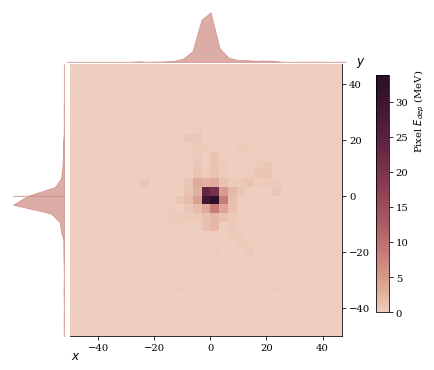

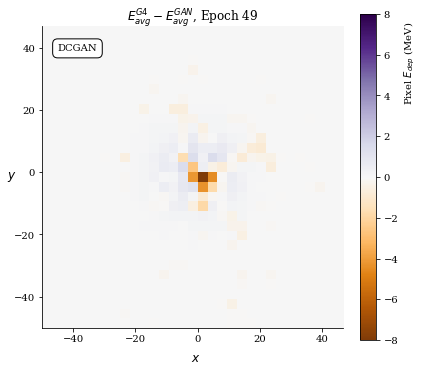

In [68]:
#FAKE
#from mpl_toolkits.axes_grid1 import make_axes_locatable



test_unnormed, n_events = make_samples(netG,n_events = 500, real=False)
plot_avg(test_unnormed, n_events = 500, save_dir=None)
data, n_events = make_samples(netG, n_events = 500, real=True, fake=True)
plot_difference(data, save_dir = None, epoch = epoch)

In [ ]:
plot_sns()
#plot_samples()

In [229]:
test = np.squeeze(image_array)
for i in range(test.shape[0]):
    if np.isnan(test[i].max()) ==True:
        print(i)

In [213]:
#REAL
plt.rc('font', family='serif')
many_samples = True
n_events = 5000
#make single samples for both real and fake. then make many samples and average if many_samples = True

#real
idx = np.random.randint(low = 0, high = image_array.shape[0], size =1)[0]
real_image = image_array[idx][0]

#fake
noise = torch.randn(batch_size, nz, 1, 1, device=device)
fake = netG(noise)
fake_image = fake.to('cpu').detach().numpy()[0][0]
test_unnormed =  arctanh_unnormalize(fake_image, scale)

if many_samples == True:
    for i in range(n_events):
        idx = np.random.randint(low = 0, high = image_array.shape[0], size =1)[0]
        real_image += image_array[idx][0]
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        fake_image = fake.to('cpu').detach().numpy()[0][0]
        test_unnormed +=  arctanh_unnormalize(fake_image, scale)

real_image = real_image / n_events
test_unnormed = test_unnormed / n_events
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(9, 6), sharex=True, sharey=True)
xran = (-50,50)
yran = (-50,50)
extent = xran + yran





real_image[real_image < 0.0] = np.nan
cmap = sns.cubehelix_palette(dark = 0.4, light=0.915, gamma = 2.5, hue = 1, start =0, as_cmap=True)
#plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
im = ax1.imshow(real_image, vmin = 0, extent=extent, origin='lower', cmap=cmap)




ax1.set_title("Real")
#cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
#cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
        
test_unnormed[test_unnormed < 0.0] = np.nan
im = ax2.imshow(test_unnormed, vmin = 0, extent=extent, origin='lower', cmap=cmap)
ax2.set_title("Generator")

fig.tight_layout(rect=[0, 0, .9, 1])
cbar_ax = fig.add_axes([0.9, 0.25, 0.025, 0.5])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label(r'$E_{dep}$ (MeV)', y =0.85)
fig.subplots_adjust(wspace=0.1, hspace=0)
fig.suptitle(r" DCGAN Avg $E_{dep}$ Over " + str(n_events) + " Events, "
             + str(imageSize) + "x" +str(imageSize) + " Image Size, " + str(niter) 
             + " Epochs, " + str(batchSize) + " Batch Size", x = 0.5, y = 0.9)
plt.show()

TypeError: unsupported operand type(s) for /: 'int' and 'list'

In [412]:
mydir = os.path.join('/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCGAN/', 
                     datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + '/')
print(mydir)
try:
    os.makedirs(mydir)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCGAN/2018-05-16_17-09-05/


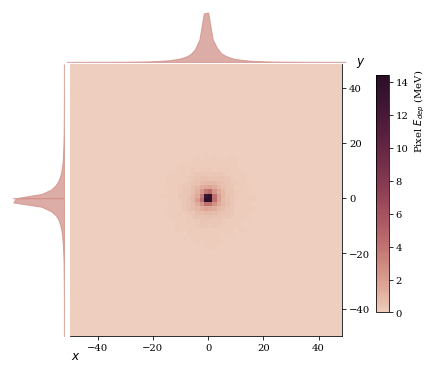

In [195]:
test_unnormed, n_events = make_samples(netG,n_events = 500, real=True, fake = True)
plot_avg(test_unnormed[0], n_events = 500, save_dir=None)

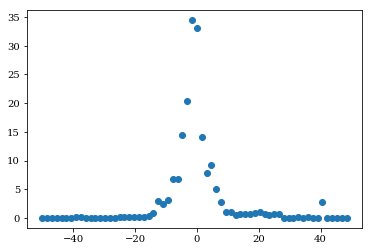

In [35]:
x = np.linspace(-50,50, 64)
t = np.arange(-50,50, 100/float(imageSize))
plt.scatter(t,np.sum(test_unnormed,1) )

In [37]:


print(hist_width(np.sum(test_unnormed[0], 0)))
print(hist_width(np.sum(test_unnormed[1], 0)))

0.0
0.0
